# Detecció de parla falsa mitjançant Intel·ligència Artifical

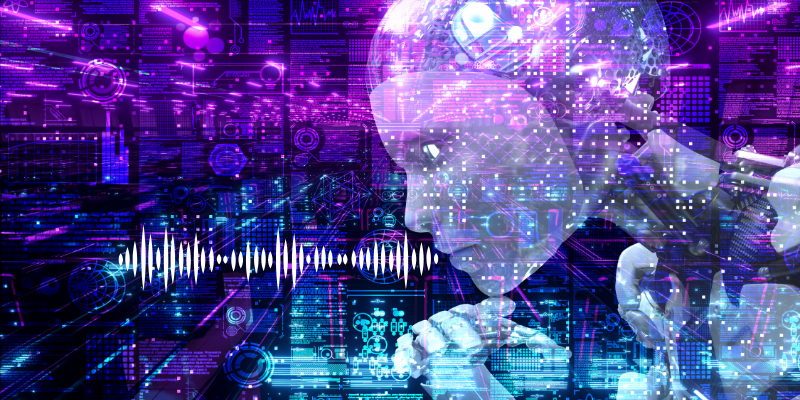

In [115]:
pip install pandas seaborn plotly descartes geopandas librosa opensmile audb pyarrow

Note: you may need to restart the kernel to use updated packages.


In [116]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Map 1 library
import plotly.express as px

# Map 2 libraries
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Librosa Libraries
import librosa
import librosa.display
import IPython.display as ipd

import sklearn

import warnings
warnings.filterwarnings('ignore')

In [117]:
# Import data
train_csv = pd.read_csv("./training_set.csv")
test_csv = pd.read_csv("./test_set.csv")
full_csv = pd.read_csv("./full_habla_updated_metadata.csv")

train_csv['Realornot'].value_counts()

Realornot
1    8939
0    8865
Name: count, dtype: int64

In [118]:
# Inspect text_csv before checking train data
train_csv['Category'].value_counts()

Category
Real           8939
StarGAN        1500
CycleGAN       1488
Diff           1488
TTS-Diff       1478
TTS-StarGAN    1478
TTS            1433
Name: count, dtype: int64

1. ANALISI ESTADÍSTIC I PREPROCESSAT DE LES DADES:

definim el mètode data explore i l'utilitzem per full_csv i per el smile_features juntament amb un describe

In [119]:
def data_explore_n(dataframe):
    print("DATA EXPLORATION")
    print('*'*70)
    print("Shape of dataset : ",dataframe.shape)
    print('*'*70)
    print(dataframe.info())
    print('*'*70)
    print("STATISTICAL ANALYSIS OF NUMERICAL DATA")
    print('*'*70)
    print(dataframe.describe().T)
    print('*'*70)
    print("STATISTICAL ANALYSIS OF CATEGORICAL DATA")
    print('*'*70)
    #print(dataframe.describe(exclude = ['float', 'int64']).T)
    print('*'*70)
    print("MISSING VALUES")
    print('*'*70)
    print(dataframe.isna().sum().sort_values(ascending=False))
    print('*'*70)
    print("MISSING VALUES IN %")
    print('*'*70)
    print(round(100* (dataframe.isnull().sum() / len(dataframe)).sort_values(ascending=False),2))
    print('*'*70)

In [120]:
df_smile = pd.read_csv('./smile_feature_selected.csv')
data_explore_n(df_smile)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (80816, 16)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80816 entries, 0 to 80815
Data columns (total 16 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      80816 non-null  int64  
 1   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   80816 non-null  float64
 2   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    80816 non-null  float64
 3   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1  80816 non-null  float64
 4   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  80816 non-null  float64
 5   loudness_sma3_amean                             80816 non-null  float64
 6   spectralFlux_sma3_stddevNorm                    80816 non-null  float64
 7   mf

In [121]:
full_csv.describe()

File_ID  File_Source_ID  File_Target_ID  Source_Utterance  \
count  22816.000000    53000.000000    58000.000000      5.300000e+04   
mean    5318.306013     5627.025472     4978.257431      1.053960e+09   
std     2931.884349     2992.791019     2809.097043      6.262829e+08   
min      295.000000      295.000000      295.000000      6.927600e+04   
25%     2484.000000     3034.000000     2484.000000      5.018486e+08   
50%     5223.000000     5223.000000     4310.000000      1.044592e+09   
75%     8421.000000     8784.000000     7508.000000      1.584616e+09   
max     9799.000000     9799.000000     9799.000000      2.147315e+09   

       Target_Utterance     Utterance      Variant         Times      UniqueID  
count      5.300000e+04  2.281600e+04  2500.000000  80816.000000  80816.000000  
mean       1.340034e+08  1.071037e+09     0.594800    135.546699  40408.500000  
std        3.645009e+08  6.208544e+08     0.615438    194.773204  23329.714015  
min        0.000000e+00  6.927600e+04     0.000000      1.000000      1.000000  
25%        1.630400e+04  5.353323e+08     0.000000     41.000000  20204.750000  
50%        1.401600e+05  1.065023e+09     1.000000     51.000000  40408.500000  
75%        9.944568e+07  1.611582e+09     1.000000     96.000000  60612.250000  
max        2.147315e+09  2.147315e+09     2.000000    772.000000  80816.000000

In [122]:
def data_explore(dataframe):
    print("DATA EXPLORATION")
    print('*'*70)
    print("Shape of dataset : ",dataframe.shape)
    print('*'*70)
    print(dataframe.info())
    print('*'*70)
    print("STATISTICAL ANALYSIS OF NUMERICAL DATA")
    print('*'*70)
    print(dataframe.describe().T)
    print('*'*70)
    print("STATISTICAL ANALYSIS OF CATEGORICAL DATA")
    print('*'*70)
    #print(dataframe.describe(exclude = ['float', 'int64']).T)
    print('*'*70)
    print("MISSING VALUES")
    print('*'*70)
    print(dataframe.isna().sum().sort_values(ascending=False))
    print('*'*70)
    print("MISSING VALUES IN %")
    print('*'*70)
    print(round(100* (dataframe.isnull().sum() / len(dataframe)).sort_values(ascending=False),2))
    print('*'*70)

data_explore(full_csv)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (80816, 25)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80816 entries, 0 to 80815
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Filename          80816 non-null  object 
 1   F_path            80816 non-null  object 
 2   F1                80816 non-null  object 
 3   F2                80816 non-null  object 
 4   F3                80816 non-null  object 
 5   F4                75816 non-null  object 
 6   ID                22816 non-null  object 
 7   File_ID           22816 non-null  float64
 8   Source_ID         53000 non-null  object 
 9   File_Source_ID    53000 non-null  float64
 10  Target_ID         58000 non-null  object 
 11  File_Target_ID    58000 non-null  float64
 12  Source_Sex        53000 non-null  obj

Fusionem variables i fem drop de les que no són necessàries

In [123]:
train_csv['Final_sex'] = train_csv['Sex'].combine_first(train_csv['Target_Sex'])

train_csv['Final_country'] = train_csv['Country'].combine_first(train_csv['Target_Country'])

train_csv.drop(['Target_Sex', 'Target_Country', 'Sex', 'Country'], axis=1, inplace=True)

test_csv['Final_sex'] = test_csv['Sex'].combine_first(test_csv['Target_Sex'])

test_csv['Final_country'] = test_csv['Country'].combine_first(test_csv['Target_Country'])

test_csv.drop(['Target_Sex', 'Target_Country', 'Sex', 'Country'], axis=1, inplace=True)

In [124]:
train_csv.drop(['Source_Sex', 'Source_Country', 'ID', 'Source_ID', 'Target_ID', 'F_path', 'Category'], axis=1, inplace=True)
test_csv.drop(['Source_Sex', 'Source_Country', 'ID', 'Source_ID', 'Target_ID', 'F_path', 'Category'], axis=1, inplace=True)

In [125]:
data_explore(train_csv)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (17804, 4)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17804 entries, 0 to 17803
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UniqueID       17804 non-null  int64 
 1   Realornot      17804 non-null  int64 
 2   Final_sex      17804 non-null  object
 3   Final_country  17804 non-null  object
dtypes: int64(2), object(2)
memory usage: 556.5+ KB
None
**********************************************************************
STATISTICAL ANALYSIS OF NUMERICAL DATA
**********************************************************************
             count          mean           std  min       25%      50%  \
UniqueID   17804.0  48359.654741  23540.862021  4.0  29993.25  56484.5   
Realornot  17804.0      0.502078      0.500010  0.0      0

In [126]:
train_csv.describe()

UniqueID     Realornot
count  17804.000000  17804.000000
mean   48359.654741      0.502078
std    23540.862021      0.500010
min        4.000000      0.000000
25%    29993.250000      0.000000
50%    56484.500000      1.000000
75%    67218.500000      1.000000
max    80815.000000      1.000000

mirem els valors unics de cada variable, despres de veureho determinem que no hem de transformar cap numerica a categorica ni viceversa

In [127]:
def variable_info(df):
    results = pd.DataFrame(columns=['Variable', 'Type', 'Unique Values'])
    for col in df.columns:
        var_type = df[col].dtype
        unique_values = df[col].nunique()
        
        info = pd.DataFrame([{
             'Variable': col, 
             'Type': var_type, 
             'Unique Values': unique_values
             }])
        
        results = pd.concat([results, info], ignore_index=True)
    
    return results

variable_info(train_csv)

Variable    Type Unique Values
0       UniqueID   int64         17804
1      Realornot   int64             2
2      Final_sex  object             2
3  Final_country  object             5

mirem les freqüències de les categoriques 

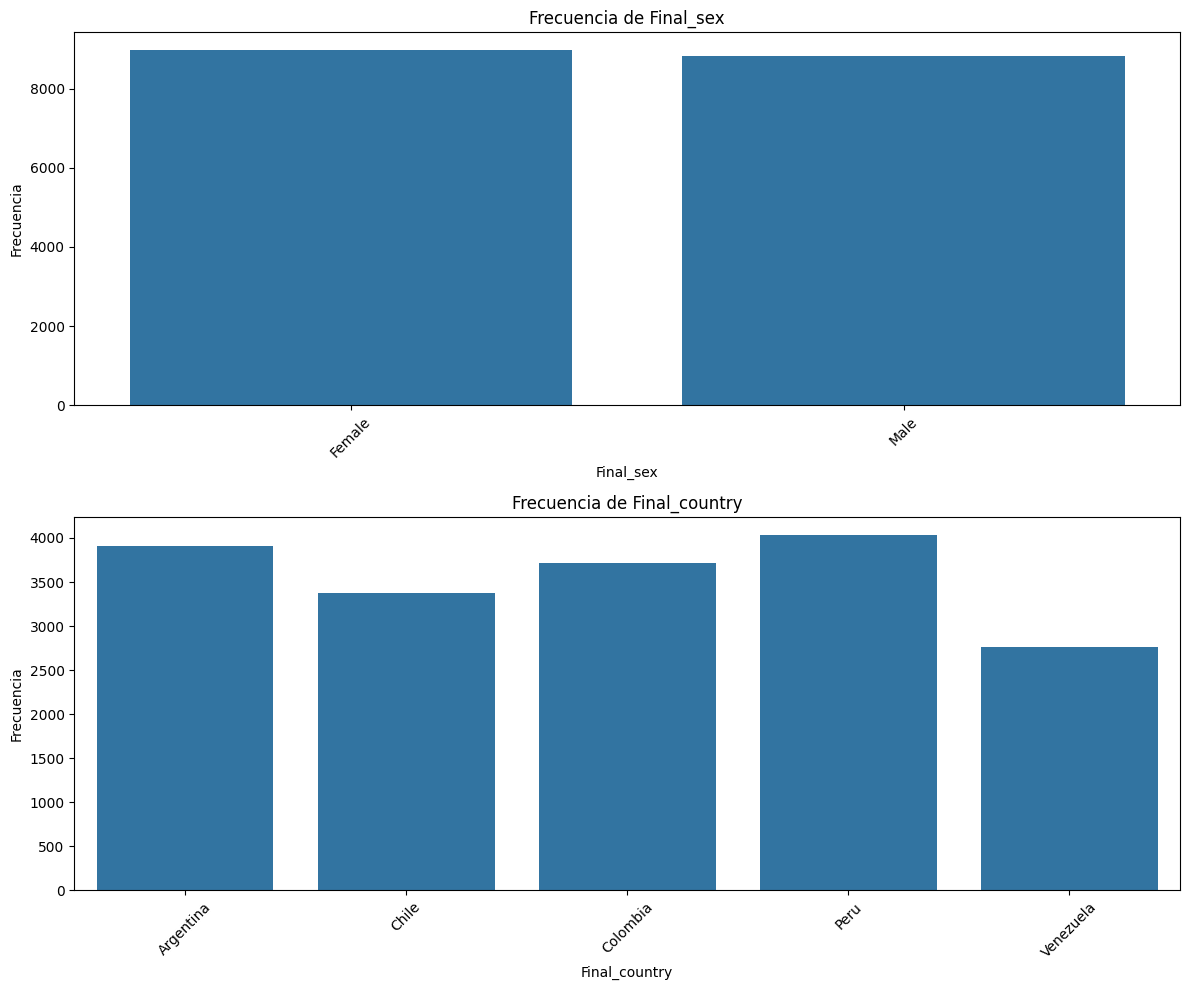

In [128]:
# Seleccionar las variables categóricas
categorical_vars = ['Final_sex', 'Final_country']

# Crear subplots
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(12, 5 * len(categorical_vars)))

# Generar gráficos de frecuencia para cada variable categórica
for i, var in enumerate(categorical_vars):
    sns.countplot(data=train_csv, x=var, ax=axes[i])
    axes[i].set_title(f'Frecuencia de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Mirem distribucions d'open smile (Detectem outliers i de pas mirem com quedaria sense els outliers) i del full

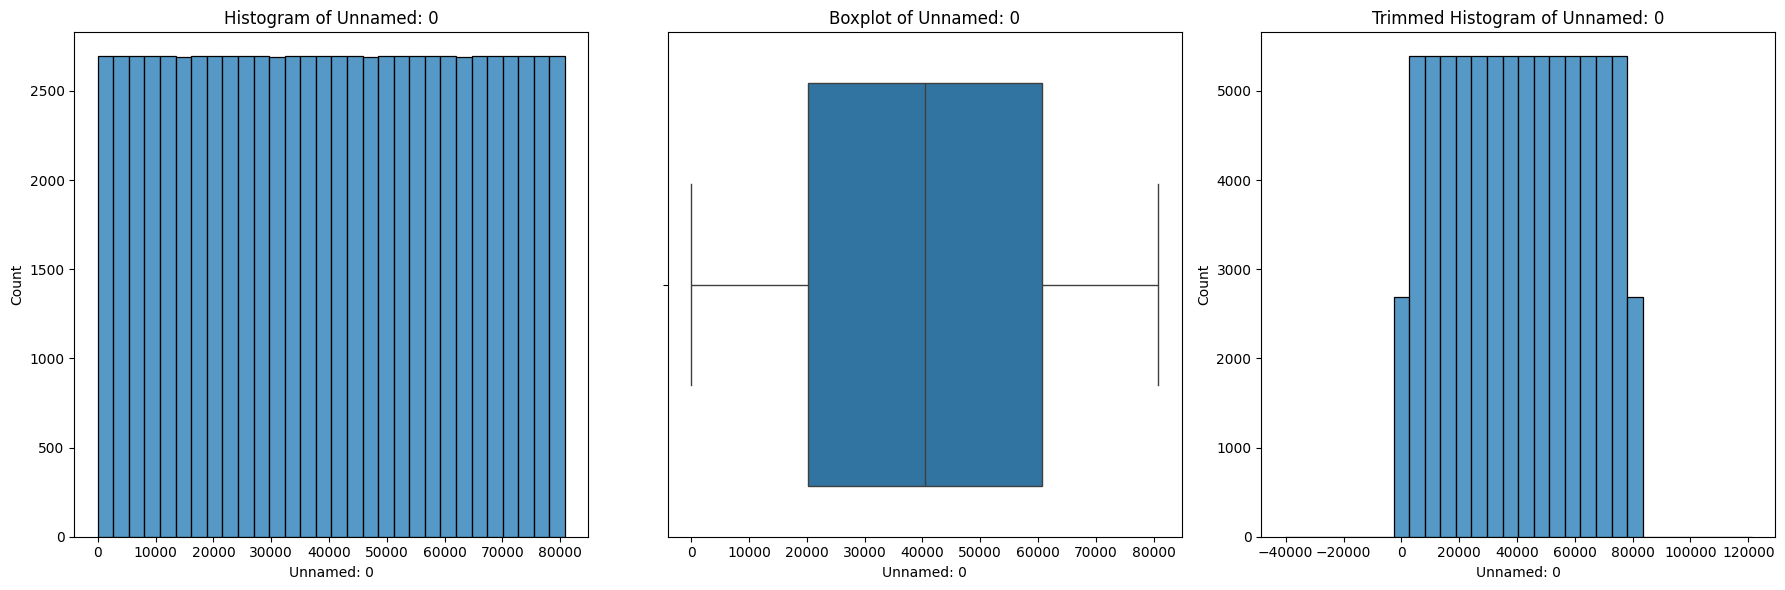

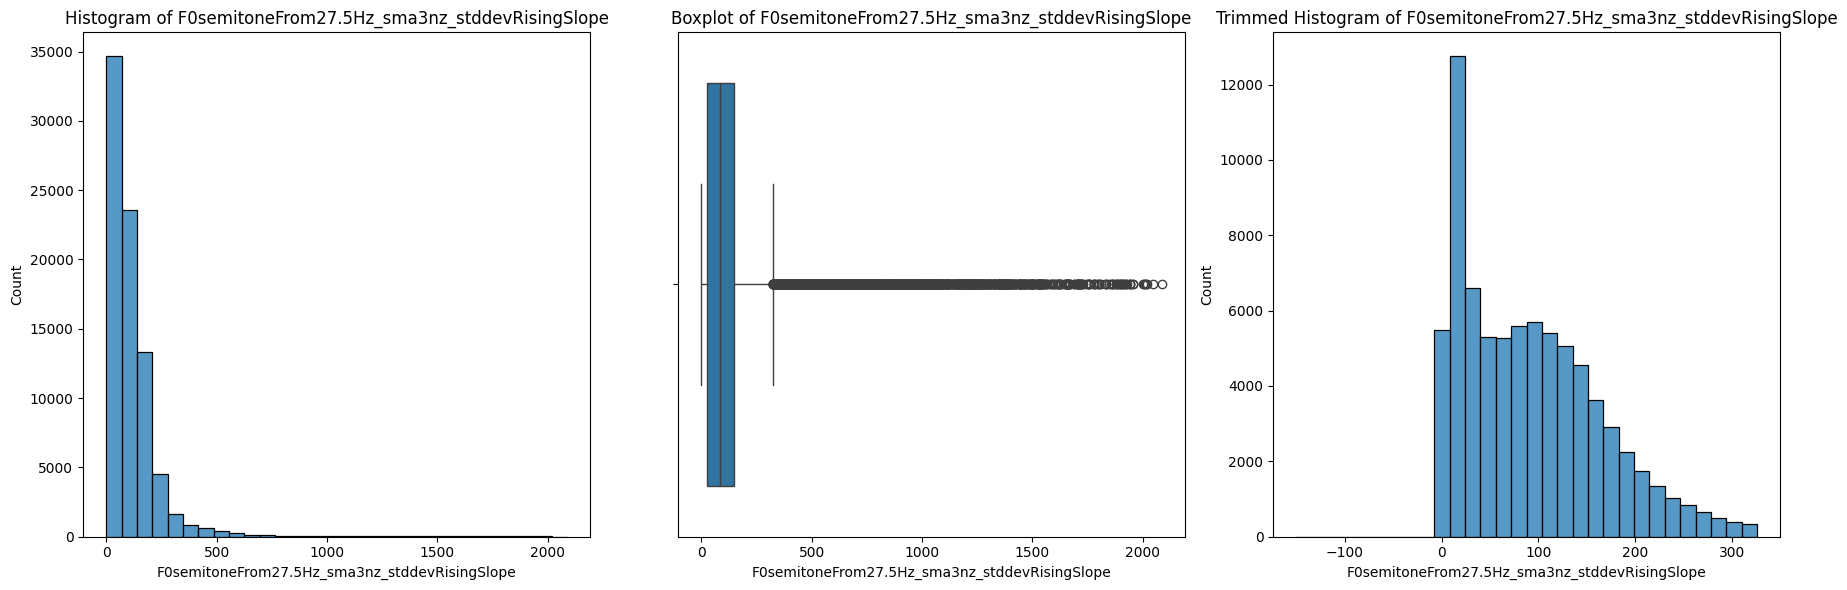

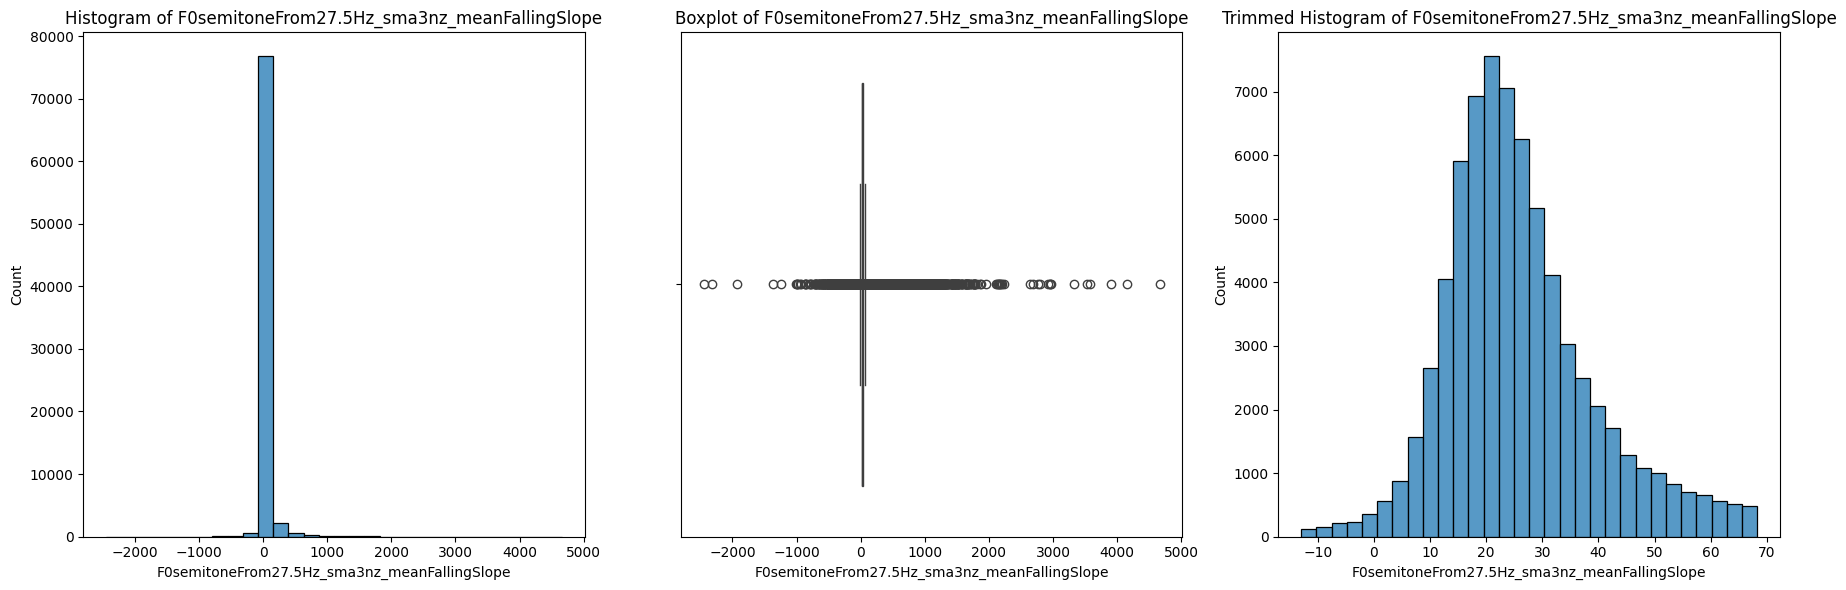

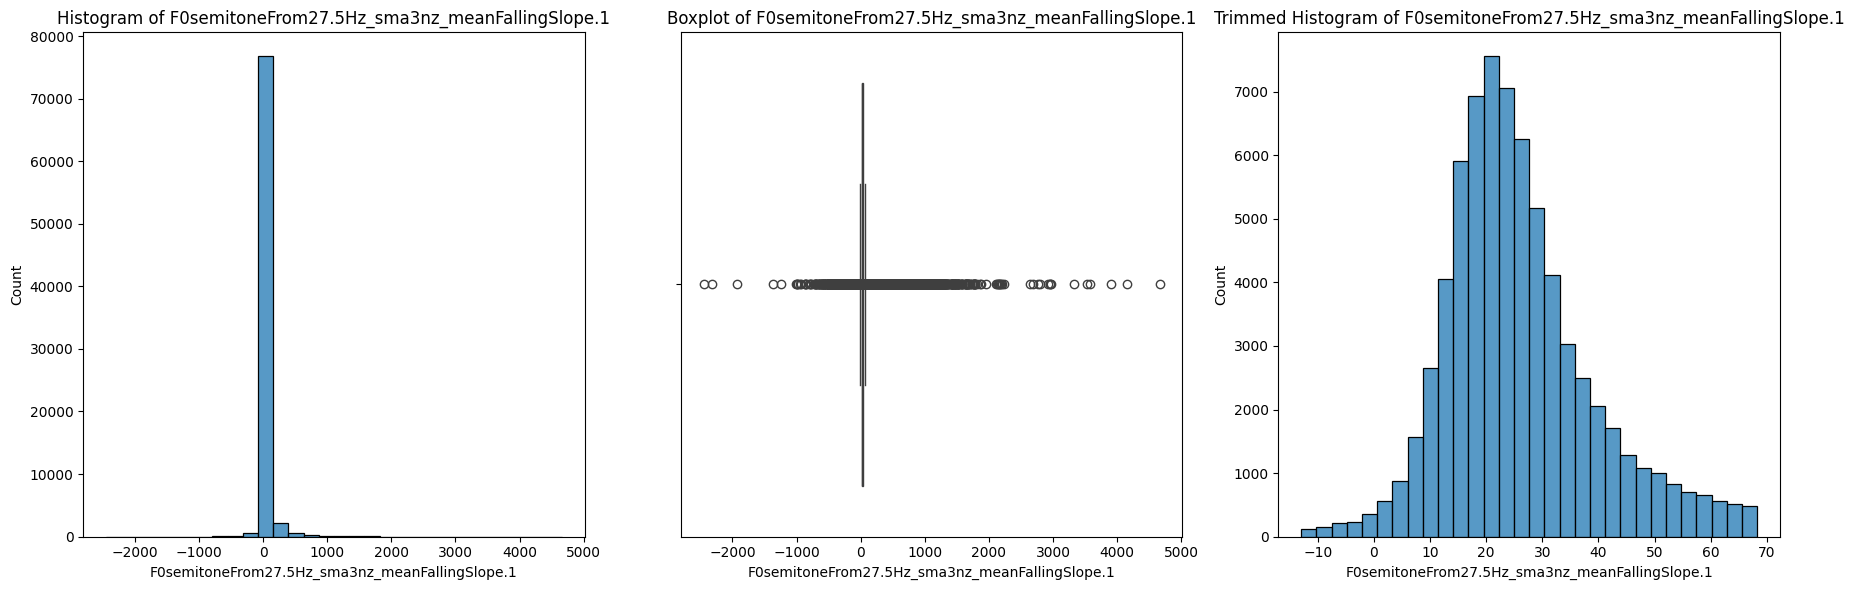

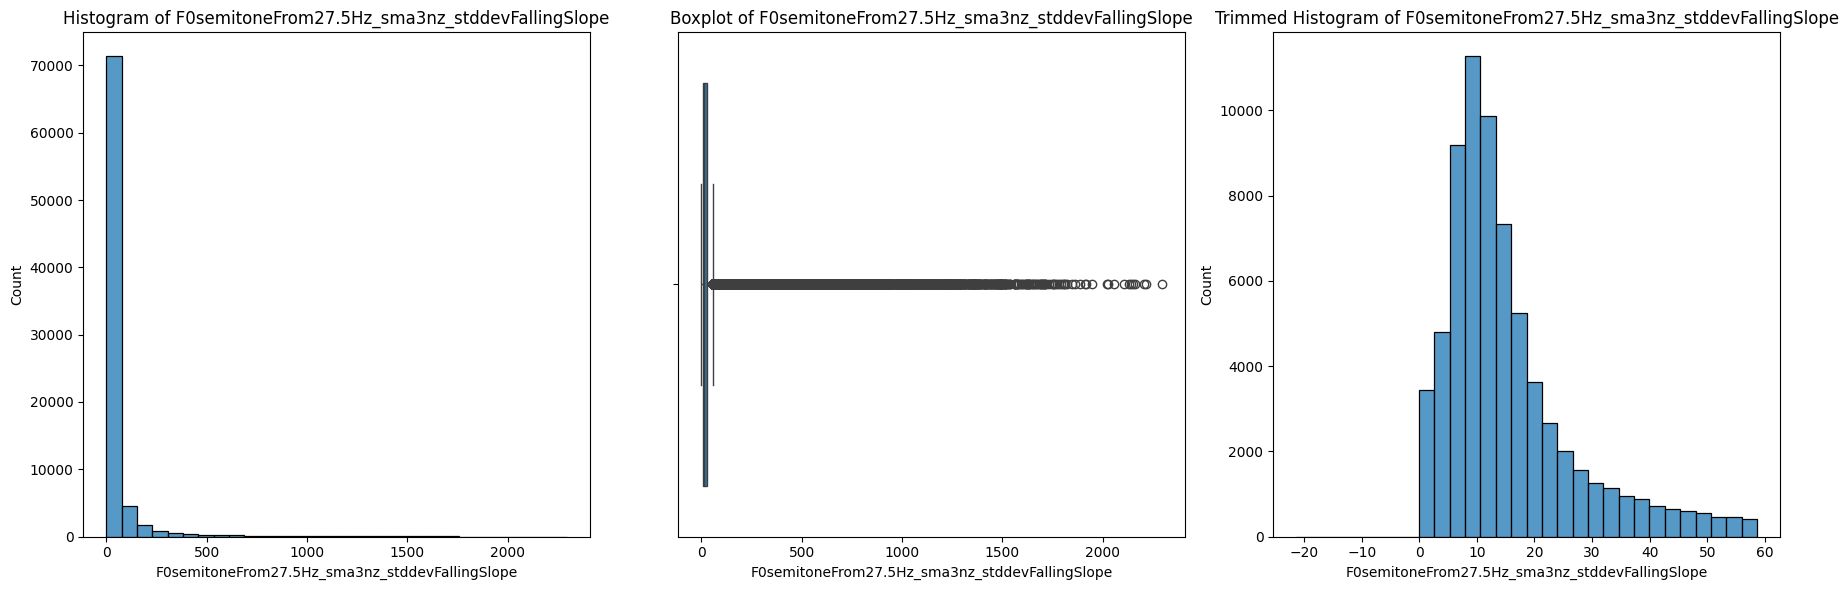

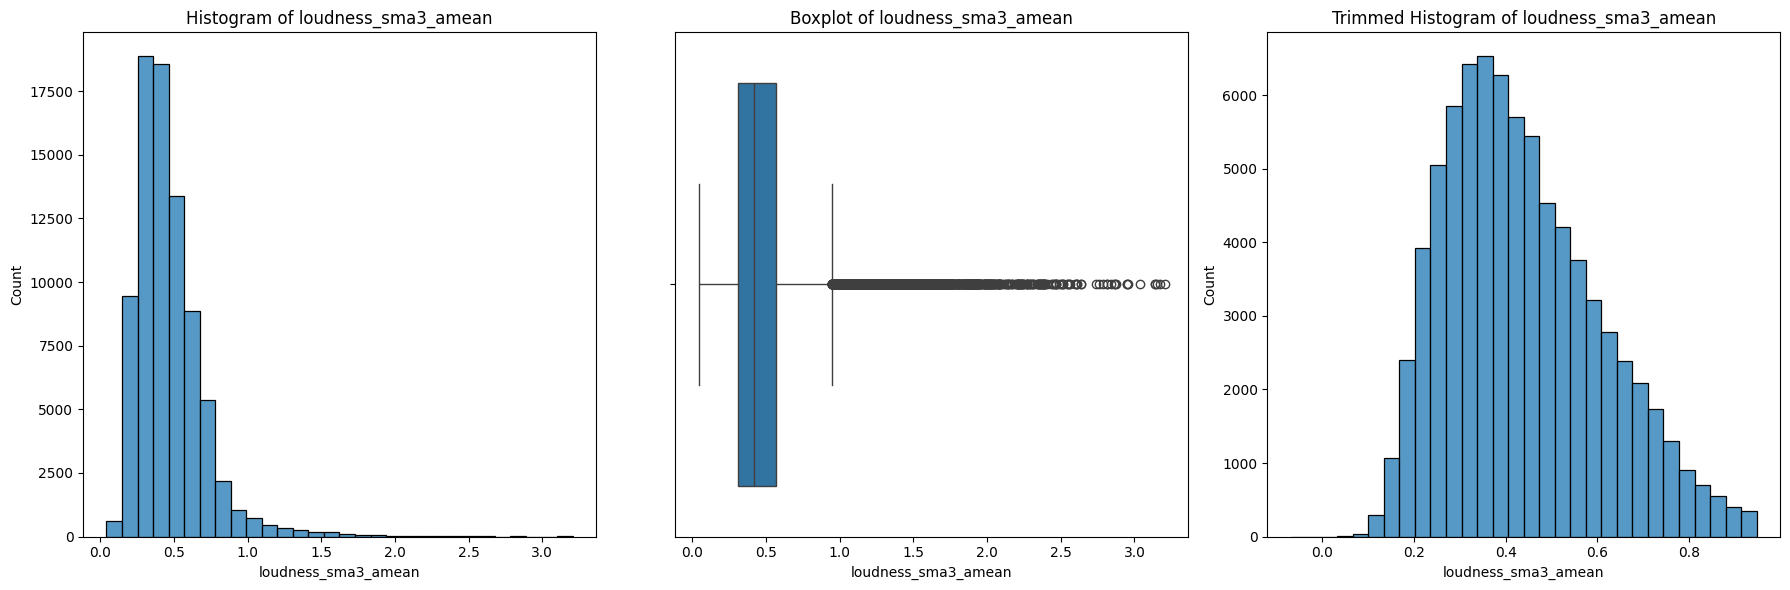

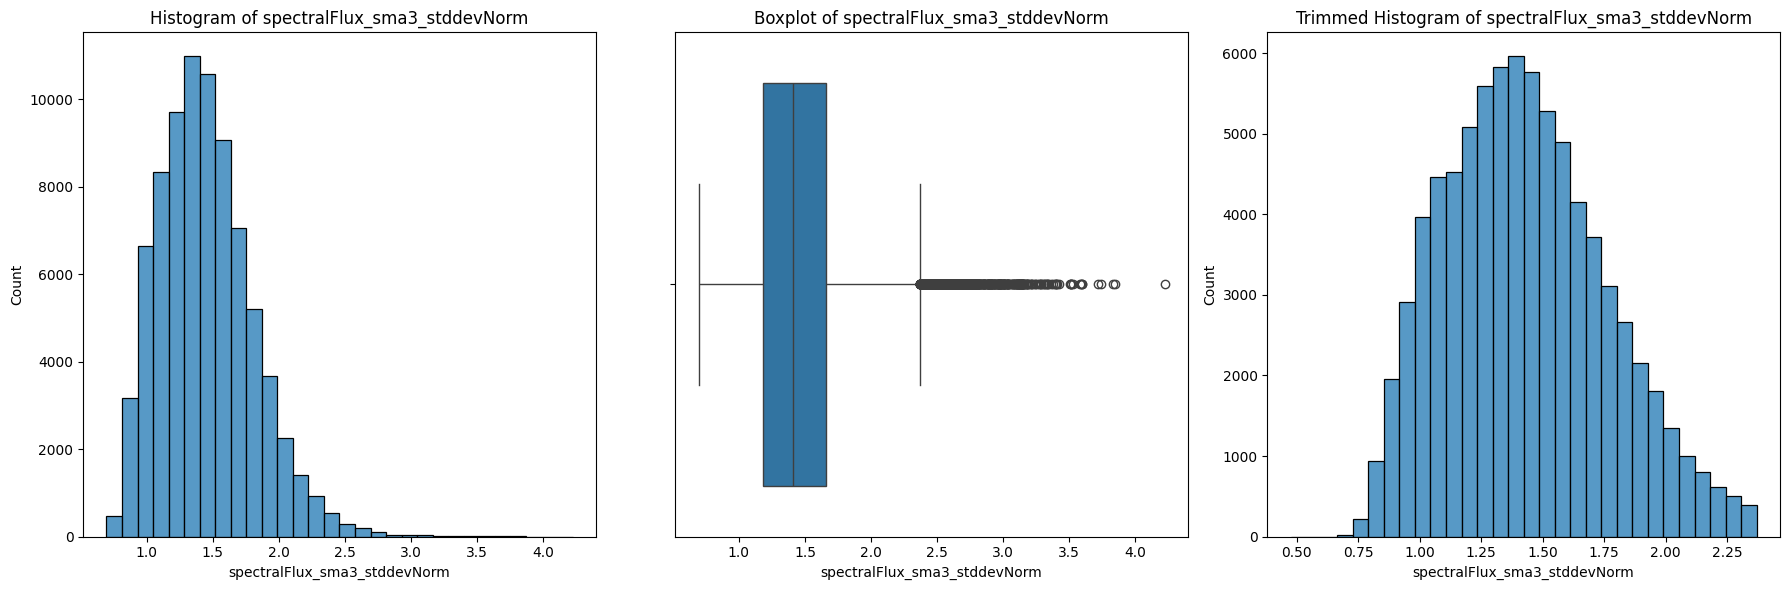

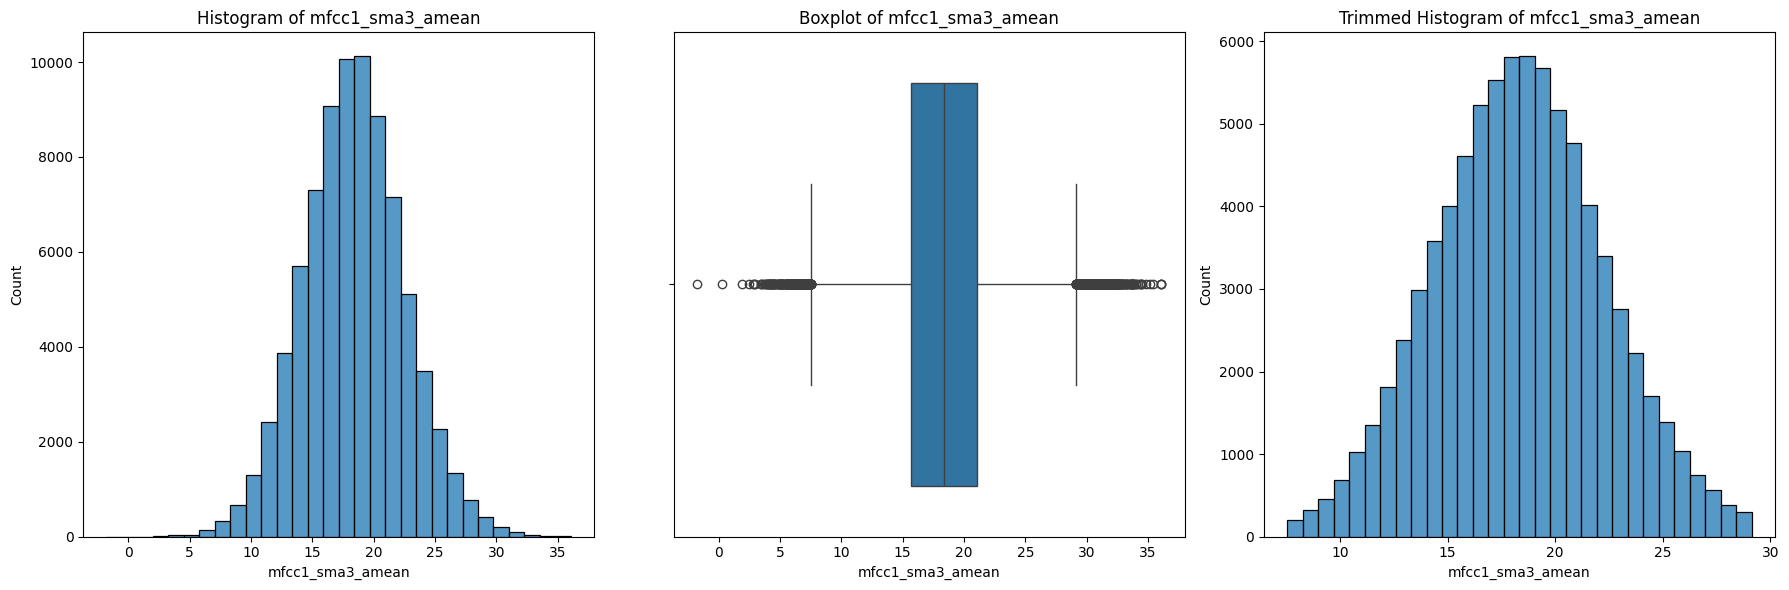

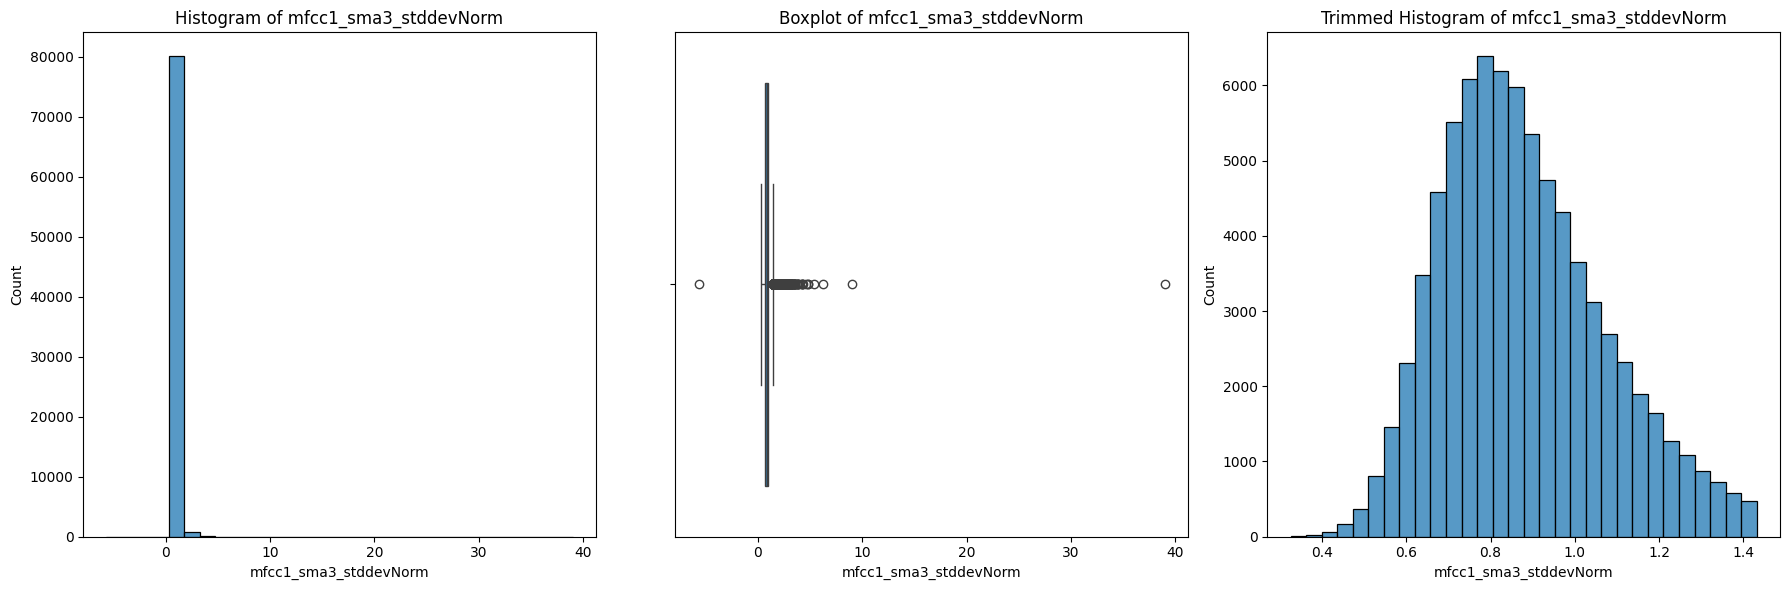

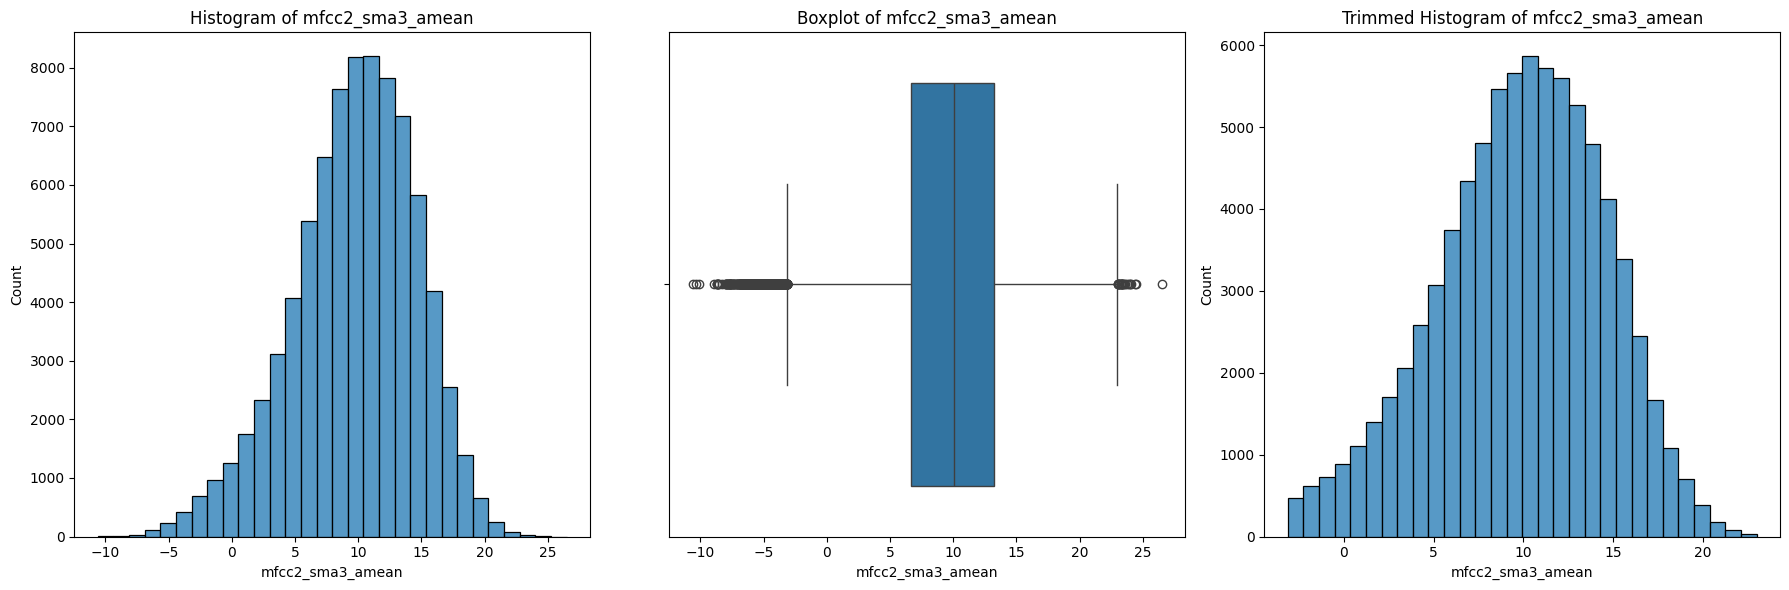

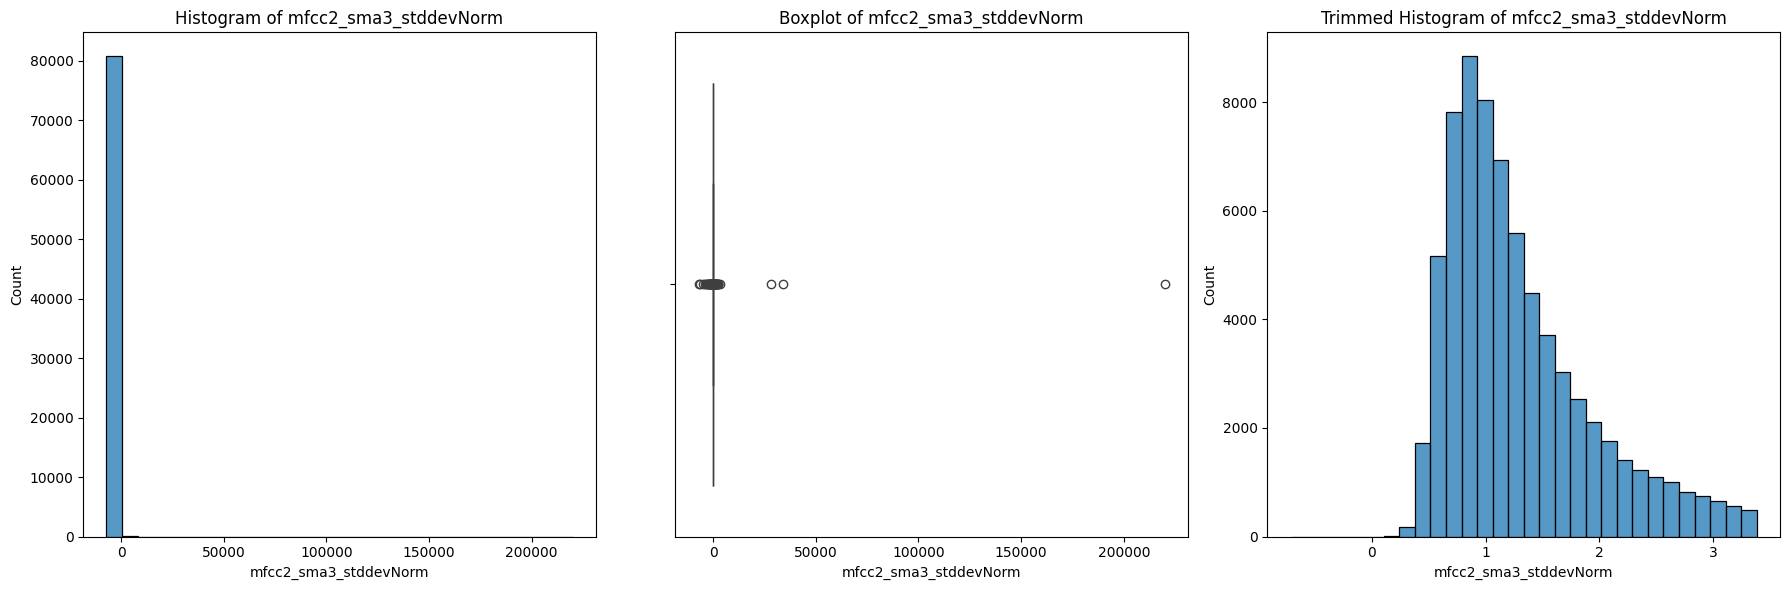

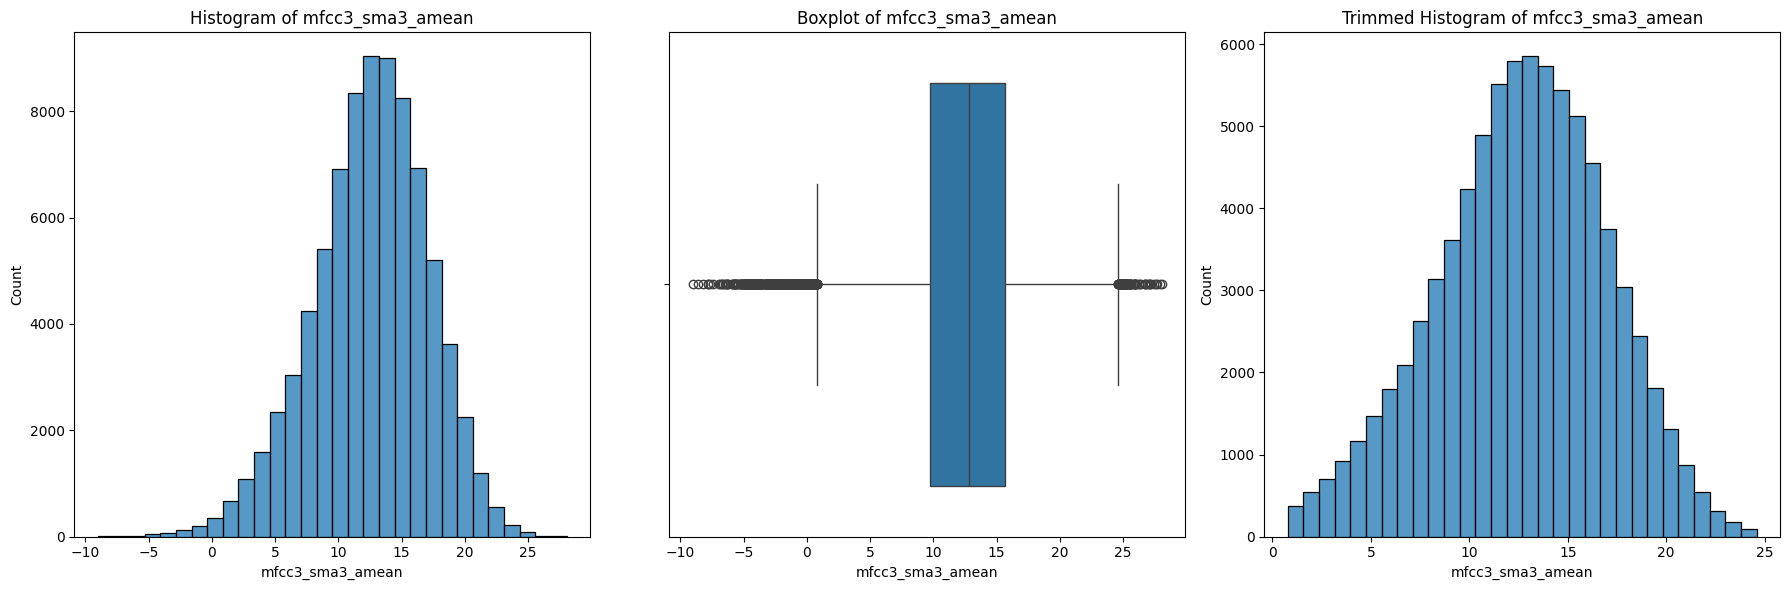

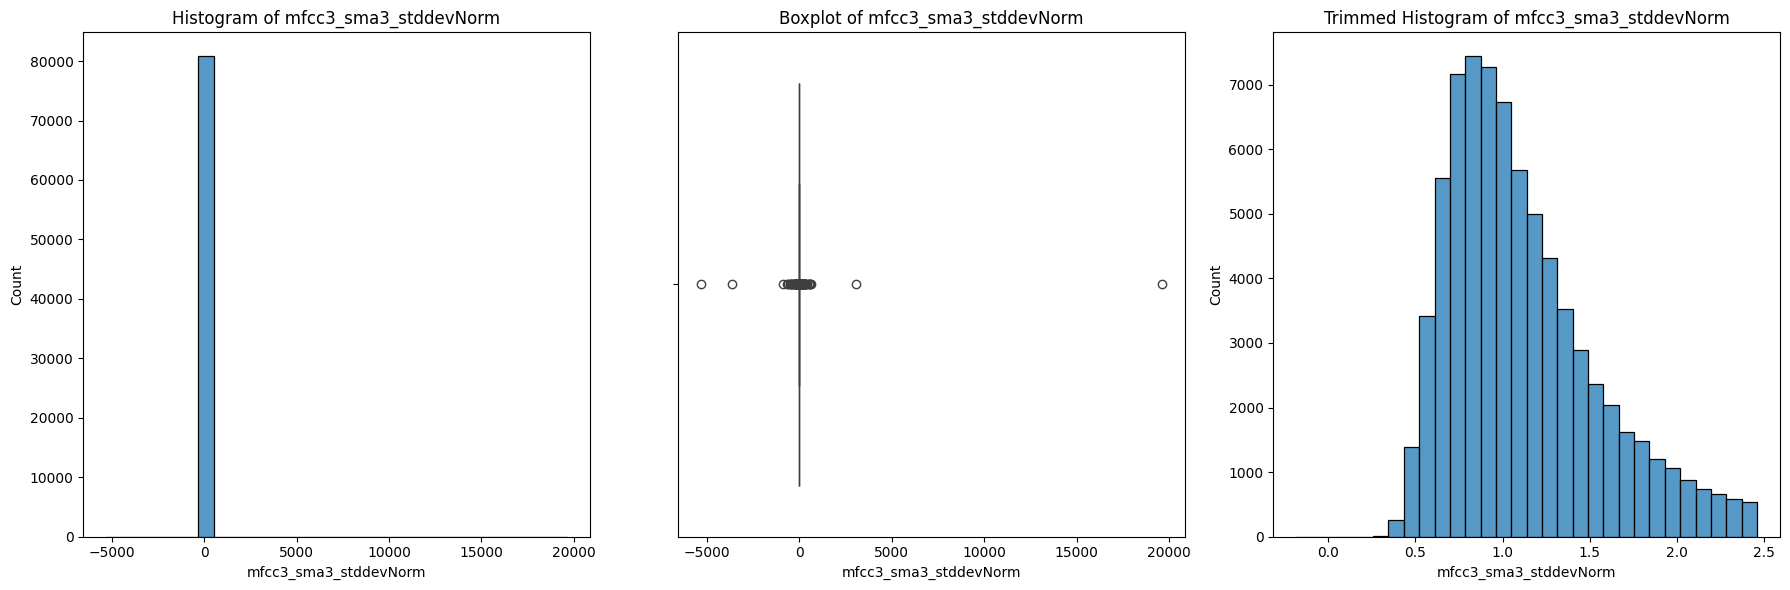

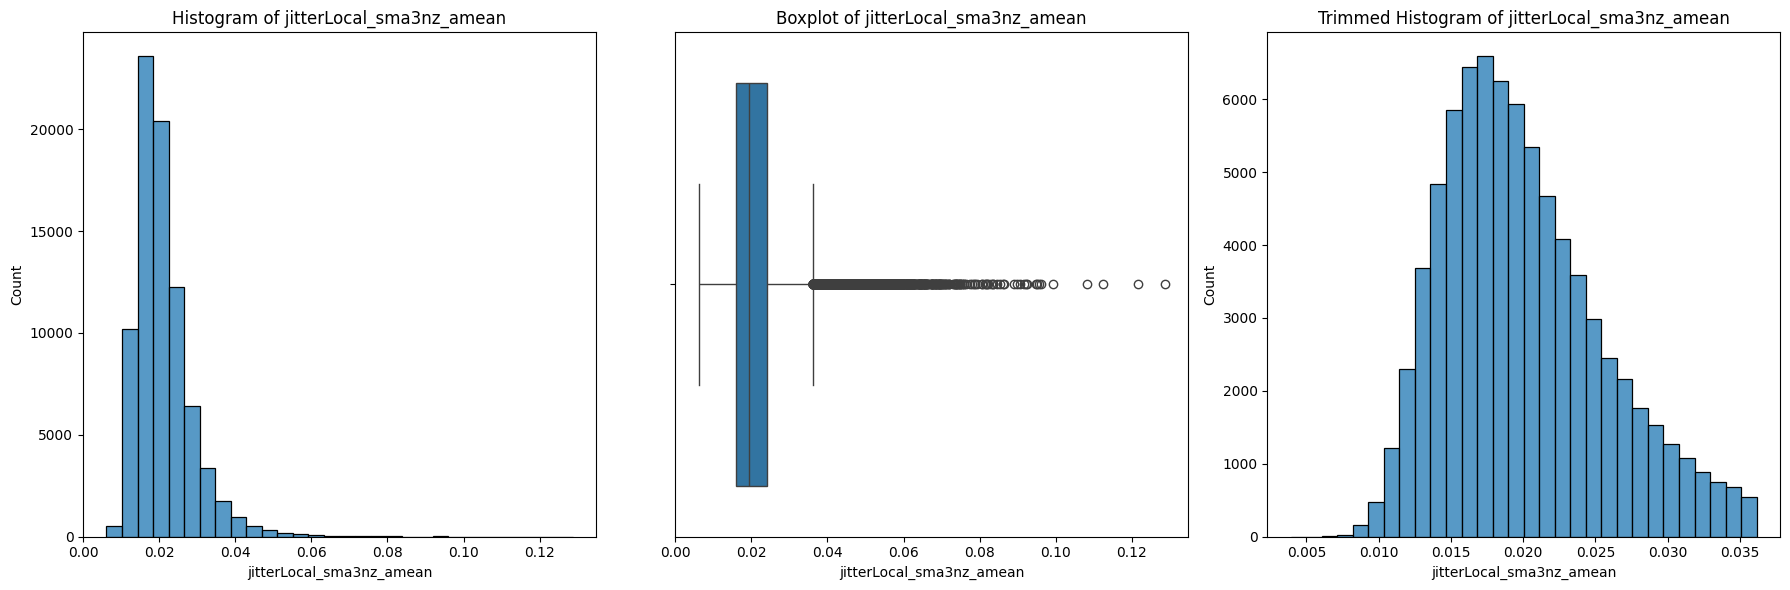

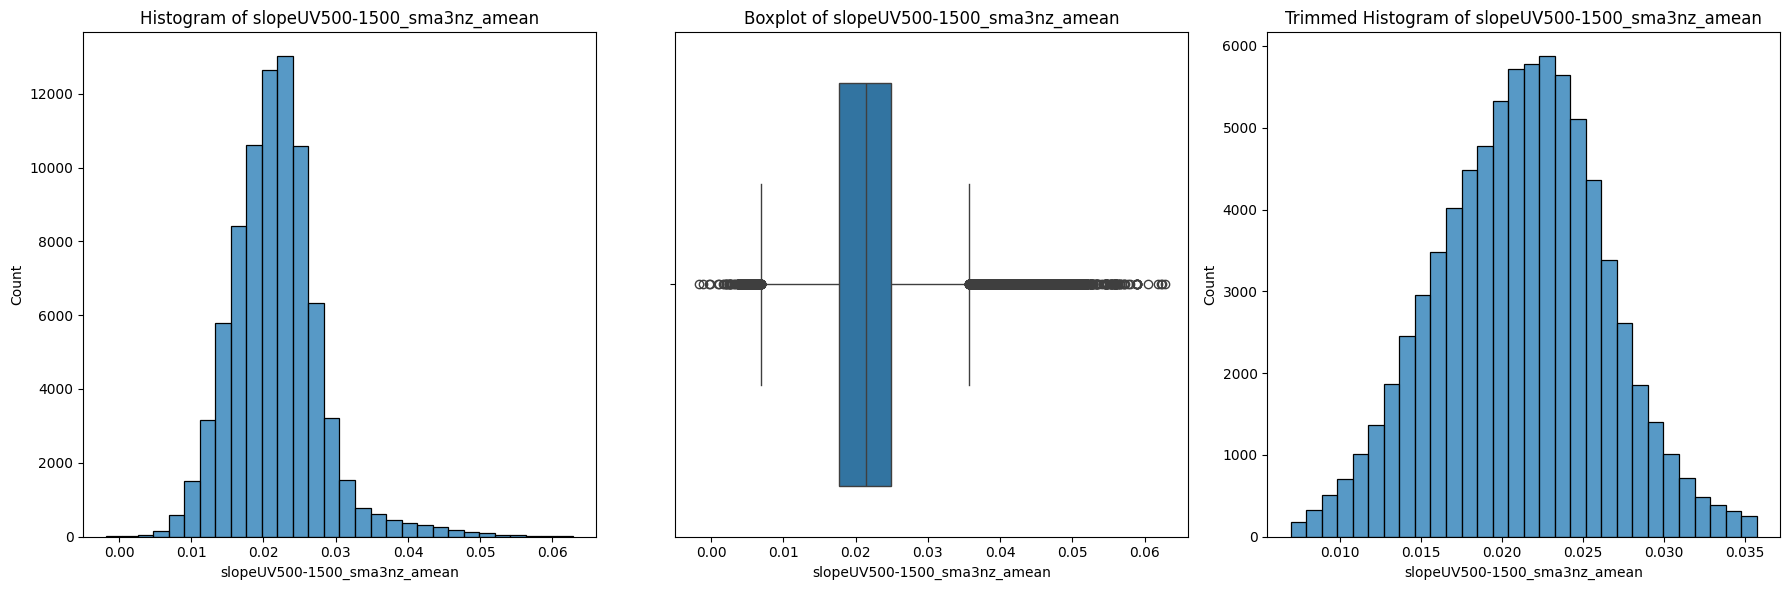

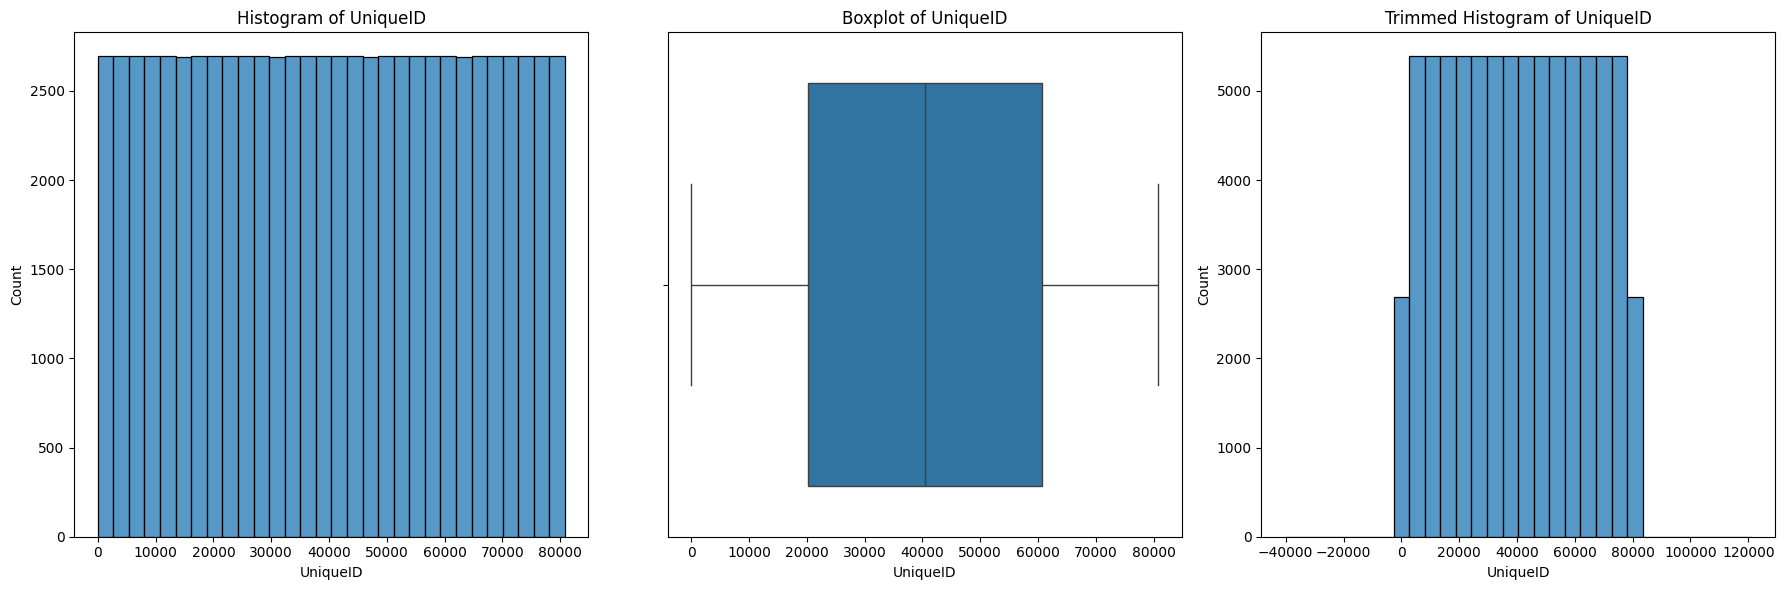

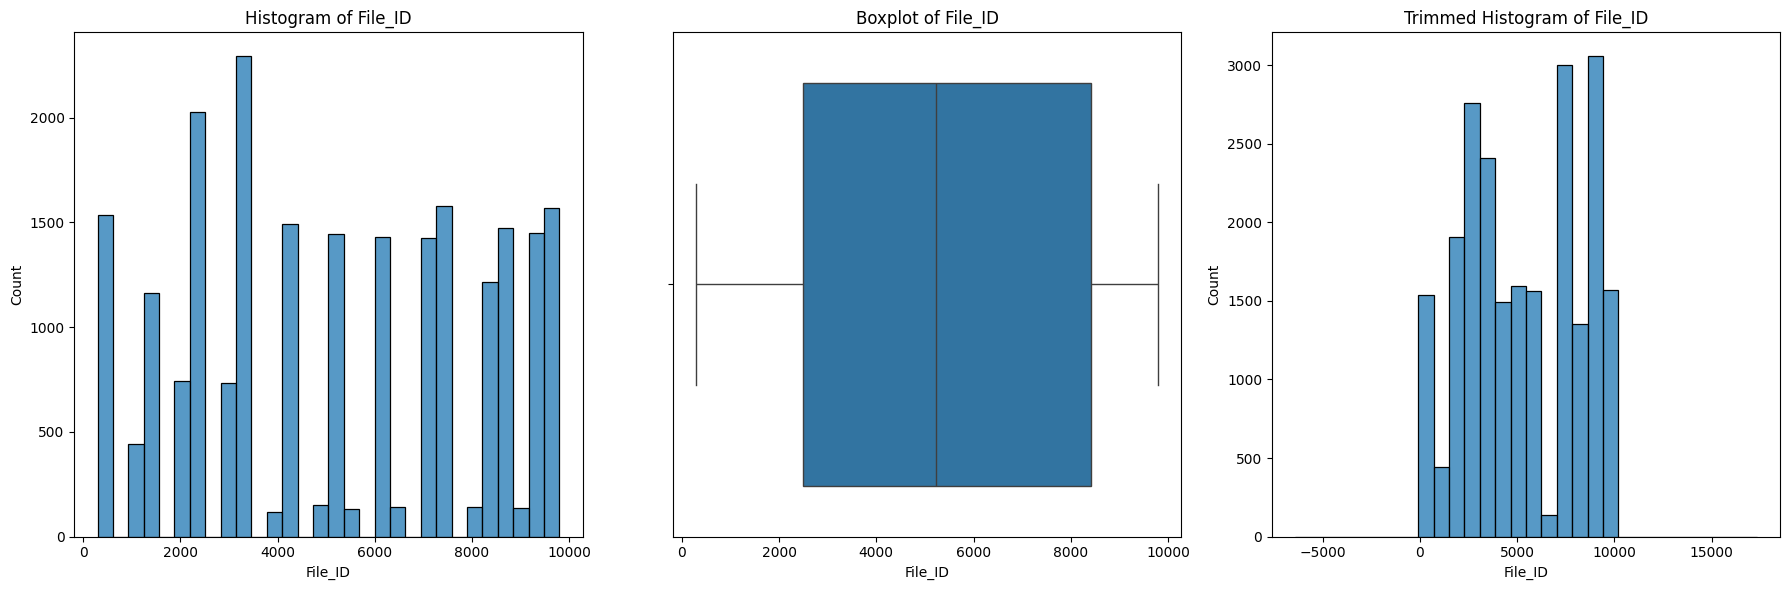

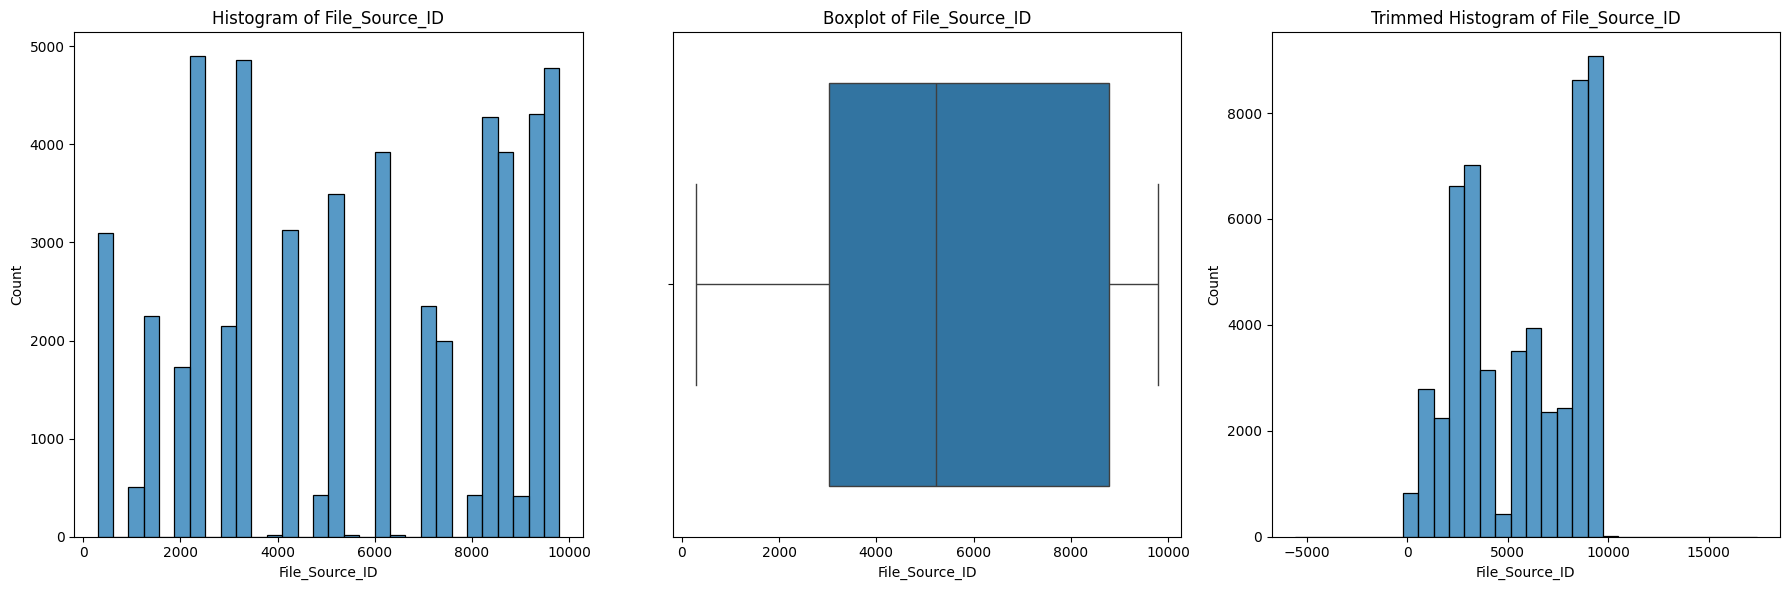

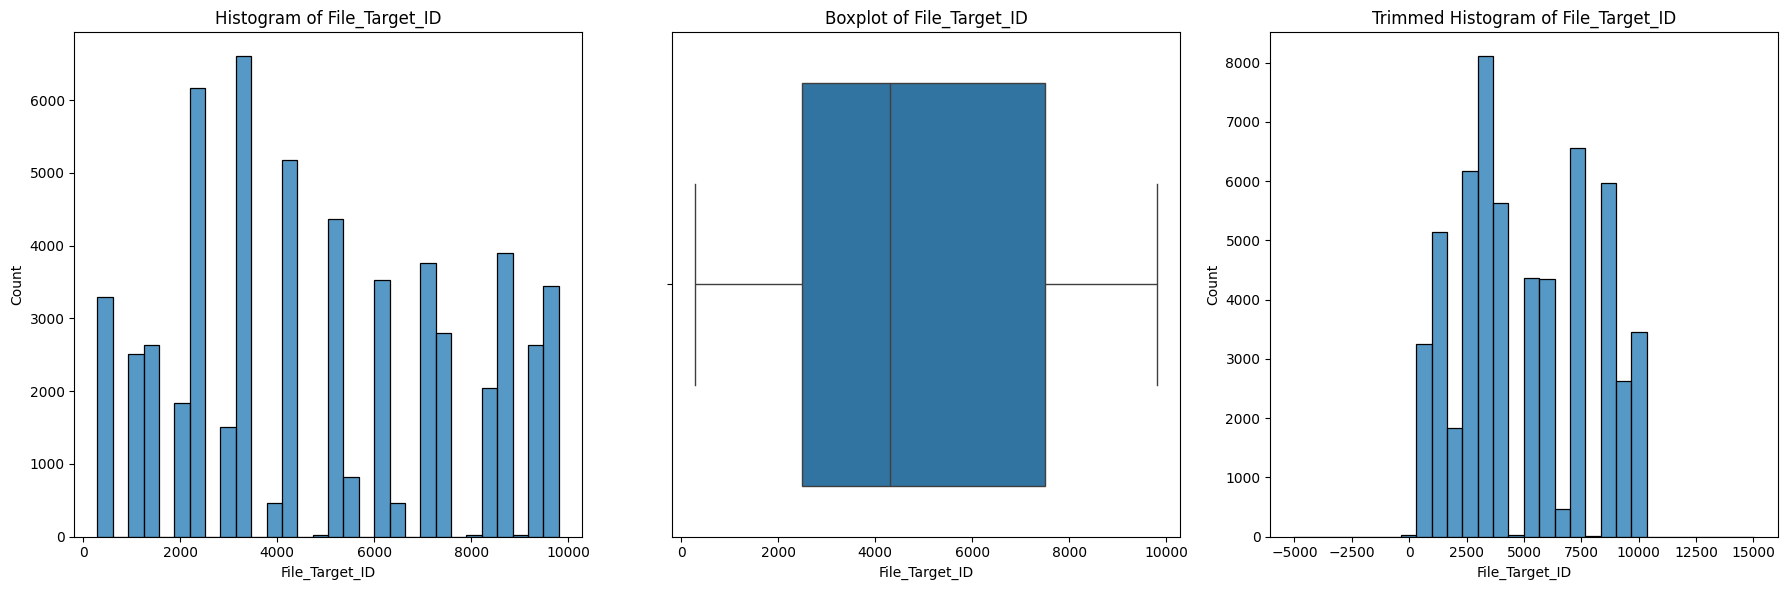

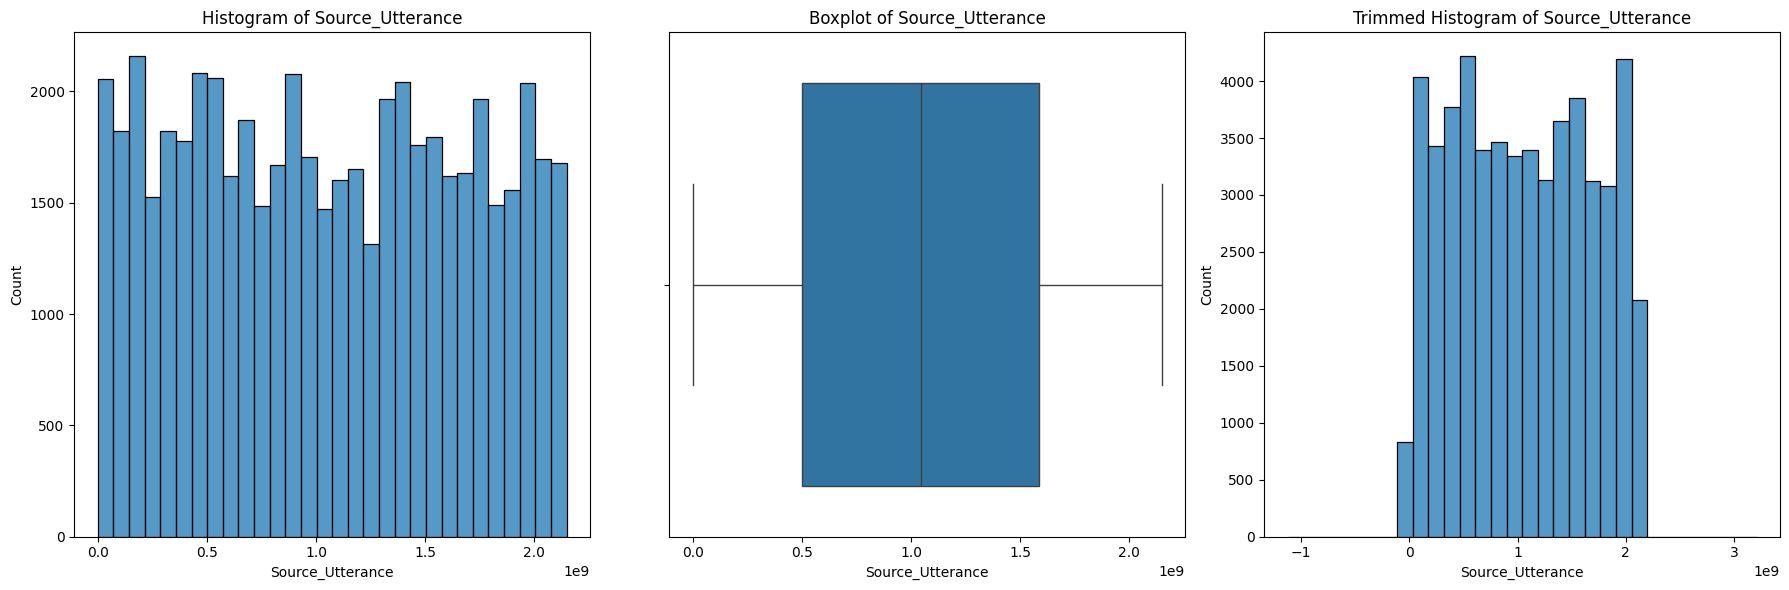

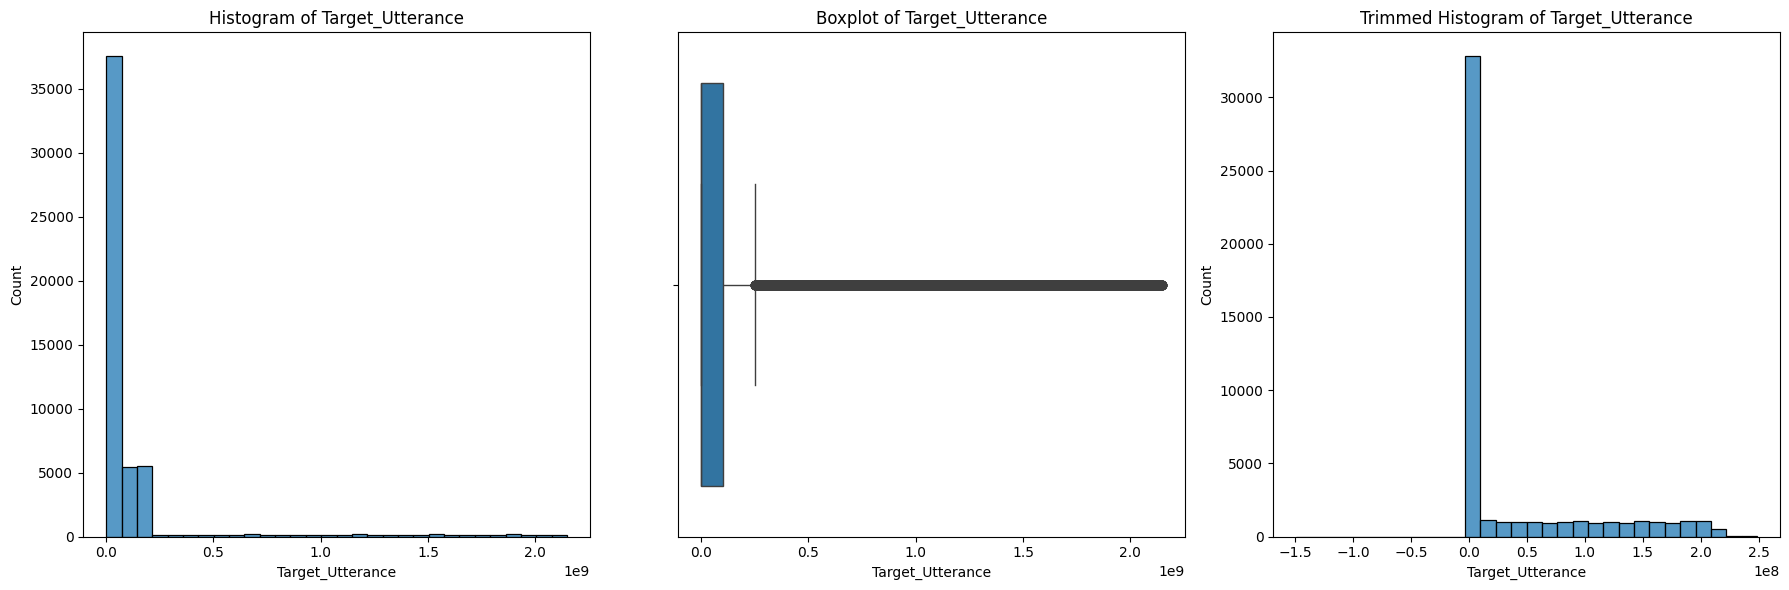

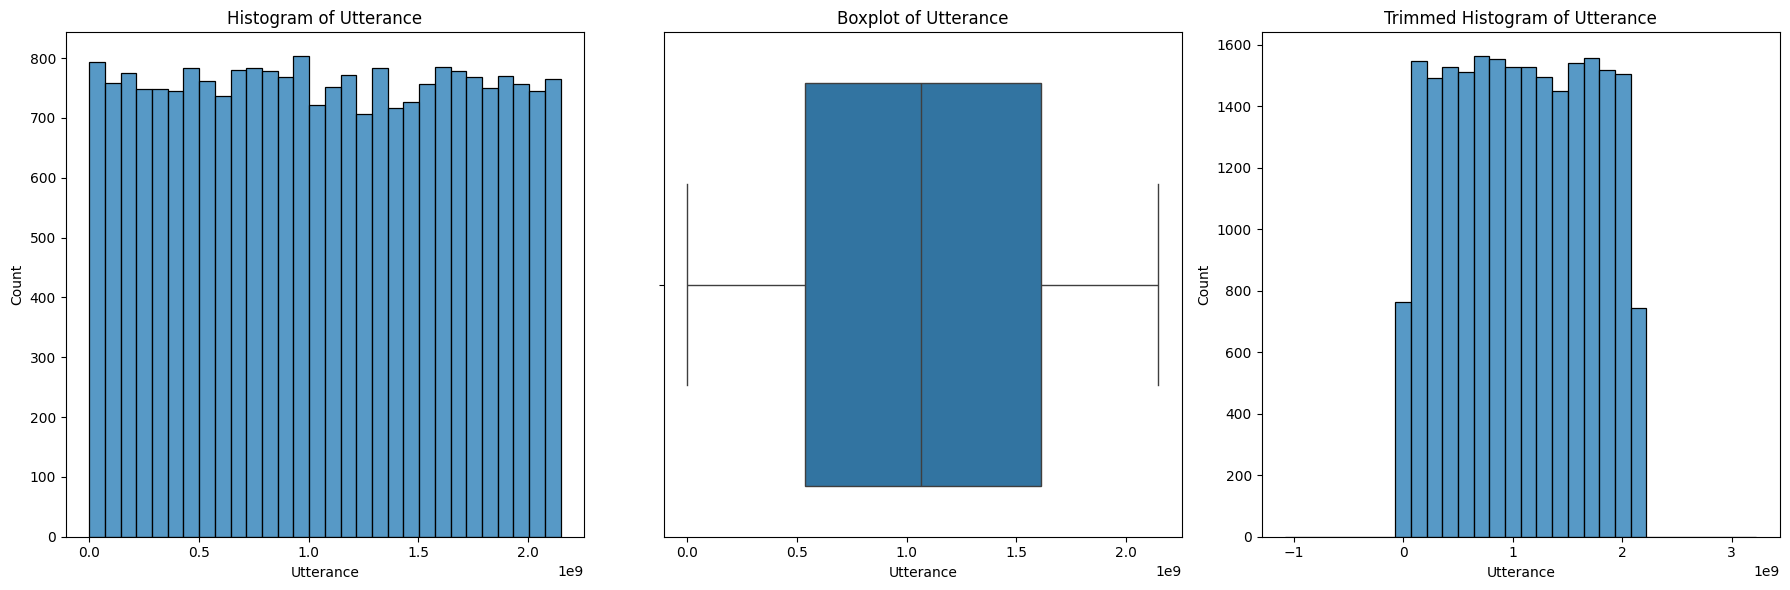

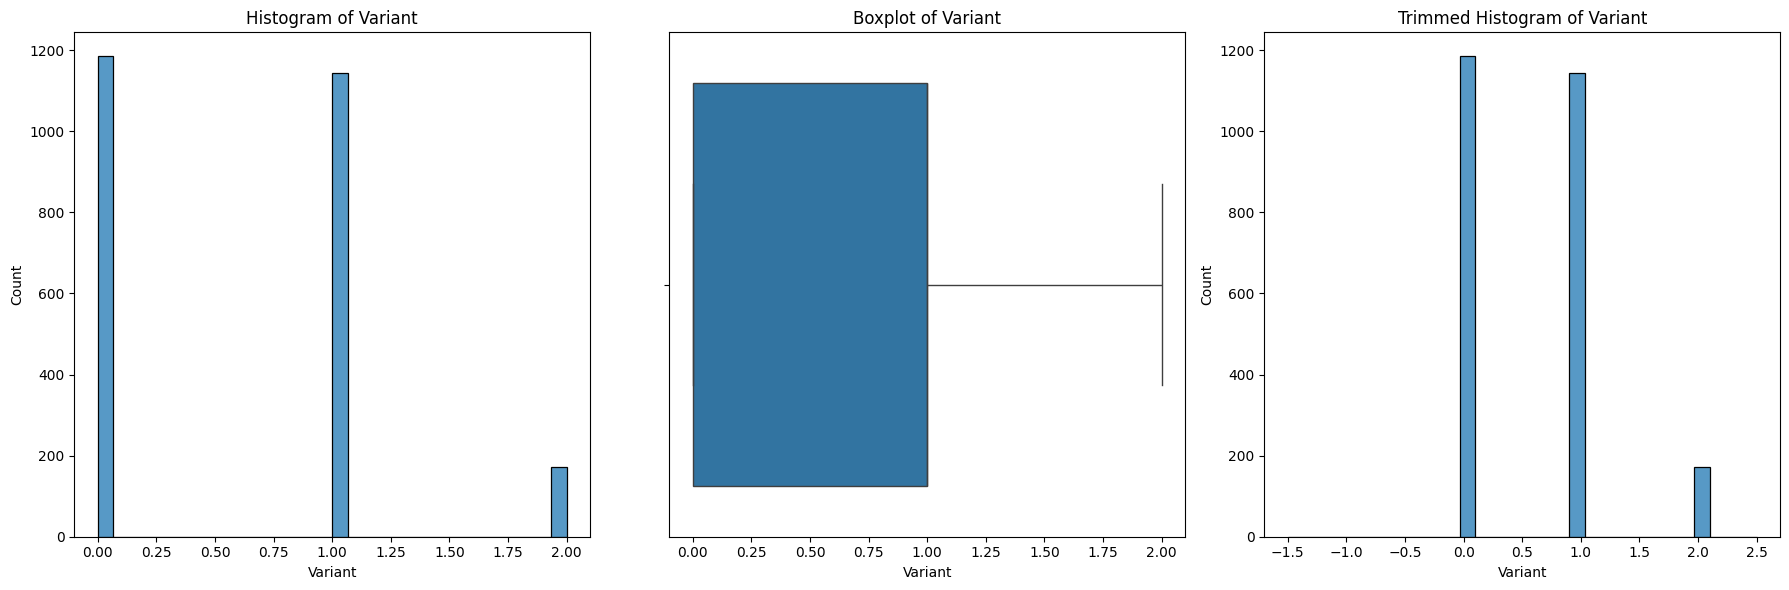

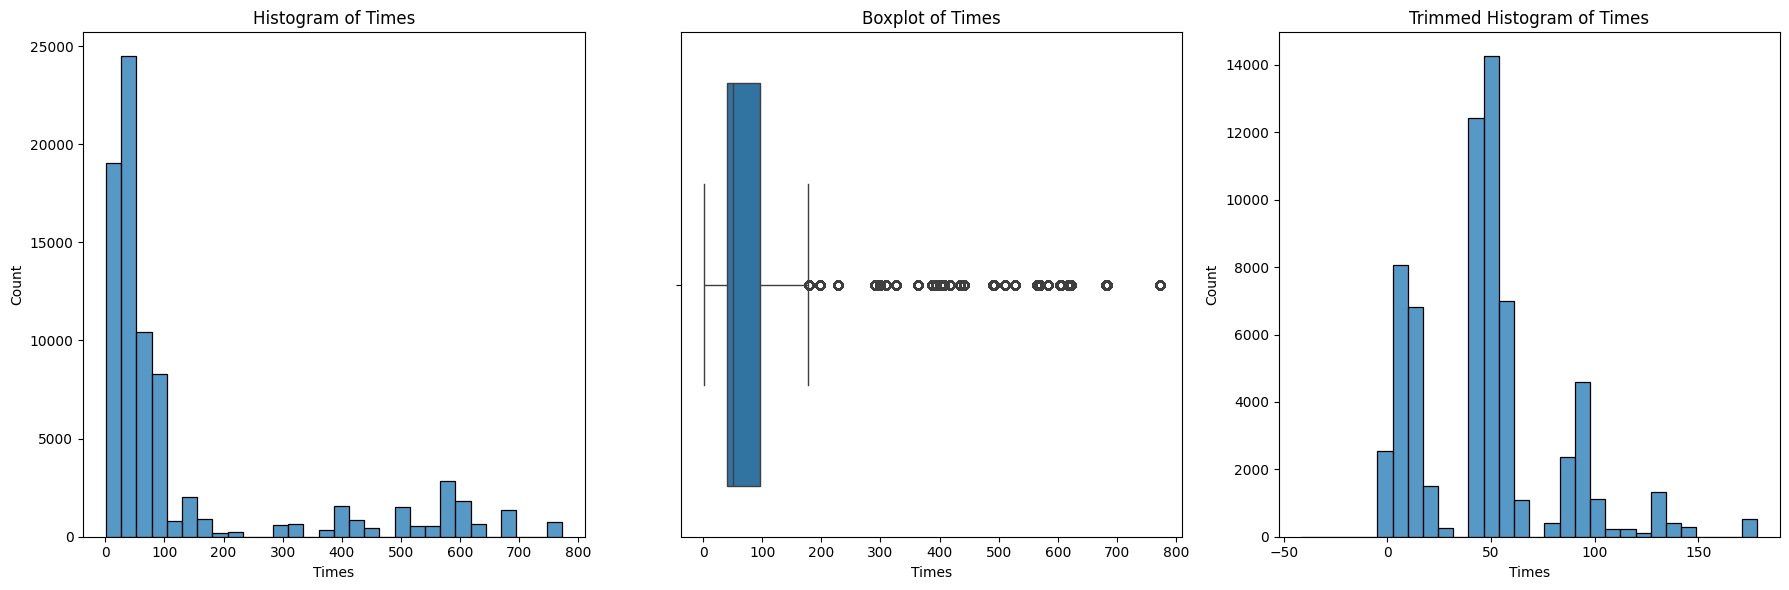

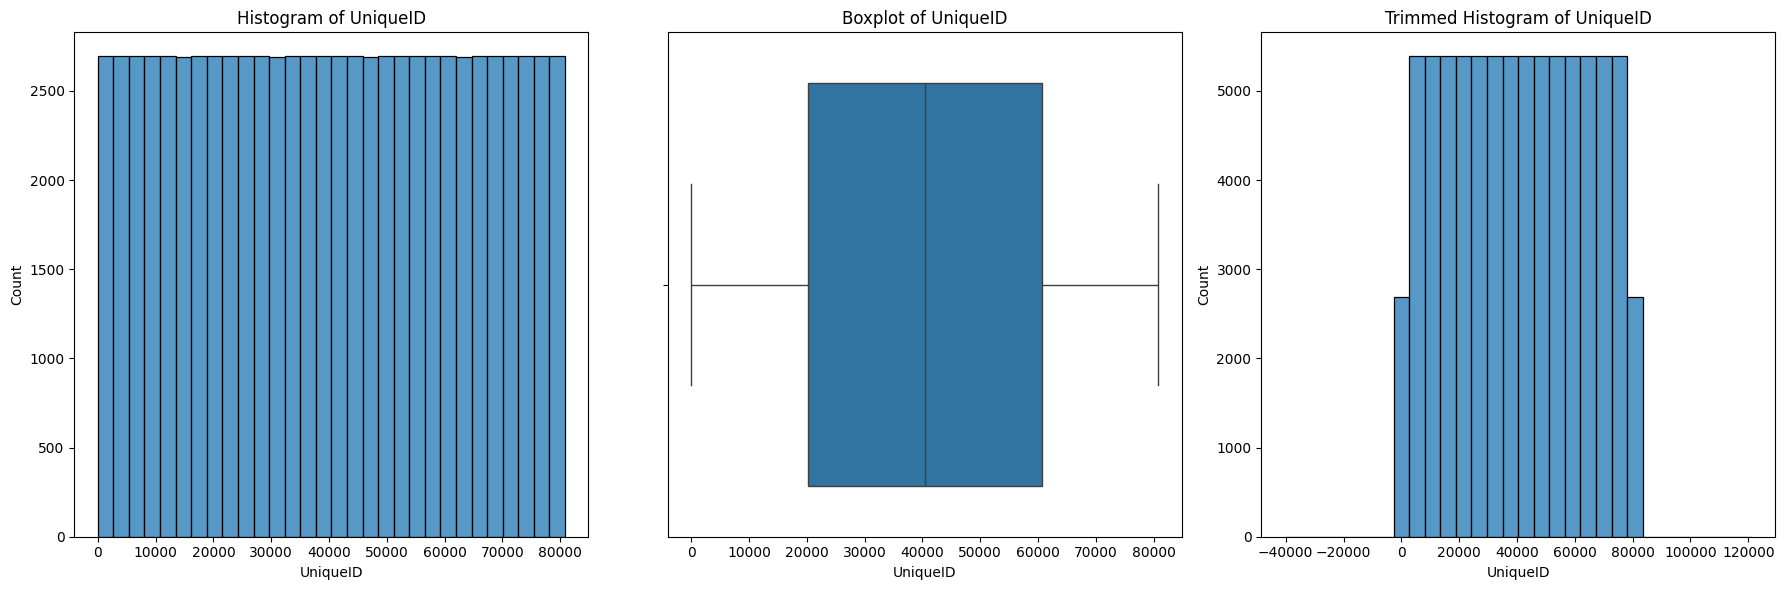

                                            Column          Mean  \
0                                       Unnamed: 0  40407.500000   
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope    113.951954   
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope     43.353231   
3   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1     43.353231   
4   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope     47.828090   
5                              loudness_sma3_amean      0.467605   
6                     spectralFlux_sma3_stddevNorm      1.446313   
7                                 mfcc1_sma3_amean     18.377609   
8                            mfcc1_sma3_stddevNorm      0.905121   
9                                 mfcc2_sma3_amean      9.697731   
10                           mfcc2_sma3_stddevNorm      4.774925   
11                                mfcc3_sma3_amean     12.513296   
12                           mfcc3_sma3_stddevNorm      1.519714   
13                        jitterLocal_sma3nz_ame

In [129]:
from scipy.stats import chi2_contingency

open_smile = pd.read_csv('smile_feature_selected.csv')

def analyze_dataframe(df):
    results = pd.DataFrame(columns=[
        'Column', 'Mean', 'Average', 'Minimum', 'Maximum',
        'Lower outliers', 'Upper outliers', 'Total outliers', 'Outliers(%)'
    ])
    
    numeric_cols = df.select_dtypes(include='number').columns  # Only numeric columns
    for col in numeric_cols:
        selected_column = df[col]
        Q1 = selected_column.quantile(0.25)
        Q3 = selected_column.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        
        # Plot histograms and boxplot
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        sns.histplot(selected_column, bins=30, edgecolor='black', ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')
        
        sns.boxplot(x=selected_column, ax=axes[1])
        axes[1].set_title(f'Boxplot of {col}')
        
        sns.histplot(selected_column, bins=30, edgecolor='black',
                     binrange=(lower_bound, upper_bound), ax=axes[2])
        axes[2].set_title(f'Trimmed Histogram of {col}')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate statistics
        mean = selected_column.mean()
        minimum = selected_column.min()
        maximum = selected_column.max()
        lower_outliers = selected_column[selected_column < lower_bound].count()
        upper_outliers = selected_column[selected_column > upper_bound].count()
        total_outliers = lower_outliers + upper_outliers
        
        # Append results
        new_row = pd.DataFrame([{
            'Column': col,
            'Mean': mean,
            'Average': mean,
            'Minimum': minimum,
            'Maximum': maximum,
            'Lower outliers': lower_outliers,
            'Upper outliers': upper_outliers,
            'Total outliers': total_outliers,
            'Outliers(%)': (total_outliers / len(selected_column)) * 100,
        }])
        results = pd.concat([results, new_row], ignore_index=True)
    
    return results

# Analyze the dataframes
results_smile = analyze_dataframe(open_smile)
resultrs_train = analyze_dataframe(full_csv)
print(results_smile)
print(resultrs_train)

mirem si realornot està balancejat

Realornot
1    8939
0    8865
Name: count, dtype: int64
Realornot
1    1200
0    1172
Name: count, dtype: int64


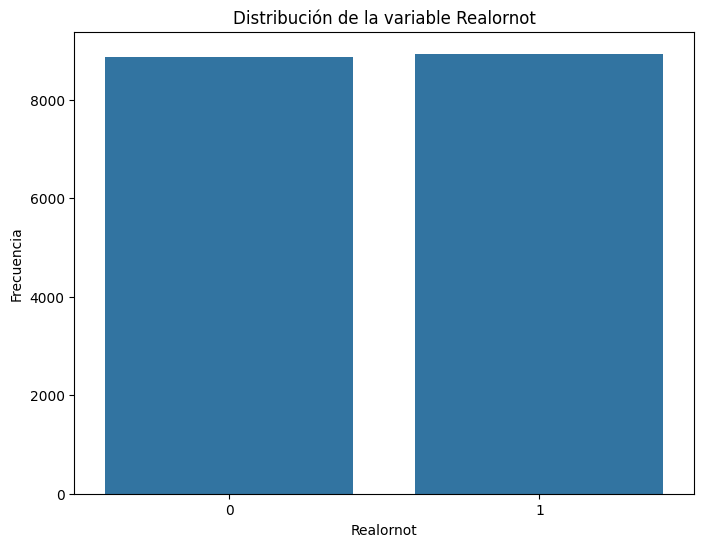

In [130]:
realornot_counts = train_csv['Realornot'].value_counts()
realornot_counts_t = test_csv['Realornot'].value_counts()

# Mostrar la frecuencia de cada valor
print(realornot_counts)
print(realornot_counts_t)

# Crear un gráfico de barras para visualizar la distribución de 'Realornot'
plt.figure(figsize=(8, 6))
sns.countplot(data=train_csv, x='Realornot')
plt.title('Distribución de la variable Realornot')
plt.xlabel('Realornot')
plt.ylabel('Frecuencia')
plt.show()

Eliminem variable duplicada

In [131]:
open_smile.drop(['F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1'], axis=1, inplace=True)

Fem el particionat del train en train/val

In [132]:
from sklearn.model_selection import train_test_split

# Particionar el conjunto de datos en entrenamiento y validación
training_set_p, validation_set = train_test_split(train_csv, test_size=0.2, random_state=42)

# Guardar las particiones en archivos CSV
training_set_p.to_csv('training_set_p.csv', index=False)
validation_set.to_csv('validation_set.csv', index=False)

data_explore(training_set_p)
data_explore(validation_set)

print(training_set_p.shape)
print(validation_set.shape)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (14243, 4)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 14243 entries, 11621 to 15795
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UniqueID       14243 non-null  int64 
 1   Realornot      14243 non-null  int64 
 2   Final_sex      14243 non-null  object
 3   Final_country  14243 non-null  object
dtypes: int64(2), object(2)
memory usage: 556.4+ KB
None
**********************************************************************
STATISTICAL ANALYSIS OF NUMERICAL DATA
**********************************************************************
             count          mean           std  min      25%      50%  \
UniqueID   14243.0  48290.097522  23559.313950  4.0  29973.5  56453.0   
Realornot  14243.0      0.501088      0.500016  0.0      0.0 

tal i com hem deixat el train no tenim missings, en el open smile tampoc hi ha missings. Tot i així tractarem els valors negatius com a missings i realitzarem una imputació per la medina. Eliminem els outliers més gran per poder observar millor les distribucions

Calcular els outliers de les variables

In [133]:
def calculate_outliers_percentage(df):
    outliers_info = pd.DataFrame(columns=['Variable', 'Lower Bound', 'Upper Bound', 'Total Outliers', 'Outliers (%)'])
    
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        lower_outliers = df[df[col] < lower_bound].shape[0]
        upper_outliers = df[df[col] > upper_bound].shape[0]
        total_outliers = lower_outliers + upper_outliers
        outliers_percentage = (total_outliers / df.shape[0]) * 100

        outliers_info = pd.concat([outliers_info, pd.DataFrame([{
            'Variable': col,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Total Outliers': total_outliers,
            'Outliers (%)': outliers_percentage
        }])], ignore_index=True)
    
    return outliers_info

outliers_info_t = calculate_outliers_percentage(open_smile)
print(outliers_info_t)

                                          Variable   Lower Bound  \
0                                       Unnamed: 0 -40407.500000   
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   -150.505598   
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    -12.926707   
3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope    -21.380187   
4                              loudness_sma3_amean     -0.069143   
5                     spectralFlux_sma3_stddevNorm      0.474834   
6                                 mfcc1_sma3_amean      7.539380   
7                            mfcc1_sma3_stddevNorm      0.325451   
8                                 mfcc2_sma3_amean     -3.117738   
9                            mfcc2_sma3_stddevNorm     -0.714666   
10                                mfcc3_sma3_amean      0.779751   
11                           mfcc3_sma3_stddevNorm     -0.183913   
12                        jitterLocal_sma3nz_amean      0.003913   
13                    slopeUV500-1500_sma3nz_ame

Agafem un dataframe copiat sense el 1% per dalt i per baix per poder veure bé la normalitat de les varibales

In [134]:
# Crear una copia del dataset
smile_imputed = open_smile.copy()

# Excluir las columnas 'Unnamed: 0', 'Realornot' y 'UniqueID'
columns_to_exclude = ['Unnamed: 0', 'Realornot', 'UniqueID']
numeric_columns = smile_imputed.select_dtypes(include=[np.number]).drop(columns=columns_to_exclude, errors='ignore')

# Reemplazar valores negativos y el 1% de valores más grandes y más bajos por NaN
for col in numeric_columns.columns:
    lower_threshold = smile_imputed[col].quantile(0.01)
    upper_threshold = smile_imputed[col].quantile(0.99)
    smile_imputed = smile_imputed[(smile_imputed[col] > lower_threshold) & (smile_imputed[col] < upper_threshold)]

outliers_info_imputed = calculate_outliers_percentage(smile_imputed)
print(outliers_info_imputed)
print(smile_imputed.shape)
data_explore(smile_imputed)

                                          Variable   Lower Bound  \
0                                       Unnamed: 0 -38403.000000   
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   -142.479249   
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    -10.008653   
3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope    -17.109282   
4                              loudness_sma3_amean     -0.028370   
5                     spectralFlux_sma3_stddevNorm      0.565939   
6                                 mfcc1_sma3_amean      8.552182   
7                            mfcc1_sma3_stddevNorm      0.364258   
8                                 mfcc2_sma3_amean     -1.490202   
9                            mfcc2_sma3_stddevNorm     -0.565775   
10                                mfcc3_sma3_amean      2.161252   
11                           mfcc3_sma3_stddevNorm     -0.056203   
12                        jitterLocal_sma3nz_amean      0.004437   
13                    slopeUV500-1500_sma3nz_ame

Mirem les distribucions de les variables númeriques de opensmile per determinar si son gaussianes

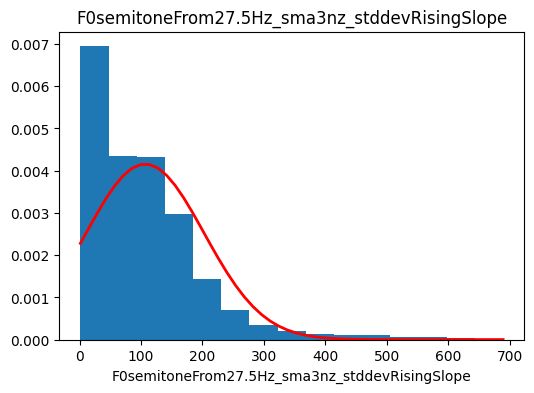

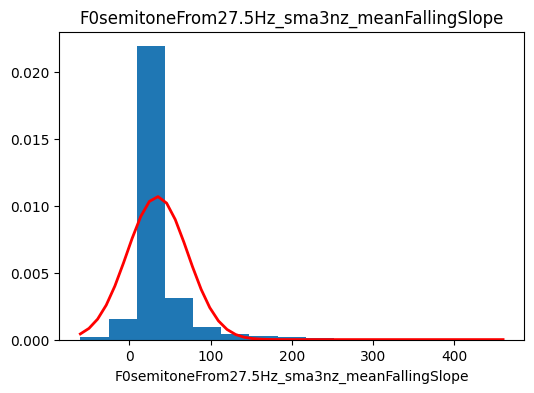

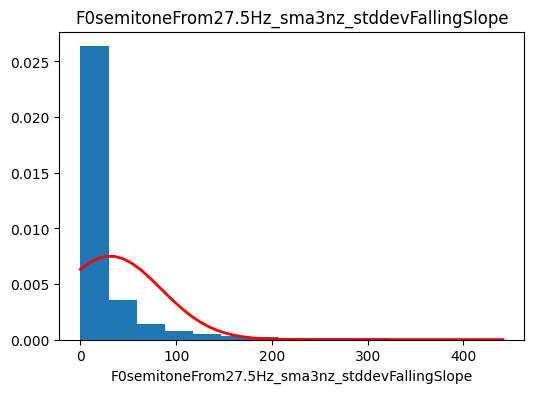

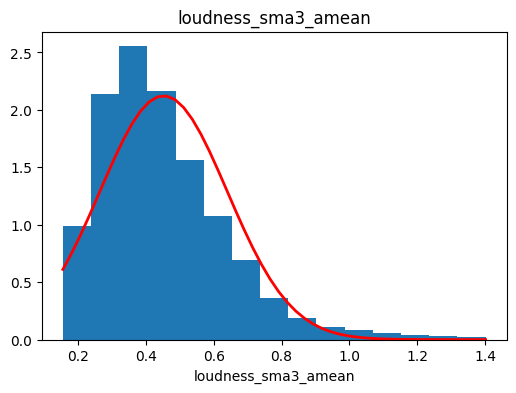

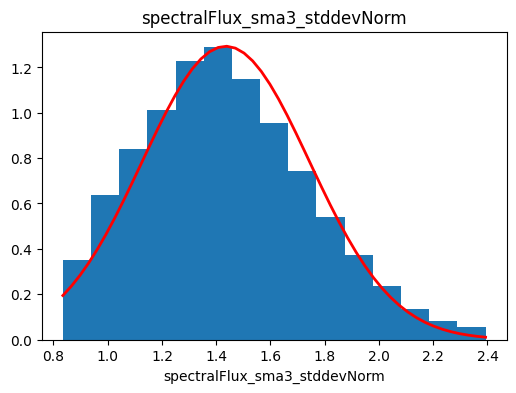

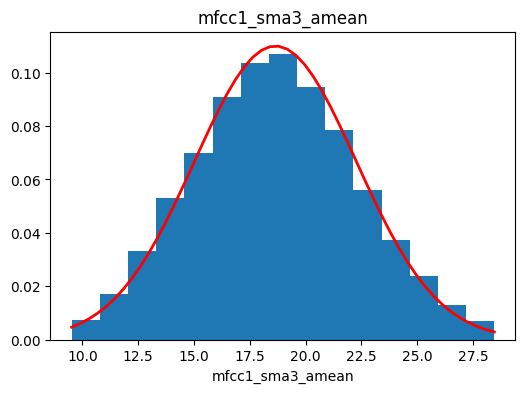

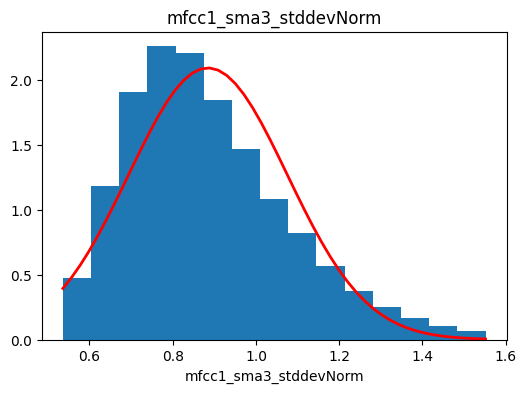

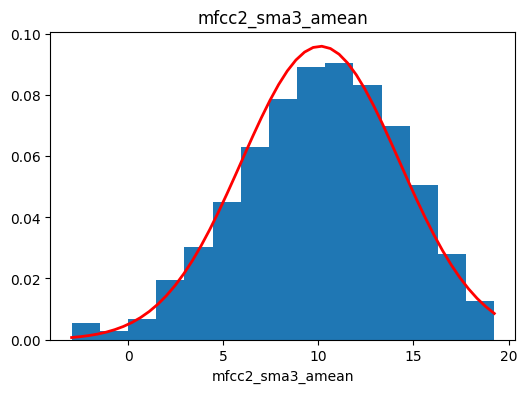

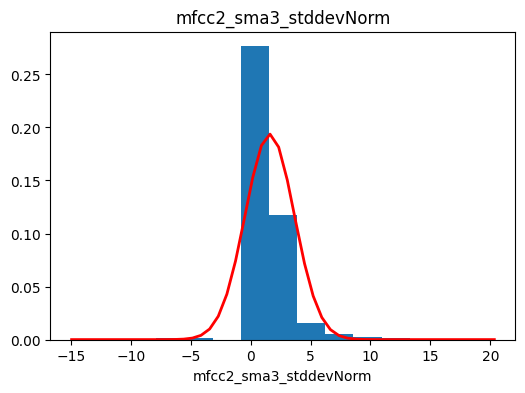

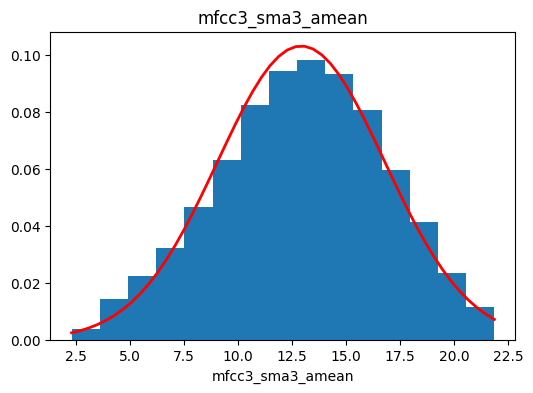

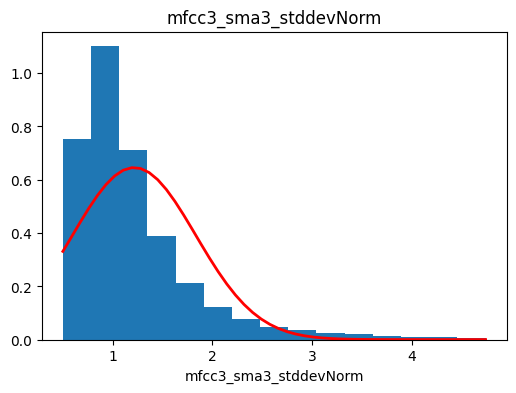

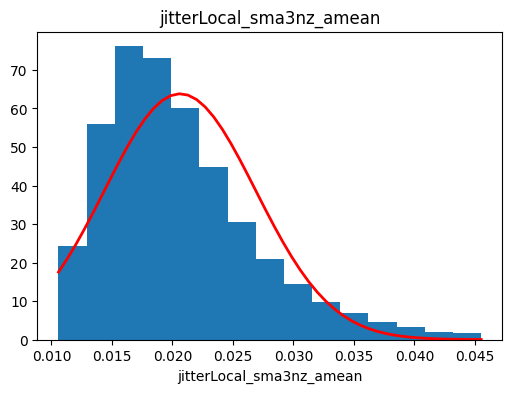

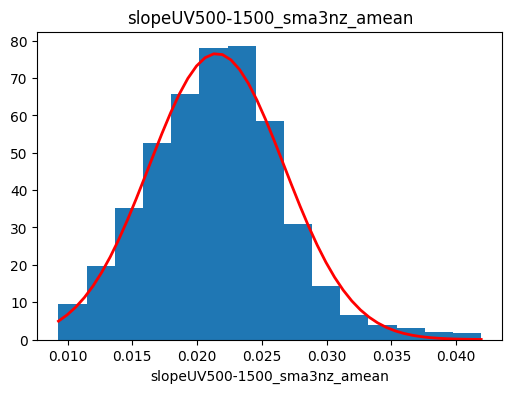

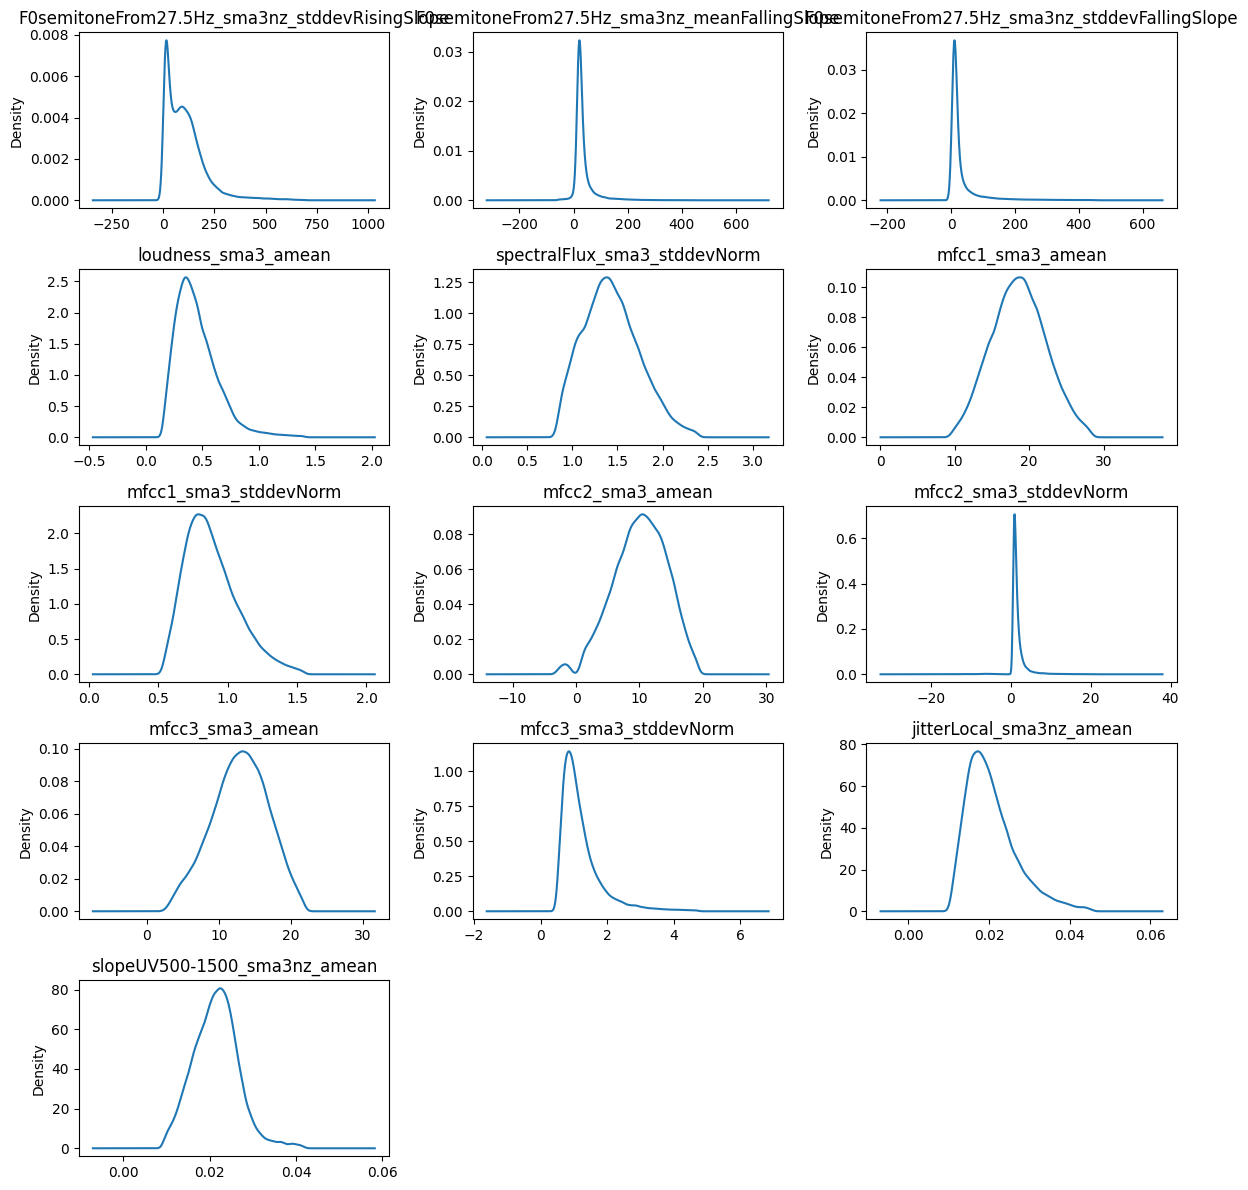

In [135]:
numerical_columns = smile_imputed.select_dtypes(include=[np.number]).columns
columns_to_impute = [col for col in numerical_columns if col not in columns_to_exclude]

for col in columns_to_impute:
    sigma = smile_imputed[col].std()
    mu = smile_imputed[col].mean()
    
    fig, ax = plt.subplots(figsize=(6,4))
    count, bins, ignored = plt.hist(smile_imputed[col], 15, density=True)
    dbins = np.linspace(bins[0], bins[-1])
    plt.title(col)
    ax.set_xlabel(col)
    plt.plot(dbins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (dbins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
    plt.show()

# Plot KDE for All Numerical Variables
fig = plt.figure(figsize=(12,12))

# Adjust the number of rows and columns to fit all numerical columns
num_cols = len(columns_to_impute)
num_rows = (num_cols // 3) + (1 if num_cols % 3 != 0 else 0)

for i, col in enumerate(columns_to_impute):
    ax = fig.add_subplot(num_rows, 3, i+1)
    smile_imputed[col].plot.kde(ax=ax)
    plt.title(col)

fig.tight_layout()
plt.show()

Ho visualitzem

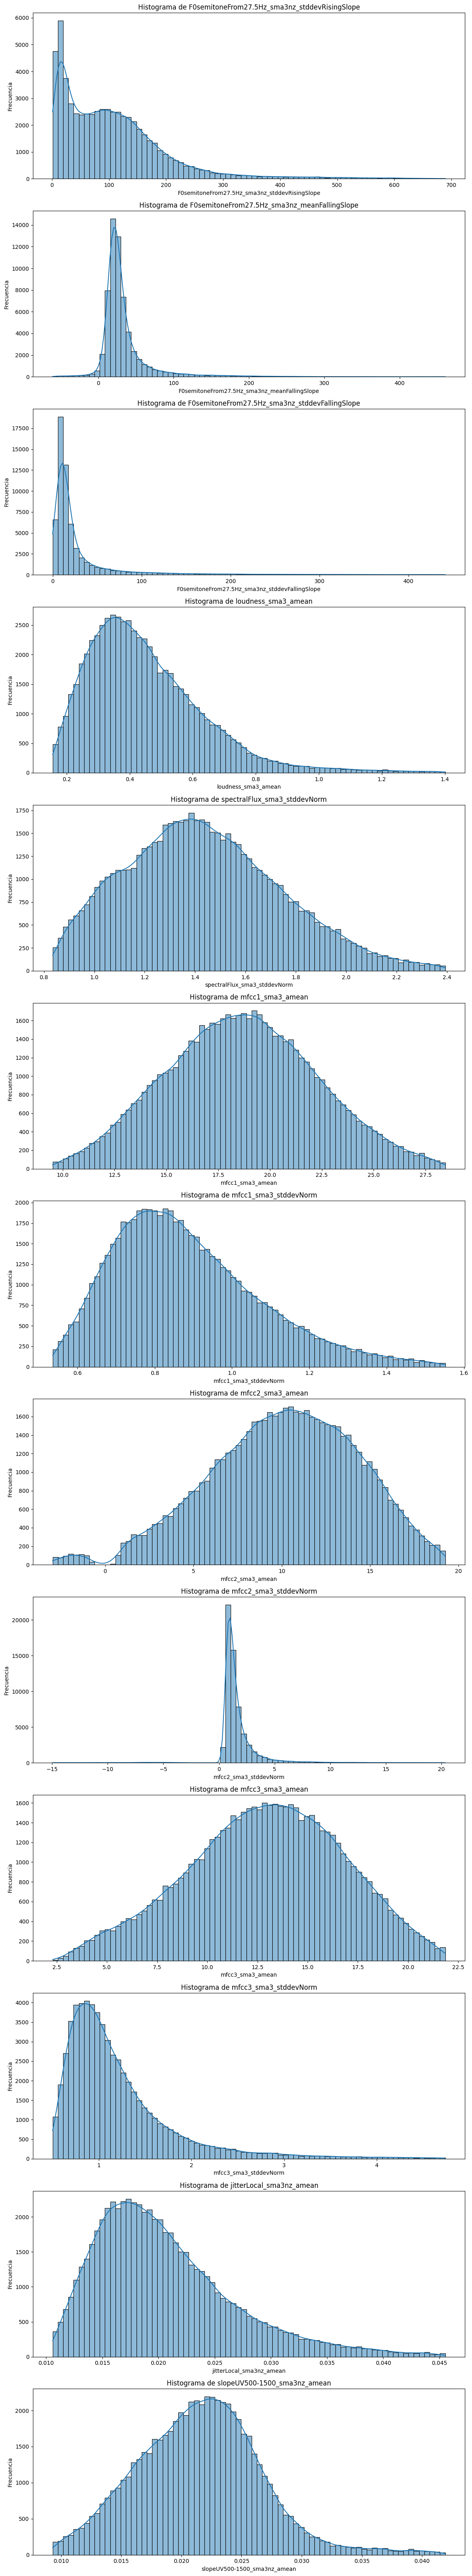

In [136]:
def plot_histograms(df):    
    # Seleccionar las columnas numéricas
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    columns_to_impute = [col for col in numerical_columns if col not in columns_to_exclude]
    
    # Crear subplots
    fig, axes = plt.subplots(len(columns_to_impute), 1, figsize=(12, 5 * len(columns_to_impute)))
    
    # Generar histogramas para cada variable numérica
    for i, col in enumerate(columns_to_impute):
        sns.histplot(df[col], bins=75, kde=True, ax=axes[i])
        axes[i].set_title(f'Histograma de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

plot_histograms(smile_imputed)

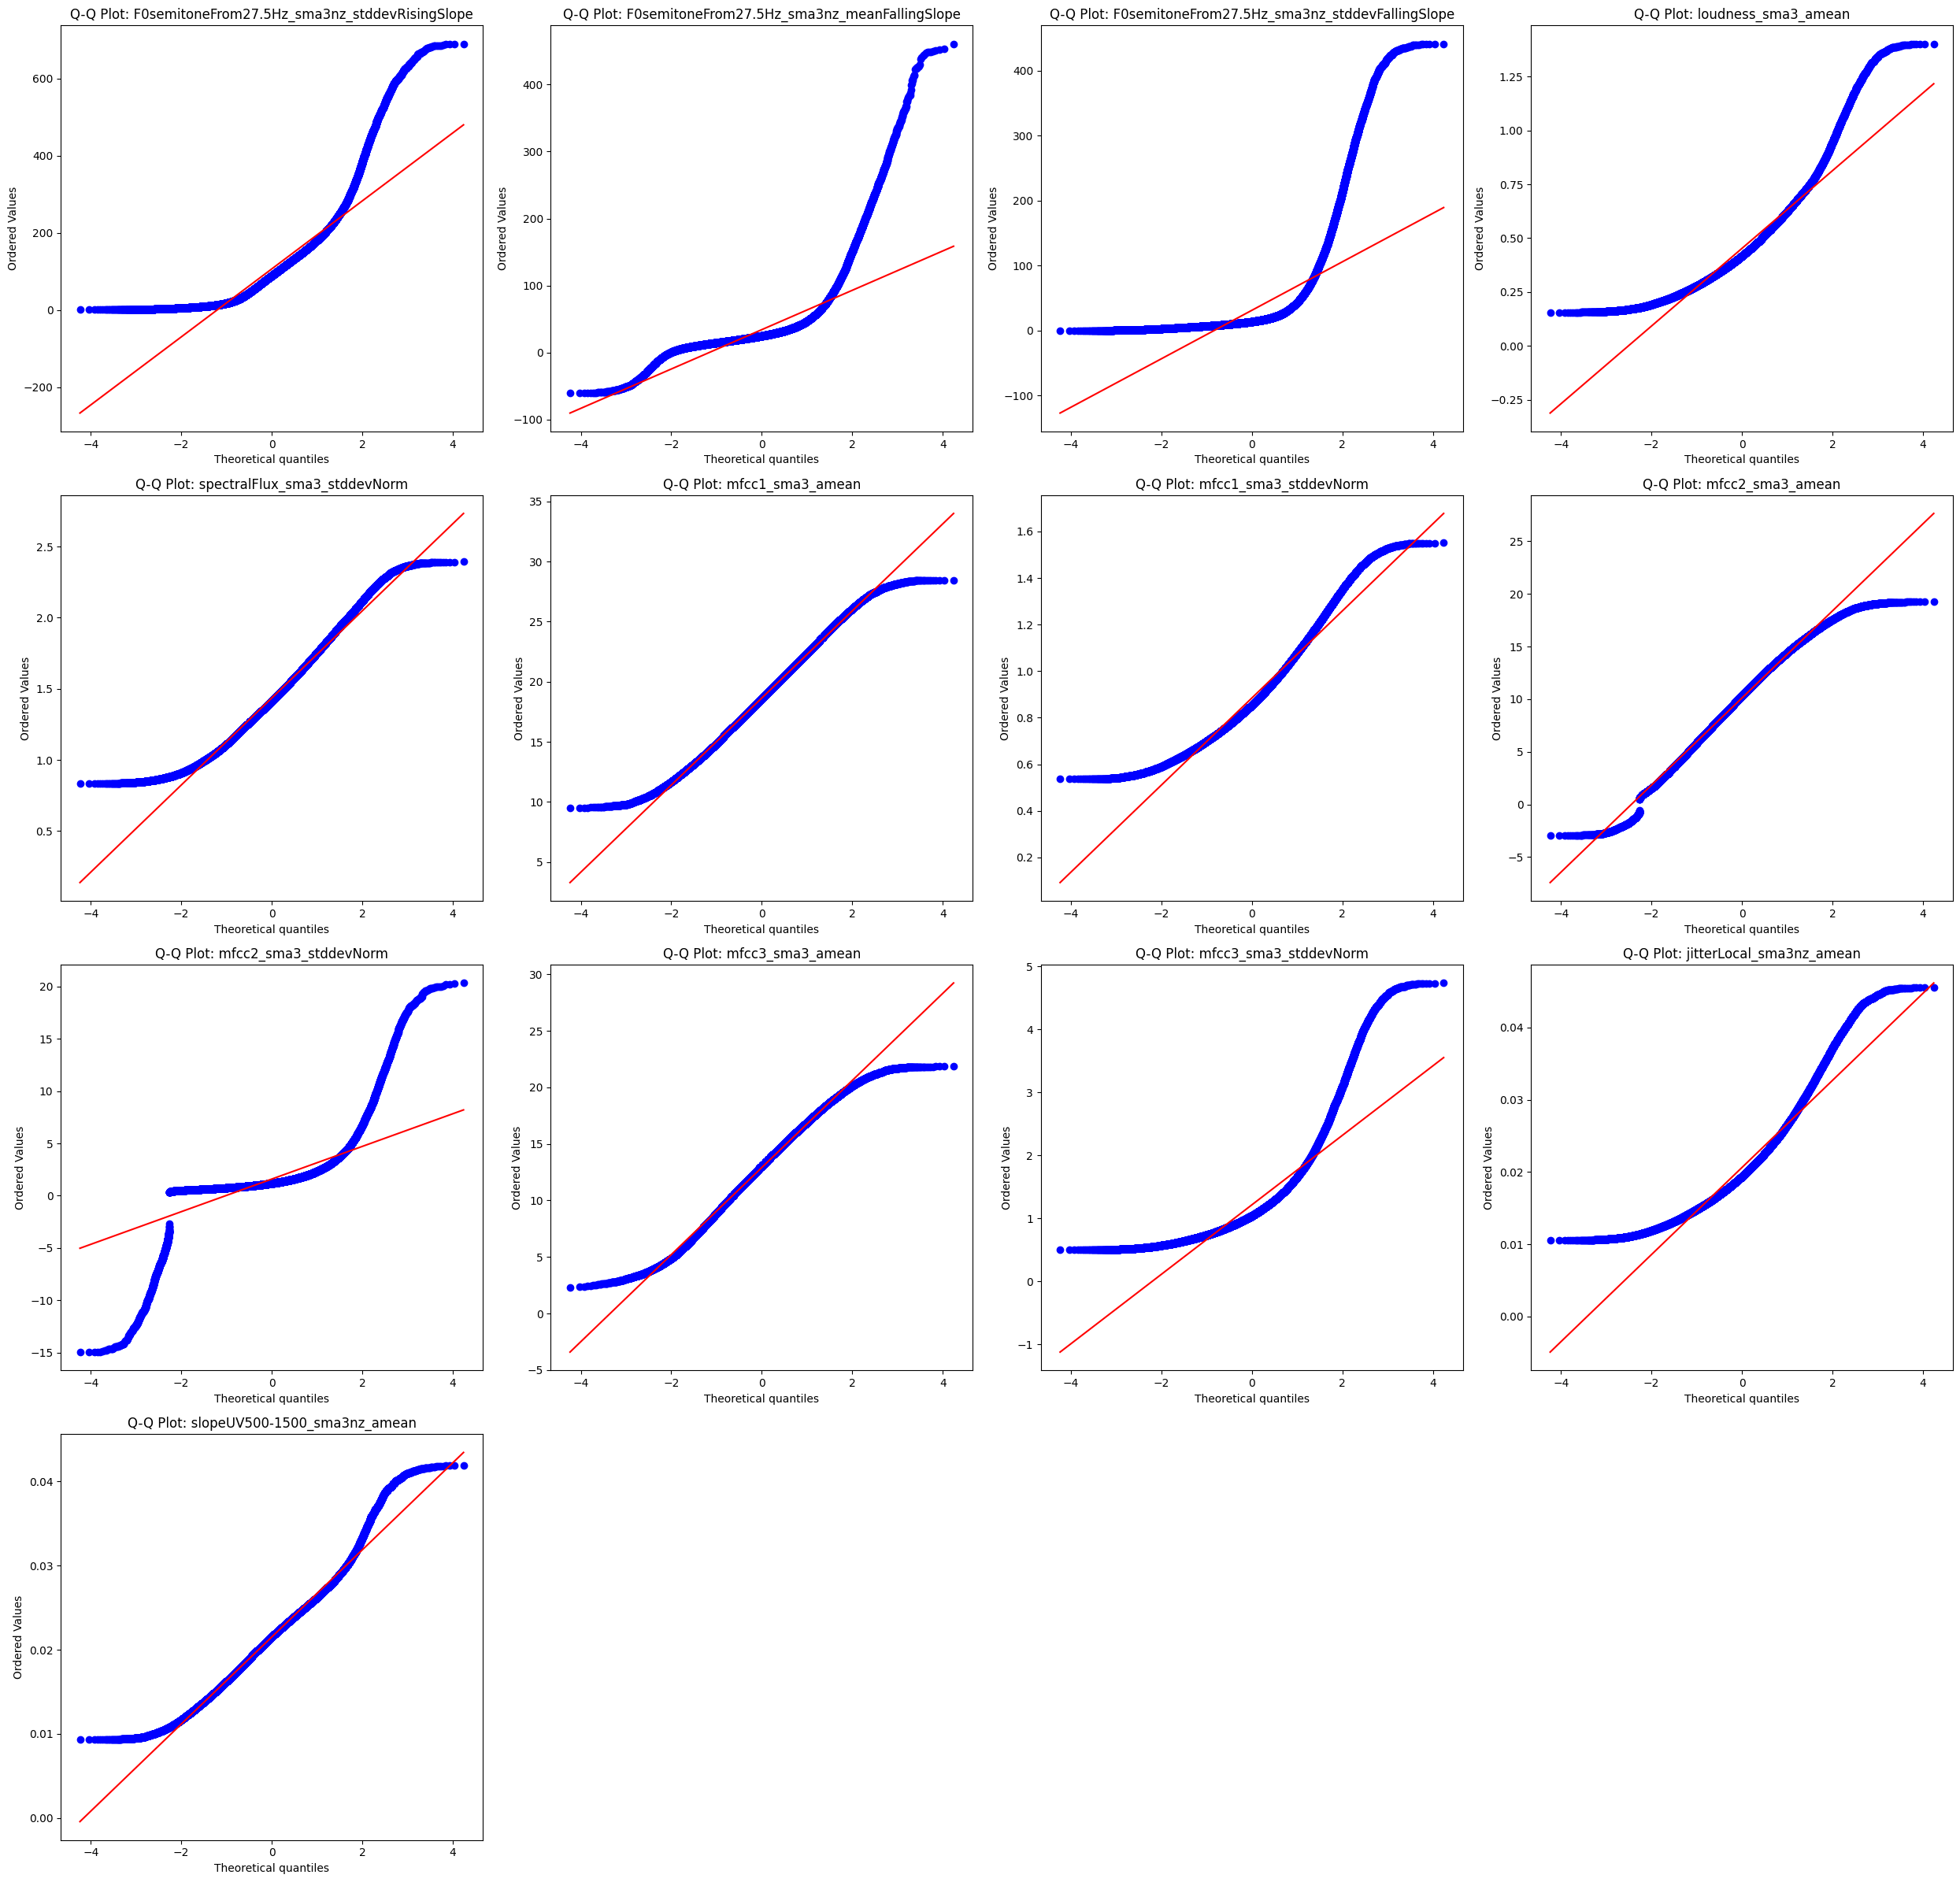

In [137]:
import scipy.stats as stats

def qq_plot(df):
    # Assuming open_smile is your DataFrame and it is already loaded
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    columns_to_impute = [col for col in numerical_columns if col not in columns_to_exclude]

    num_vars = len(columns_to_impute)
    rows = (num_vars + 3) // 4 
    fig, axes = plt.subplots(rows, 4, figsize=(25, rows * 6))

    axes = axes.flatten()

    for i, var in enumerate(columns_to_impute):
        stats.probplot(df[var], dist="norm", plot=axes[i])
        axes[i].set_title(f"Q-Q Plot: {var}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

qq_plot(smile_imputed)

Fem una transformació logaritmica per les variables que no tenen una distribució gaussiana

In [138]:
# Aplicar transformación logarítmica a las variables especificadas
variables_to_transform = [
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
    'mfcc2_sma3_stddevNorm',
    'mfcc3_sma3_stddevNorm'
]

for var in variables_to_transform:
    open_smile[var] = np.log(open_smile[var])

outliers_info = calculate_outliers_percentage(open_smile)
print(outliers_info)
data_explore(open_smile)

                                          Variable   Lower Bound  \
0                                       Unnamed: 0 -40407.500000   
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope      0.861813   
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    -12.926707   
3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope      0.355700   
4                              loudness_sma3_amean     -0.069143   
5                     spectralFlux_sma3_stddevNorm      0.474834   
6                                 mfcc1_sma3_amean      7.539380   
7                            mfcc1_sma3_stddevNorm      0.325451   
8                                 mfcc2_sma3_amean     -3.117738   
9                            mfcc2_sma3_stddevNorm     -1.342584   
10                                mfcc3_sma3_amean      0.779751   
11                           mfcc3_sma3_stddevNorm     -1.098945   
12                        jitterLocal_sma3nz_amean      0.003913   
13                    slopeUV500-1500_sma3nz_ame

Fem IQR finalment per marcar outliers com a NA

In [139]:
def filter_outliers_iqr(df):
    filtered_df = df.copy()
    for col in df.select_dtypes(include='number').columns:
        if col not in ['Unnamed: 0', 'UniqueID']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            filtered_df[col] = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound), other=pd.NA)
    return filtered_df

# Apply the function to mark outliers as NA
smile = filter_outliers_iqr(open_smile)

# Display the shape of the new dataset and the outliers information
outliers_info = calculate_outliers_percentage(smile)
print(f"Original dataset shape: {open_smile.shape}")
print(f"Filtered dataset shape: {smile.shape}")
print(outliers_info)

Original dataset shape: (80816, 15)
Filtered dataset shape: (80816, 15)
                                          Variable   Lower Bound  \
0                                       Unnamed: 0 -40407.500000   
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope      1.022321   
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope     -5.381728   
3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope      0.626952   
4                              loudness_sma3_amean     -0.049841   
5                     spectralFlux_sma3_stddevNorm      0.483817   
6                                 mfcc1_sma3_amean      7.647177   
7                            mfcc1_sma3_stddevNorm      0.345062   
8                                 mfcc2_sma3_amean     -2.852706   
9                            mfcc2_sma3_stddevNorm     -1.269240   
10                                mfcc3_sma3_amean      1.035767   
11                           mfcc3_sma3_stddevNorm     -1.059208   
12                        jitterLocal_sma3nz

Imputem els NA utilitzant KNN

In [140]:
from sklearn.impute import KNNImputer

# Create copy and define columns to exclude
columns_to_exclude = ['Unnamed: 0', 'UniqueID']

# Get numeric columns excluding specified ones
numeric_columns = smile.select_dtypes(include=['int64', 'float64']).columns
columns_to_impute = [col for col in numeric_columns if col not in columns_to_exclude]

# Initialize and fit KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)
smile[columns_to_impute] = knn_imputer.fit_transform(smile[columns_to_impute])

# Verify imputation results
print("Number of remaining NaN values:", smile[columns_to_impute].isna().sum().sum())

# Optional: Display data exploration
data_explore(smile)

smile.to_csv('smile_final.csv', index=False)

Number of remaining NaN values: 0
DATA EXPLORATION
**********************************************************************
Shape of dataset :  (80816, 15)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80816 entries, 0 to 80815
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      80816 non-null  int64  
 1   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   80816 non-null  float64
 2   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    80816 non-null  float64
 3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  80816 non-null  float64
 4   loudness_sma3_amean                             80816 non-null  float64
 5   spectralFlux_sma3_stddevNorm                    80816 non-null  float64
 6   mfcc1_sma3_amean                             

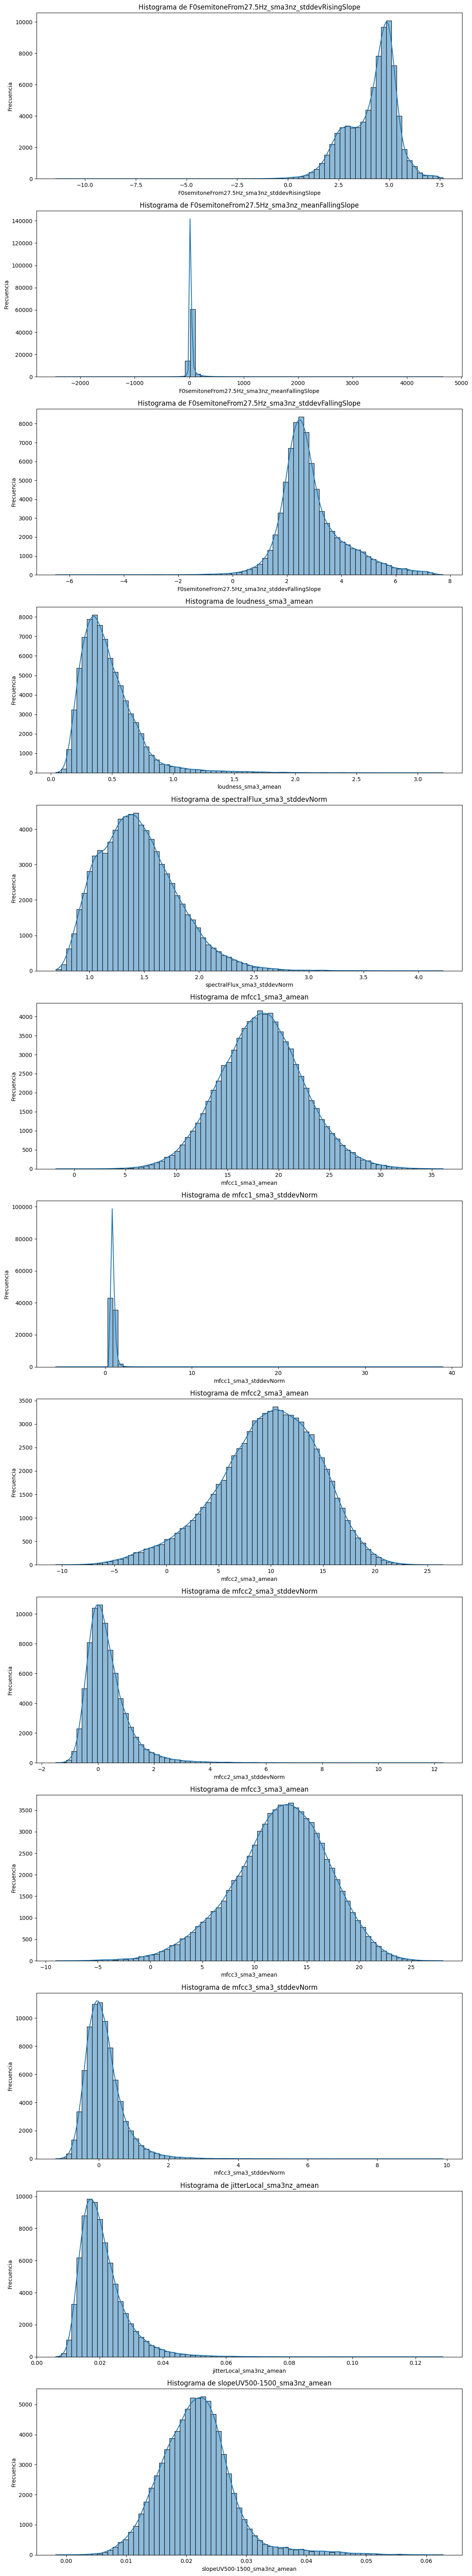

In [141]:
plot_histograms(open_smile)

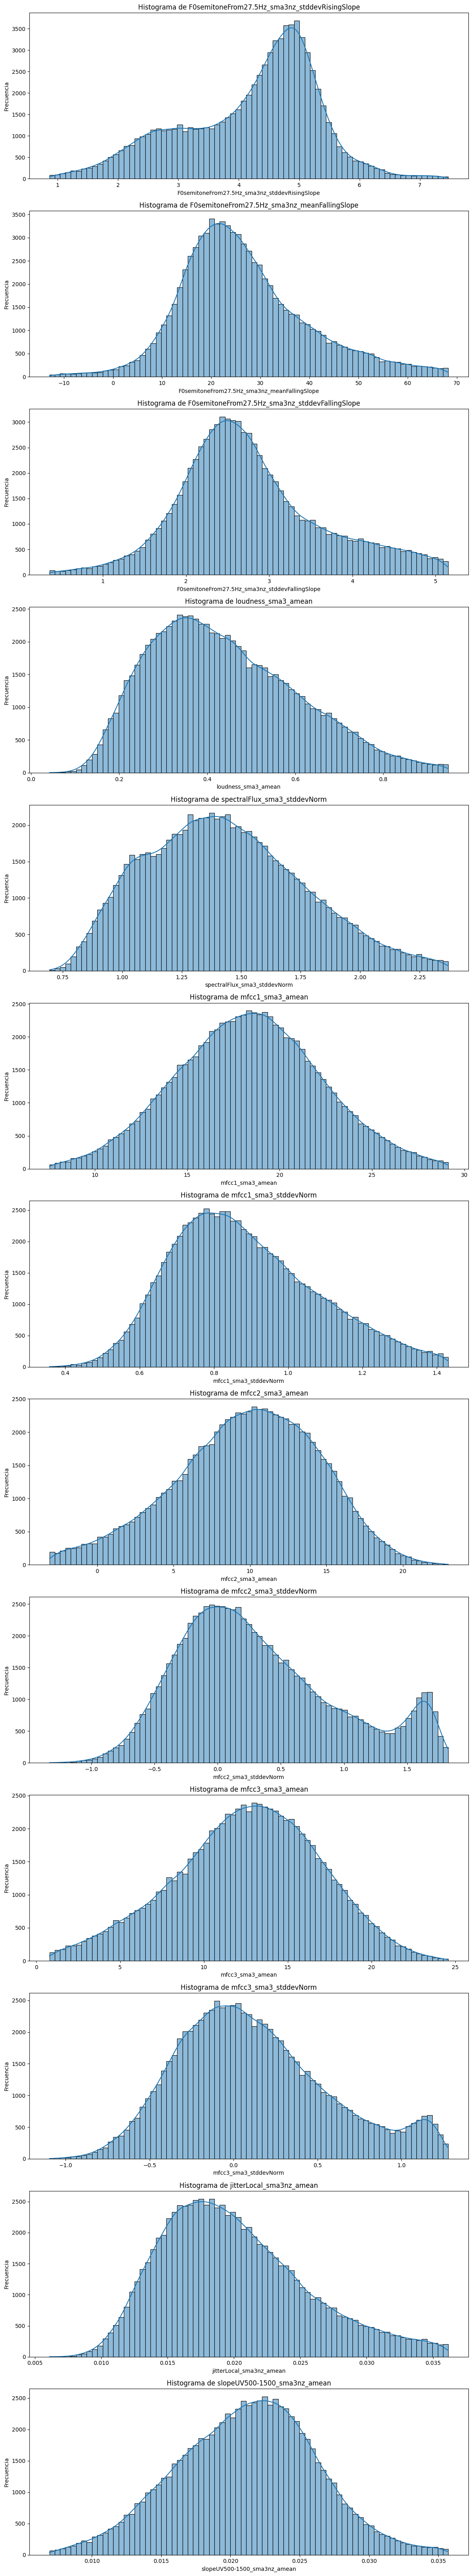

In [142]:
plot_histograms(smile)

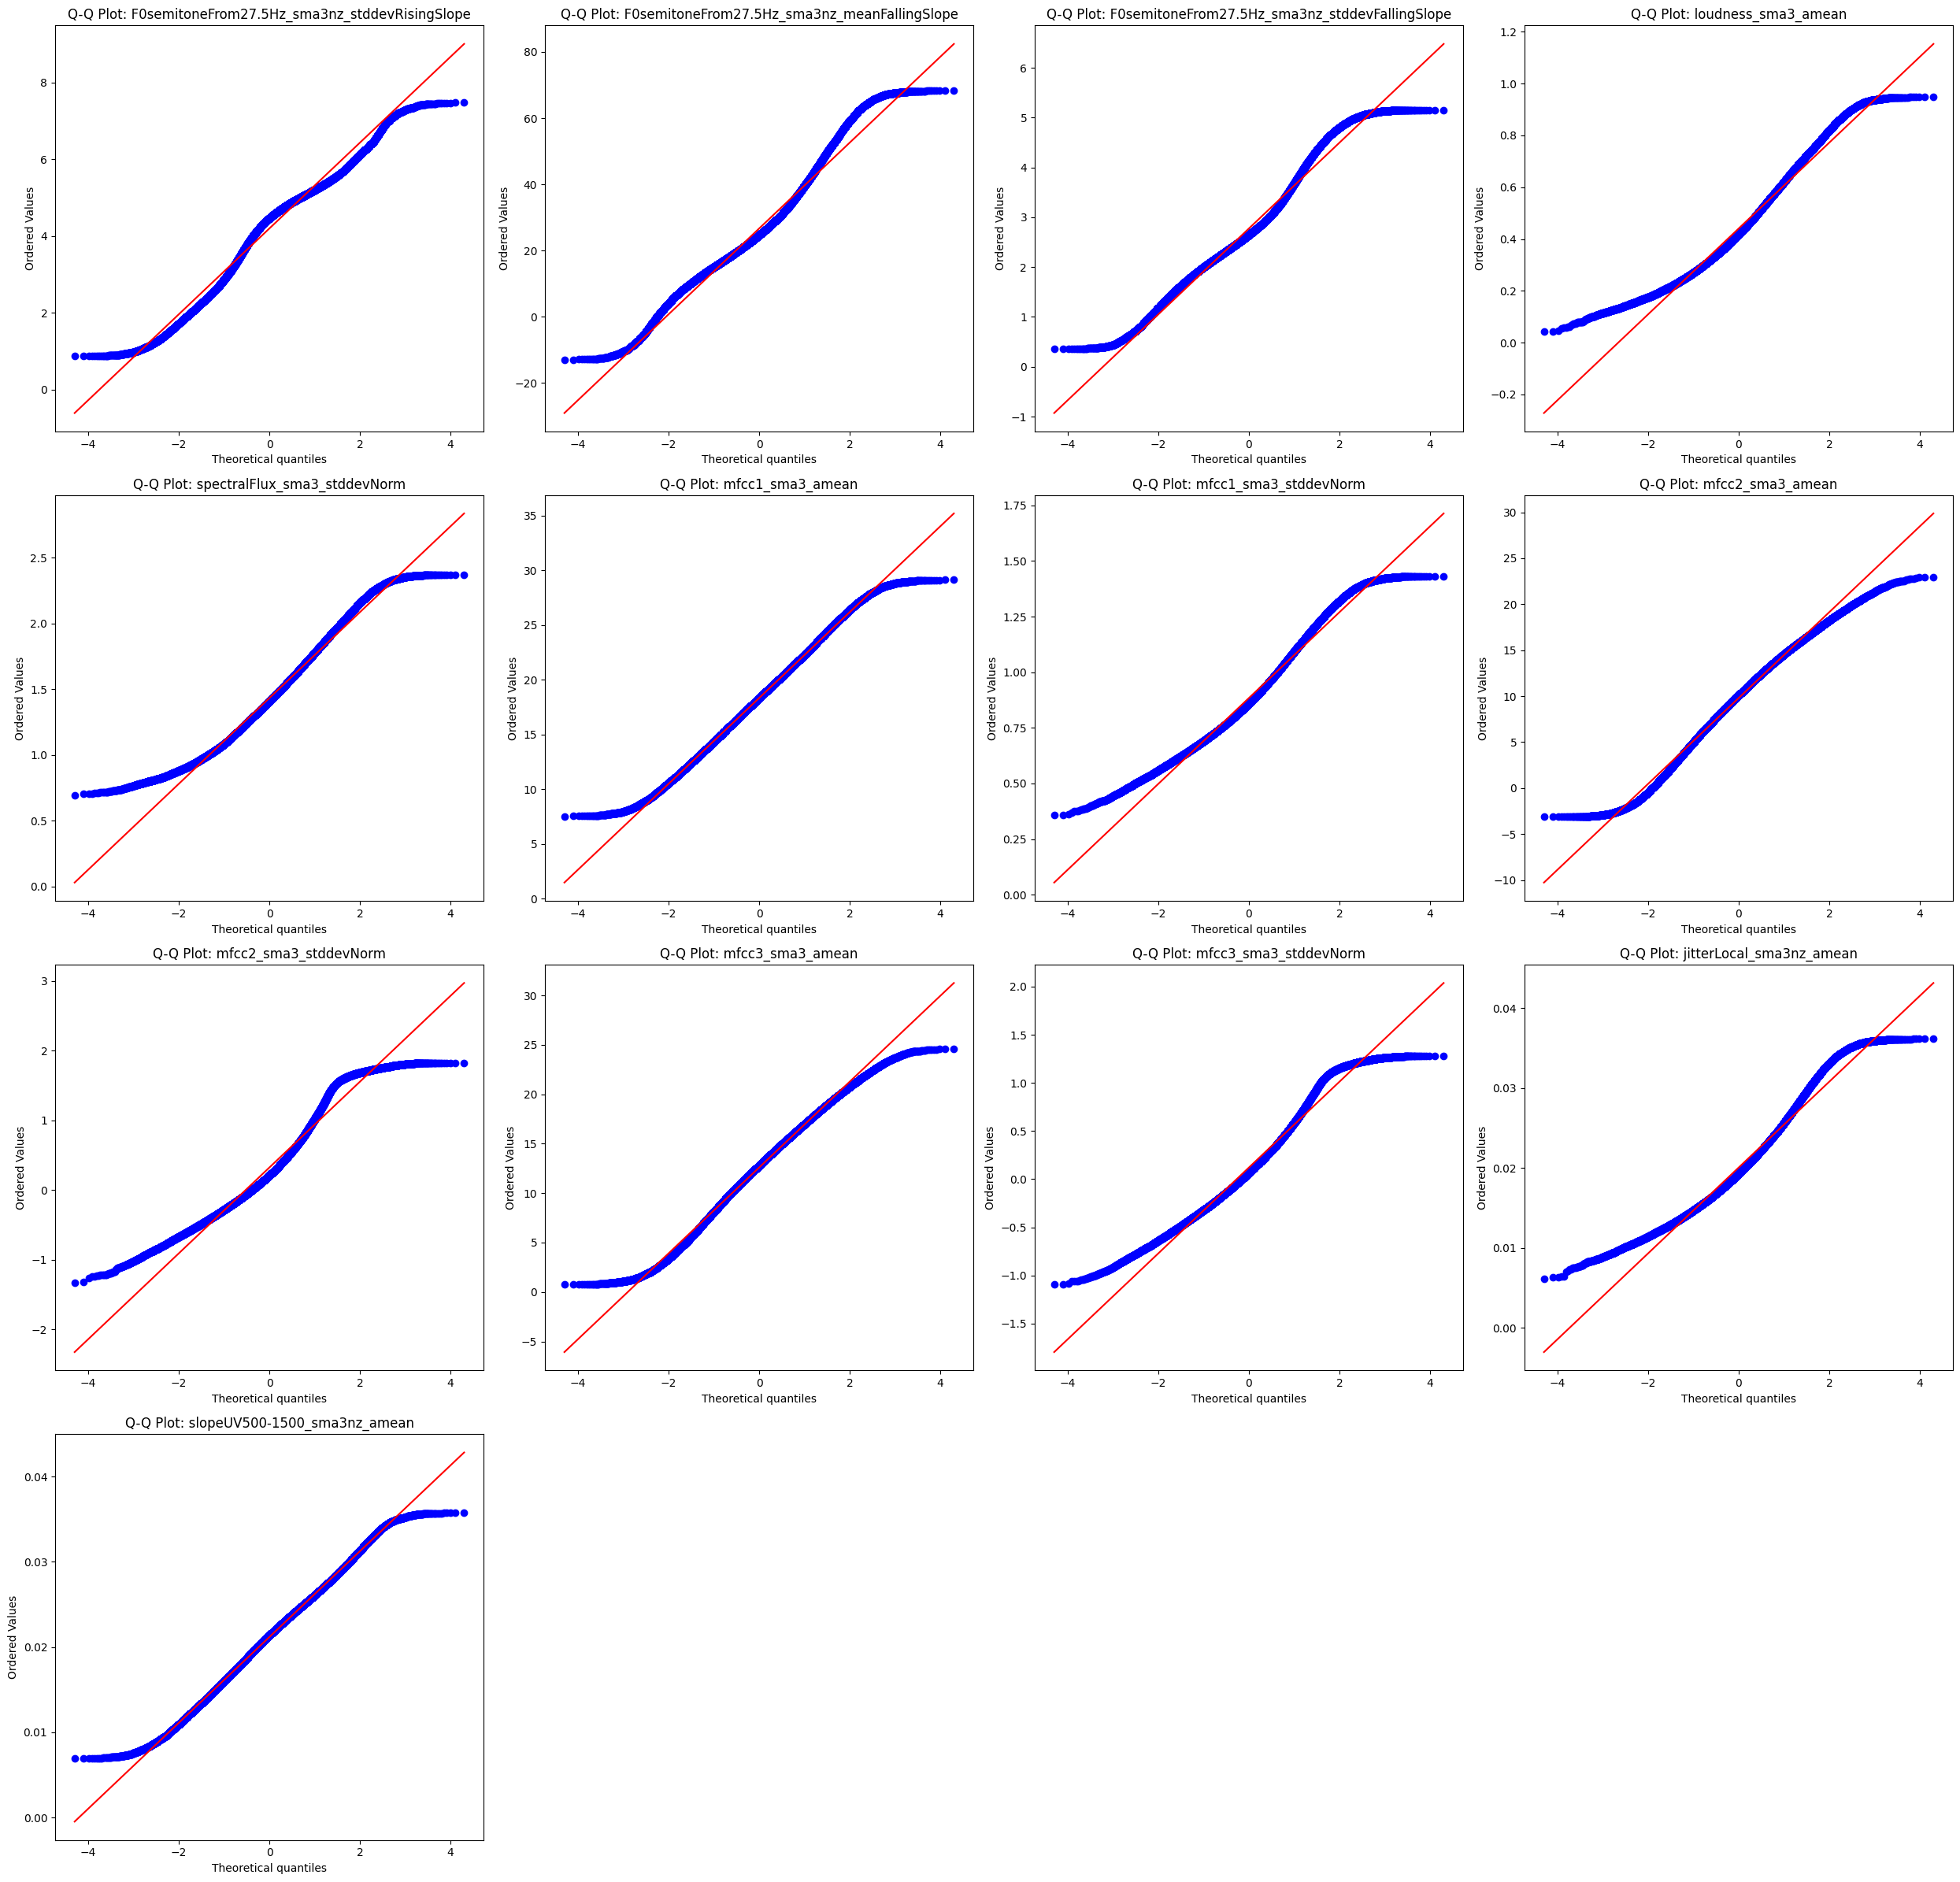

In [143]:
qq_plot(smile)

Tot això ho hem fet abans del merge per no afegir soroll a la imputació amb KNN

Fem el merge del train i el test amb el smile

In [144]:
# Cargar el dataset de características de smile
smile_features = pd.read_csv('smile_final.csv')

train_merged = pd.merge(training_set_p, smile_features, on='UniqueID', how='left')

test_merged = pd.merge(test_csv, smile_features, on='UniqueID', how='left')

val_merged = pd.merge(validation_set, smile_features, on='UniqueID', how='left')

data_explore(train_merged)
data_explore(test_merged)
data_explore(val_merged)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (14243, 18)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14243 entries, 0 to 14242
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   UniqueID                                        14243 non-null  int64  
 1   Realornot                                       14243 non-null  int64  
 2   Final_sex                                       14243 non-null  object 
 3   Final_country                                   14243 non-null  object 
 4   Unnamed: 0                                      14243 non-null  int64  
 5   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   14243 non-null  float64
 6   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    14243 non-null  float64
 7   F0

Recodificació de variables, one hot encoding per final_sex i final_country

Traslladem el preprocessed al test i al val

In [145]:
# Perform one hot encoding
train_set_encoded = pd.get_dummies(train_merged, columns=['Final_country'])
train_set_encoded['Final_sex'] = train_set_encoded['Final_sex'].map({'Male': 0, 'Female': 1})

test_set_encoded = pd.get_dummies(test_merged, columns=['Final_country'])
test_set_encoded['Final_sex'] = test_set_encoded['Final_sex'].map({'Male': 0, 'Female': 1})

val_set_encoded = pd.get_dummies(val_merged, columns=['Final_country'])
val_set_encoded['Final_sex'] = val_set_encoded['Final_sex'].map({'Male': 0, 'Female': 1})

# Get the one-hot encoded column names (country)
cols_to_convert = [col for col in train_set_encoded.columns if col.startswith('Final_country_')]

# Convert only the encoded categorical columns to integer
for col in cols_to_convert:
    train_set_encoded[col] = train_set_encoded[col].astype(int)
    test_set_encoded[col] = test_set_encoded[col].astype(int)
    val_set_encoded[col] = val_set_encoded[col].astype(int)

2) PREPARACIÓ DE VARIABLES

La normalització de variables està feta anteriorment per poder tractar correctament els outliers. Tot i així a continuació podrem veure les distribucions finals (ho mirem només sobre el smile perquè aquestes són les únques variables continues del train):

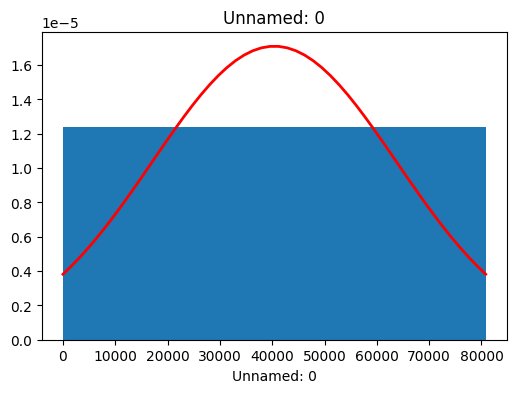

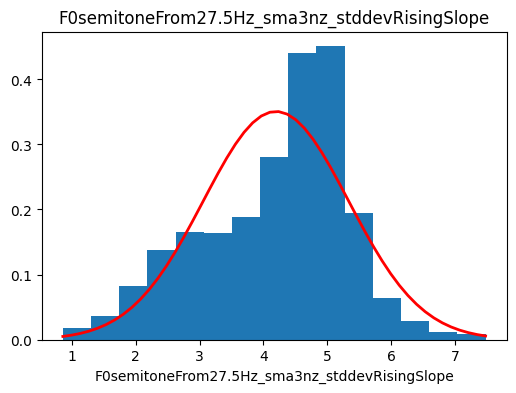

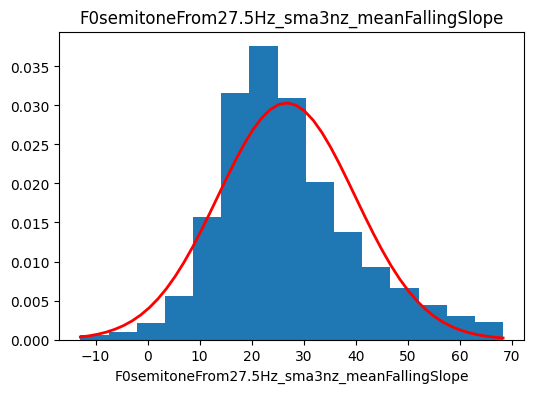

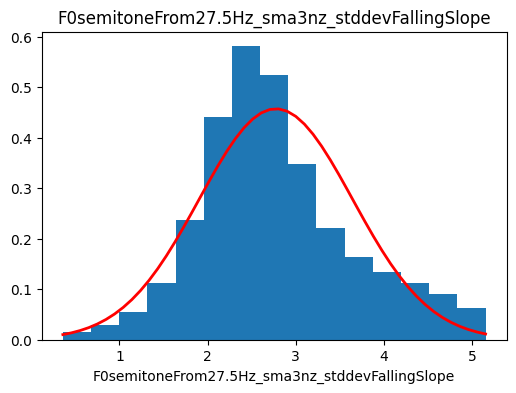

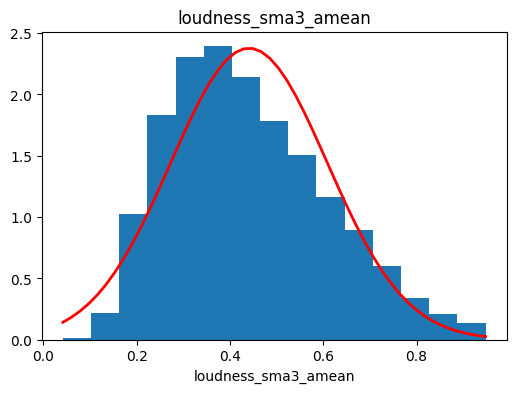

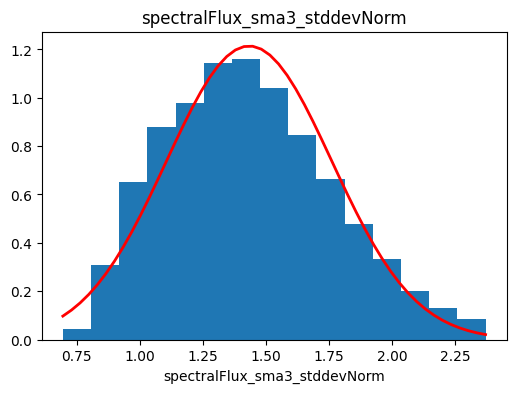

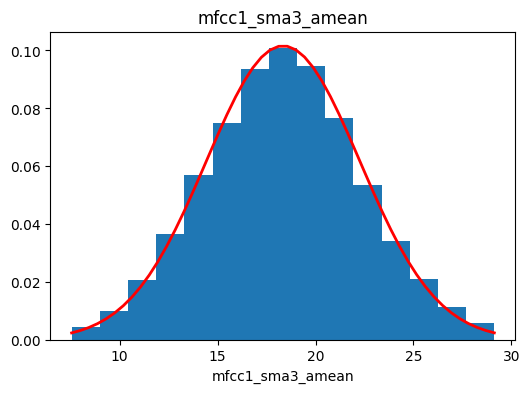

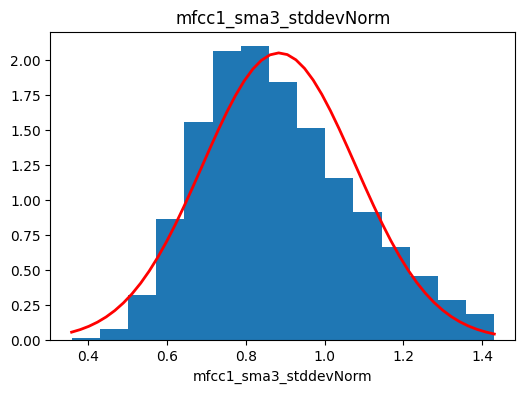

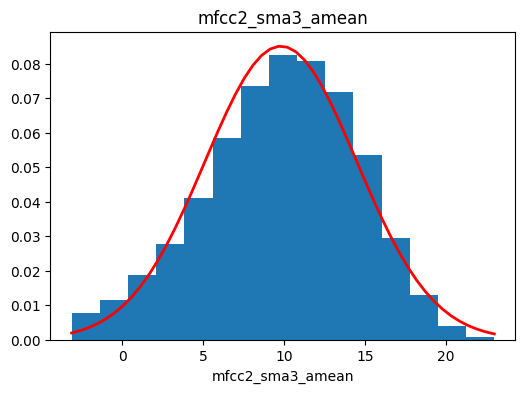

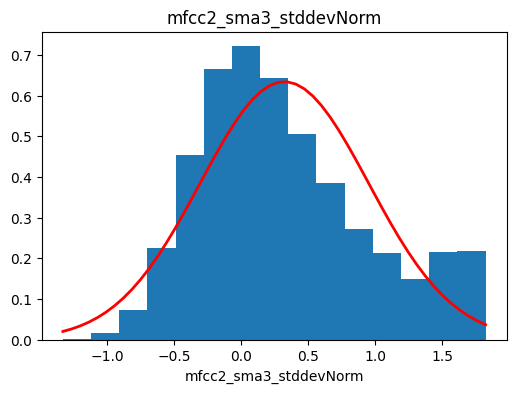

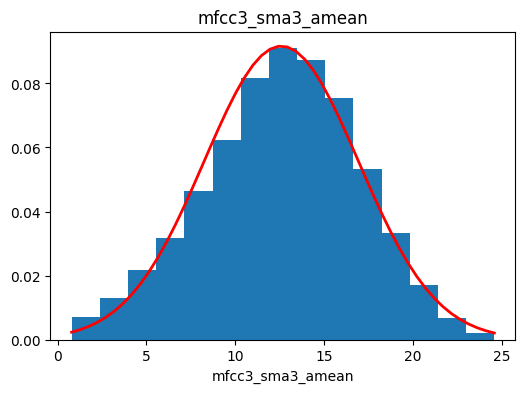

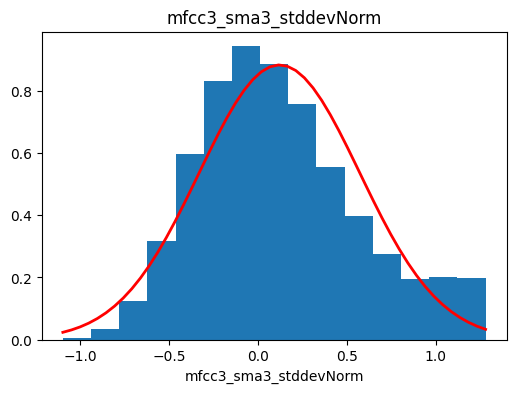

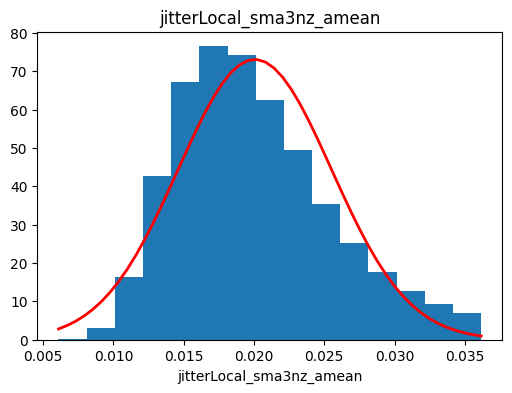

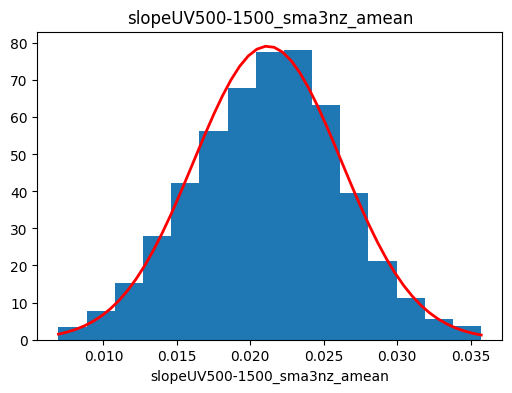

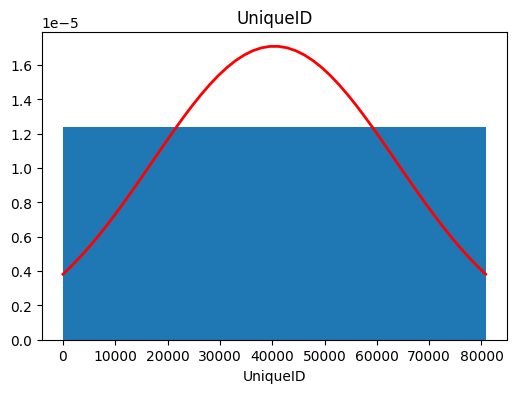

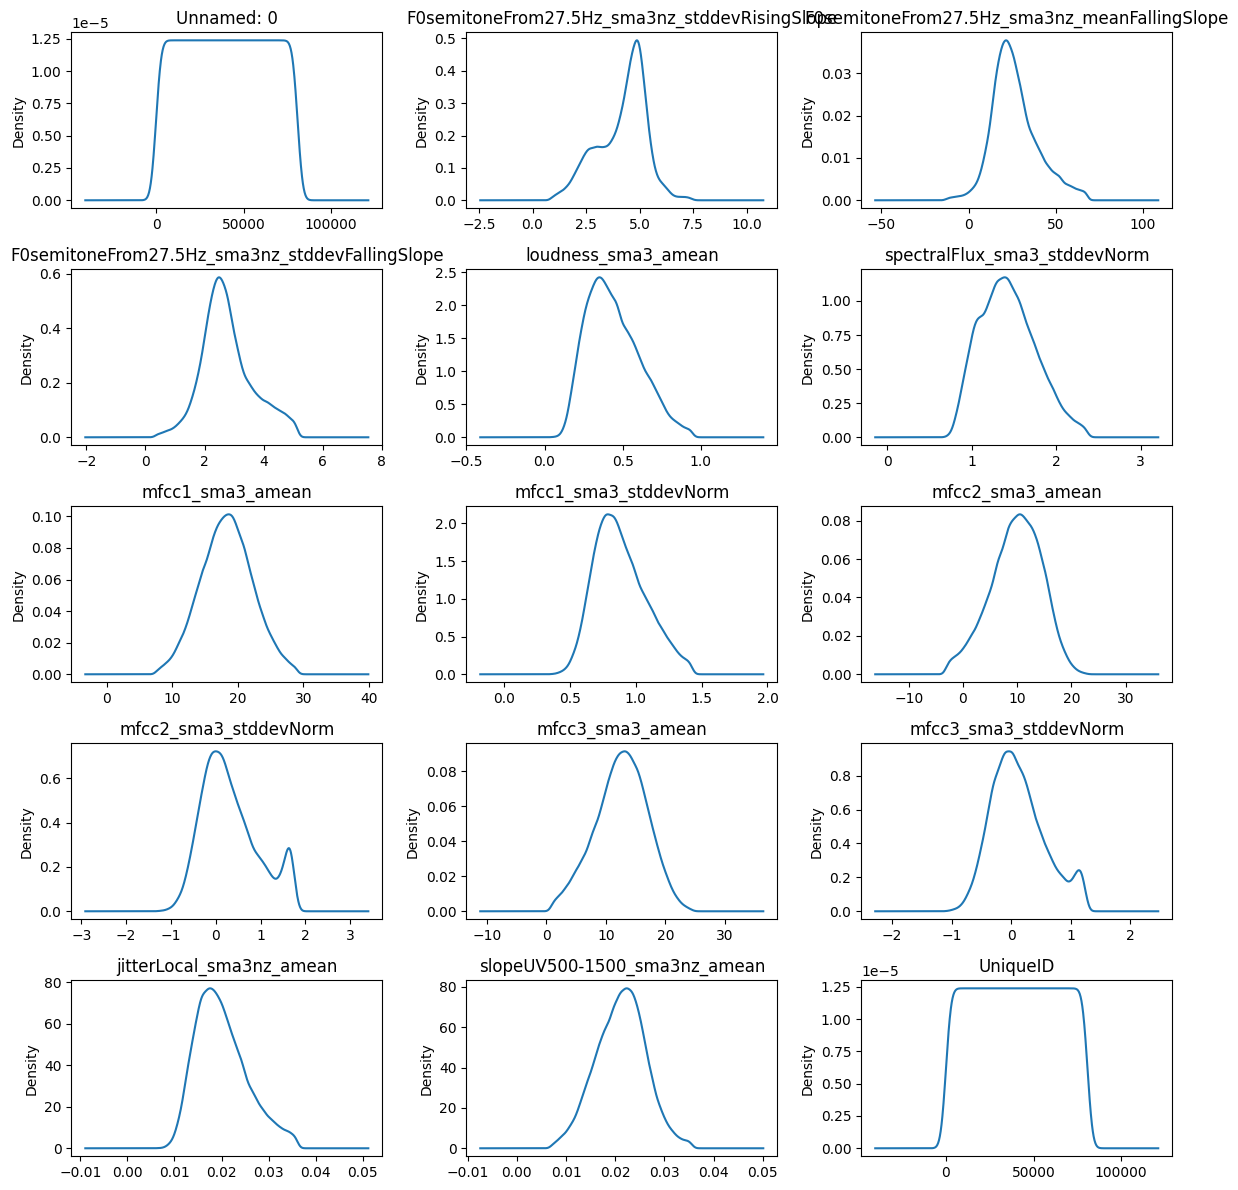

In [146]:
numerical_columns = smile.select_dtypes(include=[np.number]).columns

for col in numerical_columns:
    sigma = smile[col].std()
    mu = smile[col].mean()
    
    fig, ax = plt.subplots(figsize=(6,4))
    count, bins, ignored = plt.hist(smile[col], 15, density=True)
    dbins = np.linspace(bins[0], bins[-1])
    plt.title(col)
    ax.set_xlabel(col)
    plt.plot(dbins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (dbins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
    plt.show()

# Plot KDE for All Numerical Variables
fig = plt.figure(figsize=(12,12))

# Adjust the number of rows and columns to fit all numerical columns
num_cols = len(numerical_columns)
num_rows = (num_cols // 3) + (1 if num_cols % 3 != 0 else 0)

for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(num_rows, 3, i+1)
    smile[col].plot.kde(ax=ax)
    plt.title(col)

fig.tight_layout()
plt.show()

Mirem com estan relacionades las categoriques amb la variable objectiu:

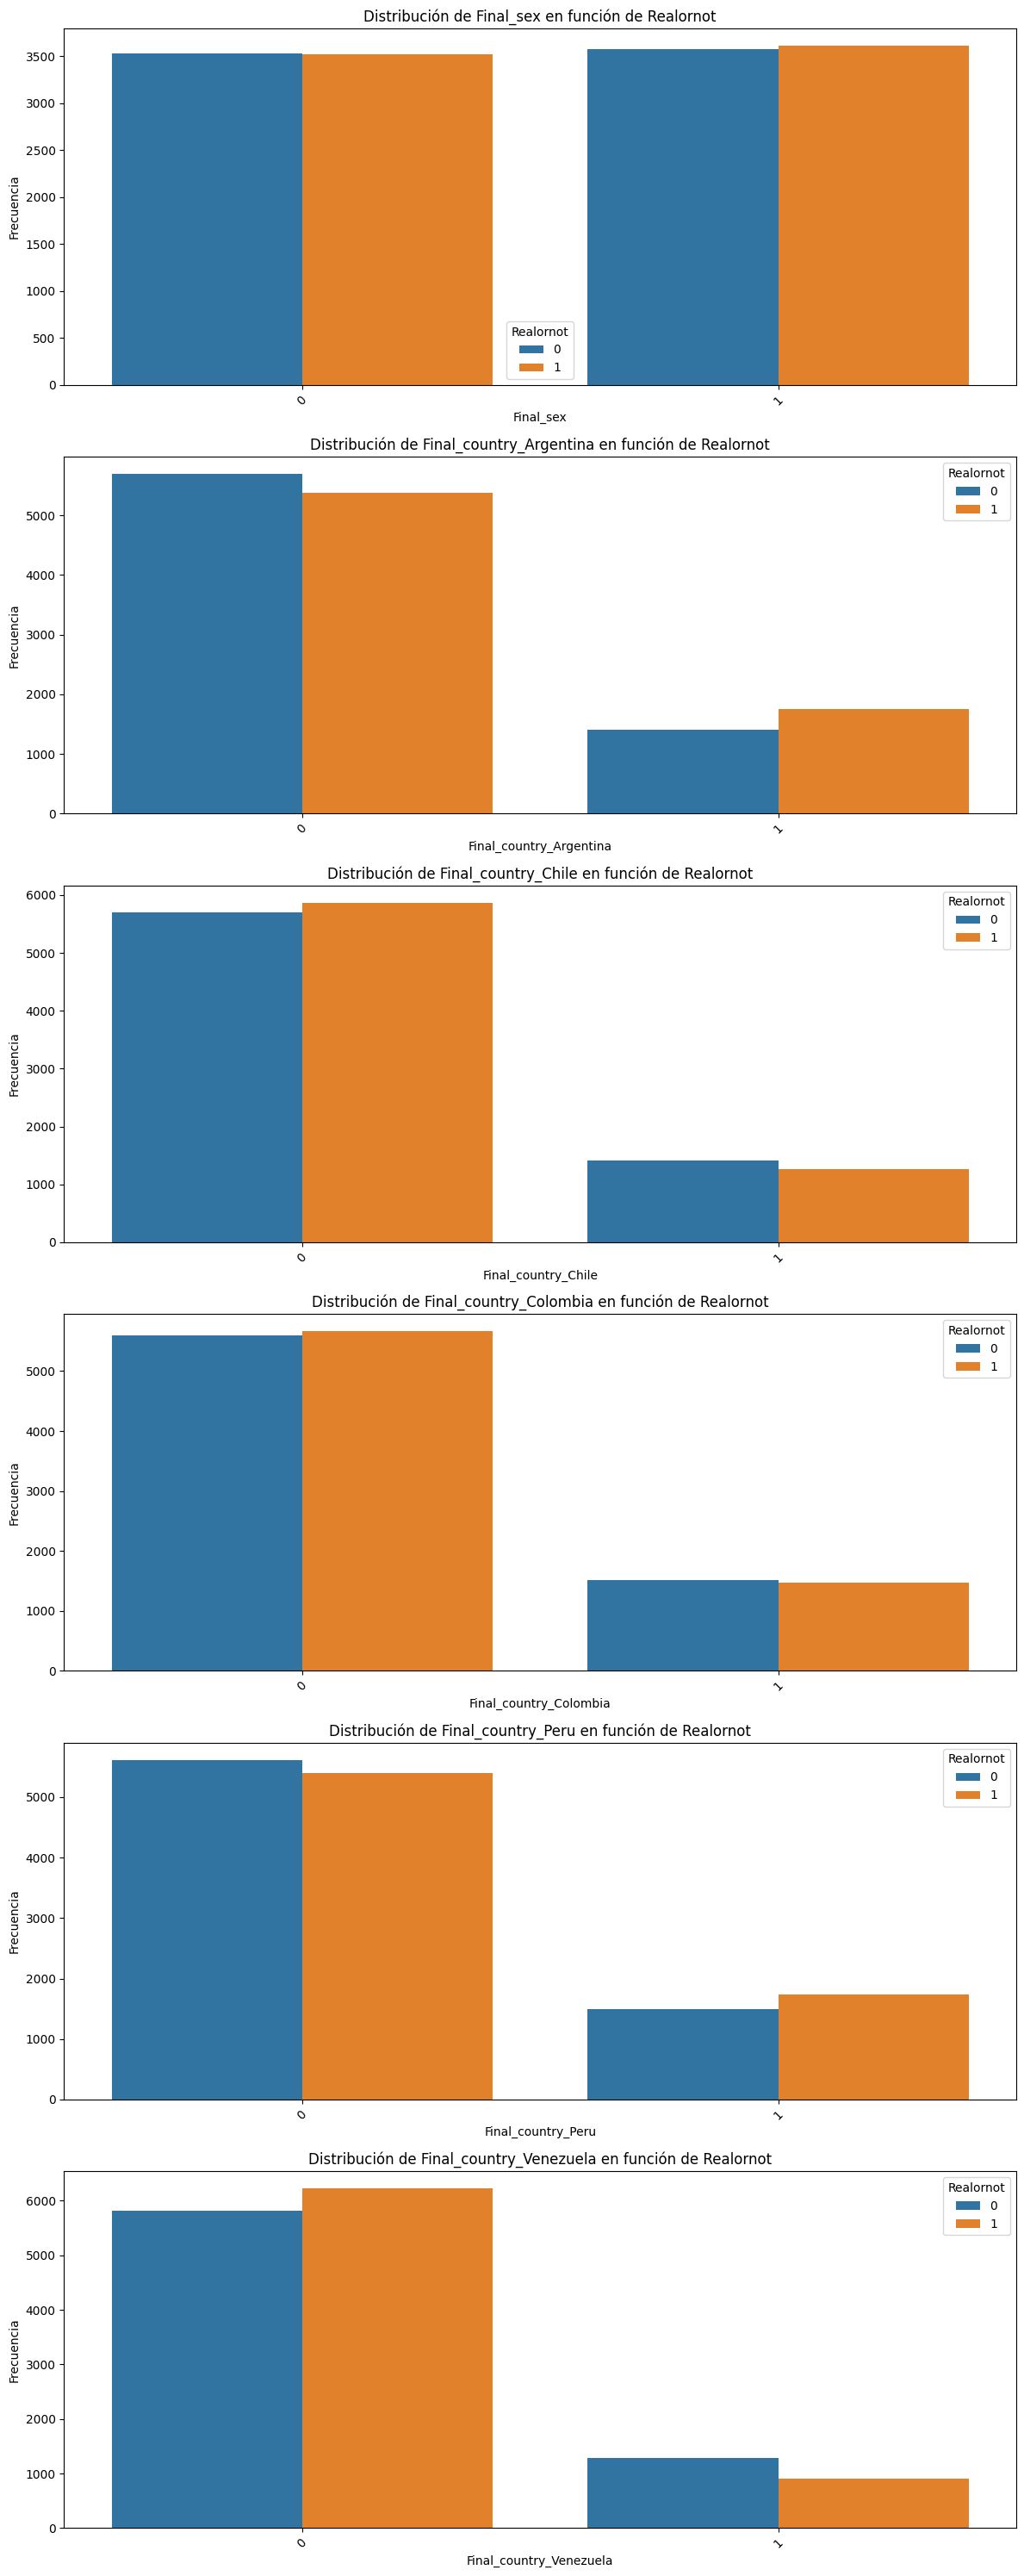

In [147]:
# Seleccionar las variables categóricas
categorical_vars = ['Final_sex', 'Final_country_Argentina', 'Final_country_Chile', 'Final_country_Colombia', 'Final_country_Peru', 'Final_country_Venezuela']

# Crear subplots
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(12, 5 * len(categorical_vars)))

# Generar gráficos de barras para cada variable categórica en función de 'Realornot'
for i, var in enumerate(categorical_vars):
    sns.countplot(data=train_set_encoded, x=var, hue='Realornot', ax=axes[i])
    axes[i].set_title(f'Distribución de {var} en función de Realornot')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Farem la correlacio i el t test per veure quines variables del smile descartem del train (ho mirem només sobre el smile perquè aquestes són les únques variables continues del train):

Mirem com correlacionen les variables del smile csv amb la variable objectiu. No ho fem per seleccionar, ho fem per descartar

In [148]:
# Merge de train_set_encoded con smile para añadir la columna Realornot
smile_merged = pd.merge(smile, train_set_encoded[['UniqueID', 'Realornot']], on='UniqueID', how='left')

In [149]:
smile_merged.dropna(subset=['Realornot'], inplace=True)

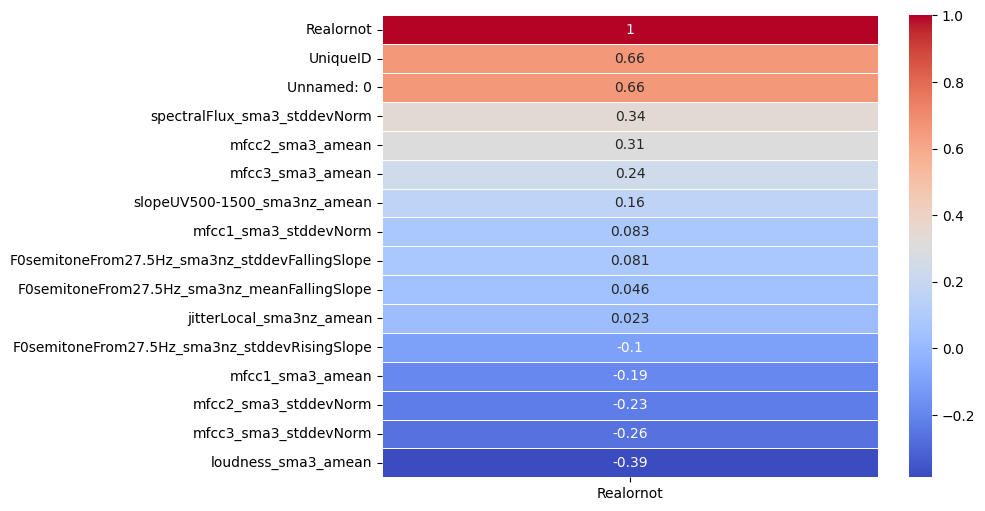

In [150]:
# Calcular la correlación de todas las variables con 'Realornot'
correlation_matrix = smile_merged.corr()

correlation_with_realornot = correlation_matrix[['Realornot']].sort_values(by='Realornot', ascending=False)

# Configurar el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Generar el mapa de calor
sns.heatmap(correlation_with_realornot, annot=True, cmap='coolwarm', linewidths=0.5)

# Mostrar el gráfico
plt.show()

També mirem el mapa sencer de correlacions entre variables numèriques

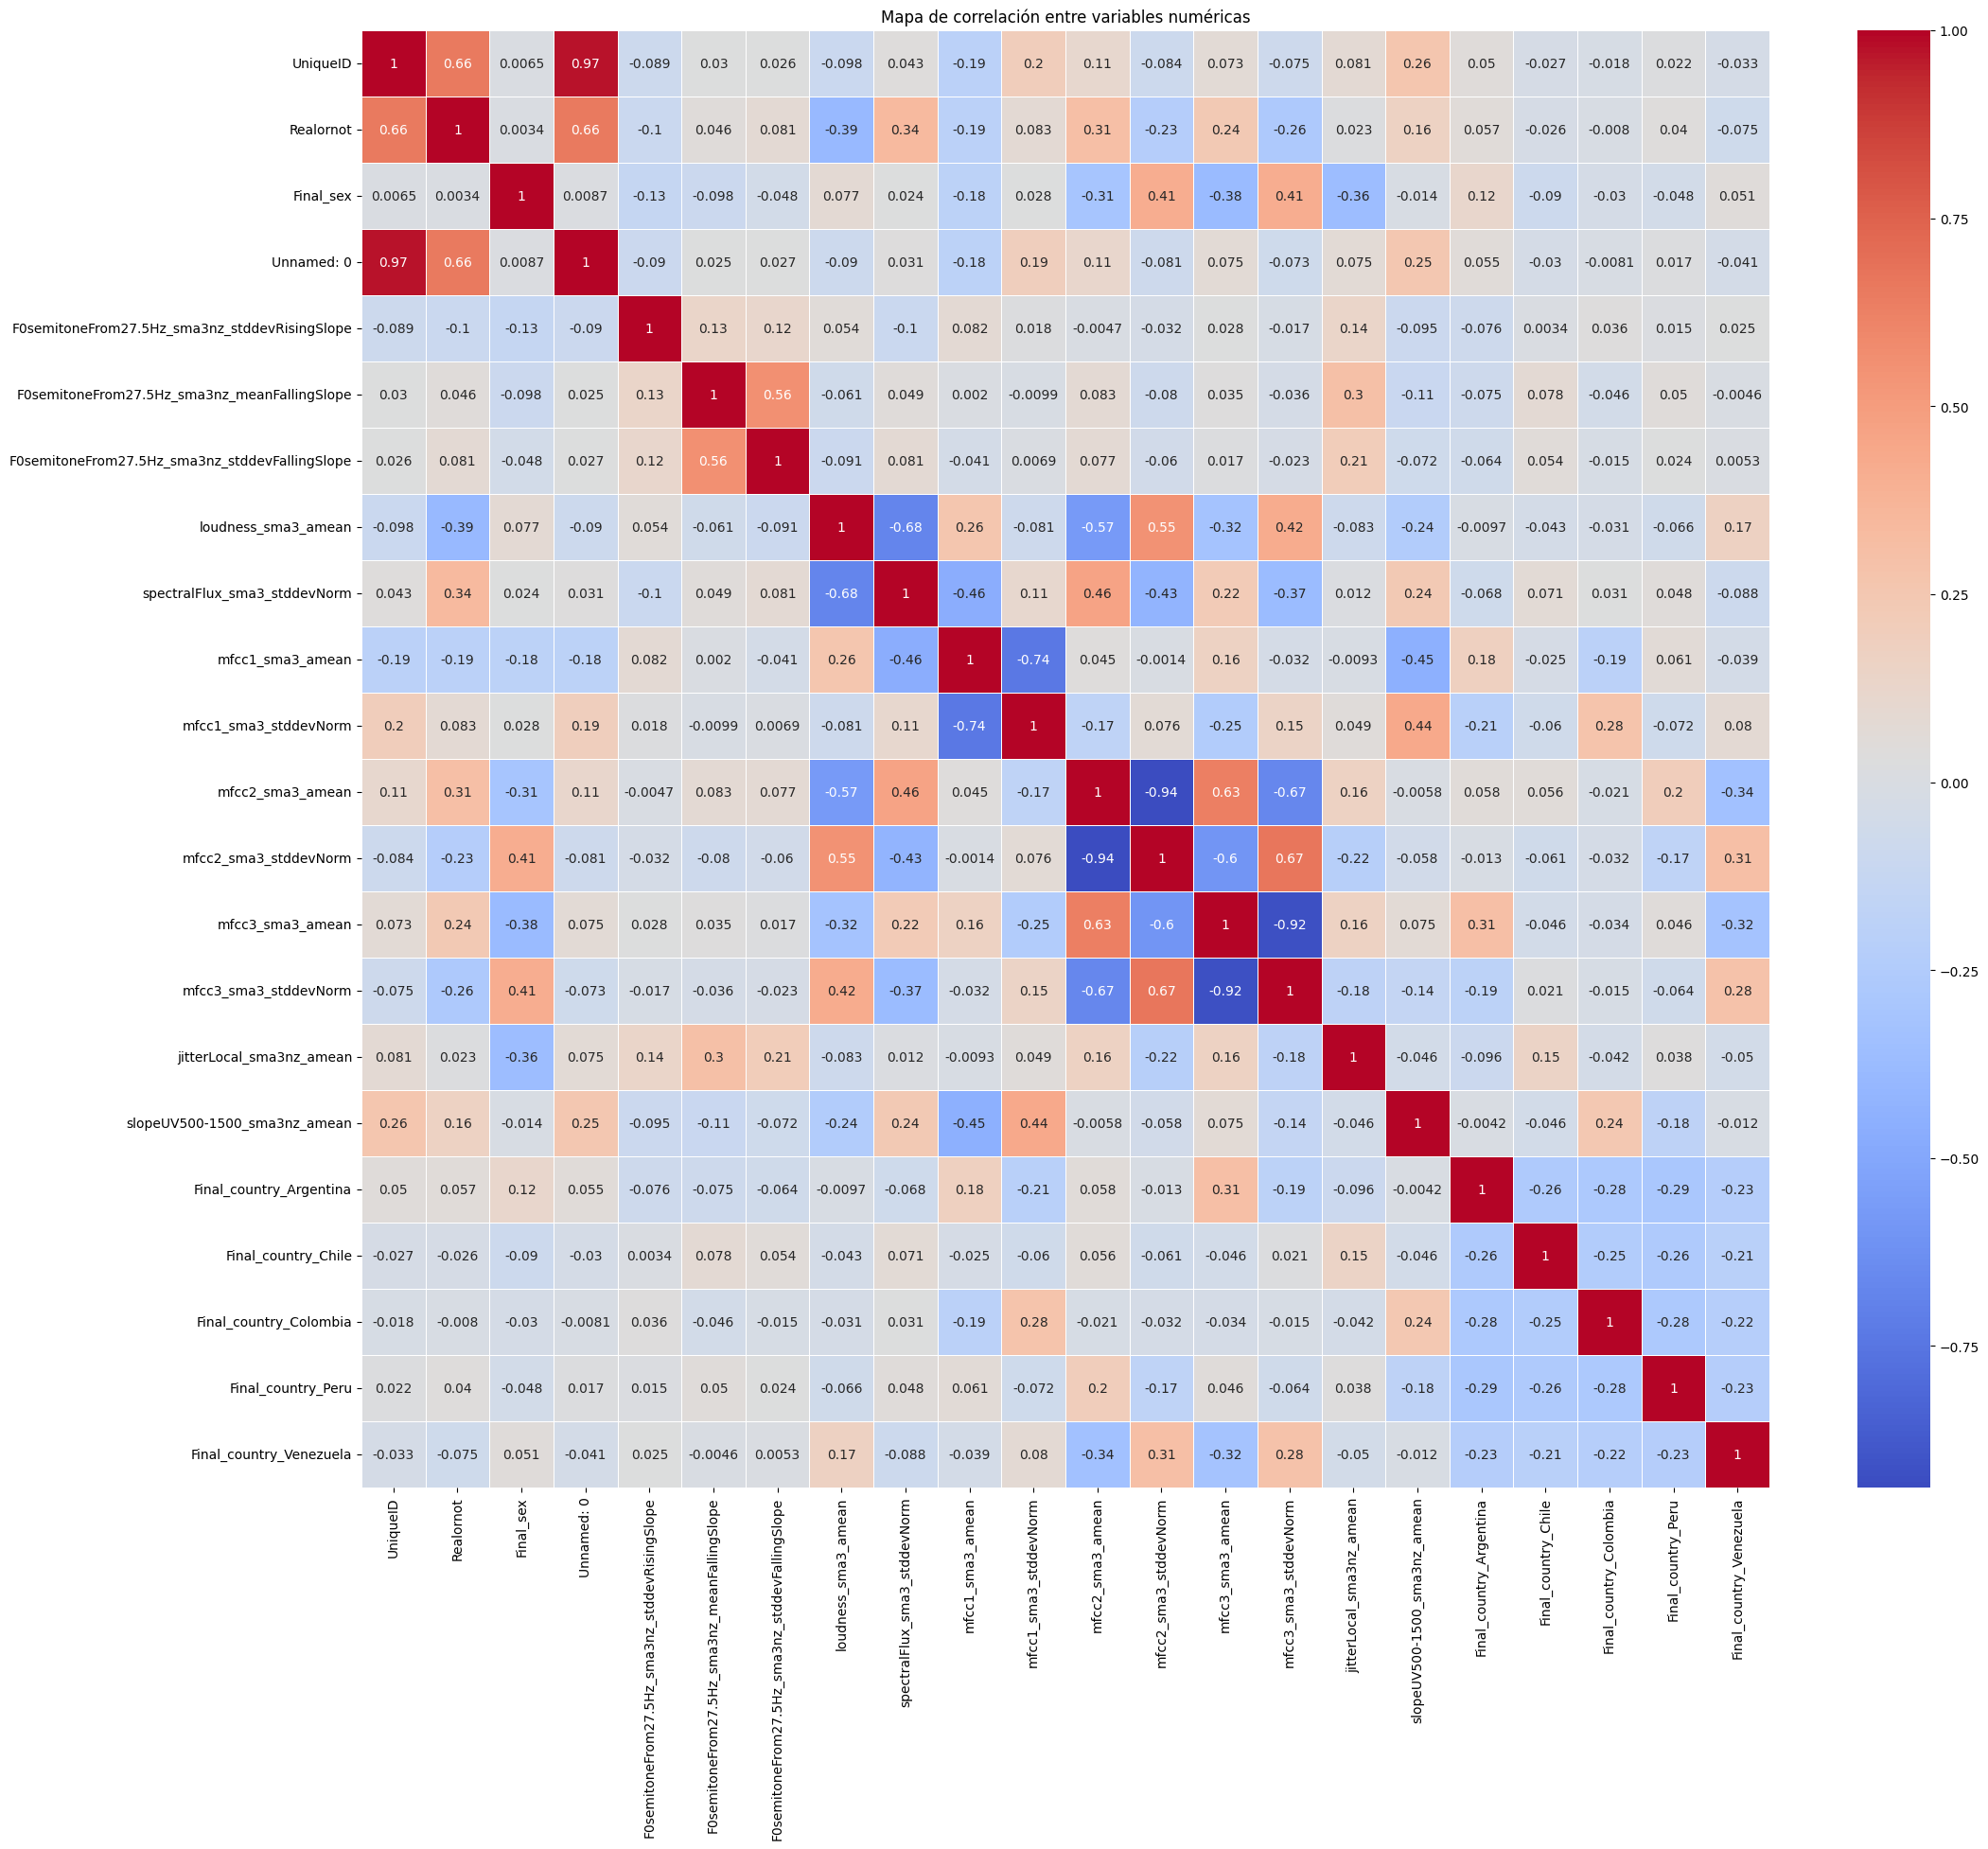

In [151]:
# Seleccionar las columnas numéricas
numerical_columns = train_set_encoded.select_dtypes(include=[np.number]).columns

# Calcular la matriz de correlación
correlation_matrix = train_set_encoded[numerical_columns].corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(24, 20))

# Generar el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Mostrar el gráfico
plt.title('Mapa de correlación entre variables numéricas')
plt.show()

Fem un test t per determinar quines variables son significatives per la prediccio de la variable realornot (No ens podem fiar molt del t test perquè al tenir tantes dades és molt possible que totes ens surtin significatives)

In [152]:
from scipy.stats import ttest_ind

# Filtrar los datos por categoría "Real" y "No Real"
real_data = train_set_encoded[train_set_encoded['Realornot'] == 1]
not_real_data = train_set_encoded[train_set_encoded['Realornot'] == 0]

# Lista de variables numéricas
numerical_vars = ['F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 
                  'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 
                  'loudness_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 
                  'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 
                  'jitterLocal_sma3nz_amean', 'slopeUV500-1500_sma3nz_amean']

# Realizar la prueba t para cada variable
results = []
for var in numerical_vars:
    stat, pval = ttest_ind(real_data[var], not_real_data[var], nan_policy='omit')
    results.append([var, stat, pval])

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results, columns=['Variable', 'T-statistic', 'p-value'])

# Mostrar las variables que son estadísticamente significativas (p-value < 0.05)
significant_vars = results_df[results_df['p-value'] < 0.05]
print(significant_vars)

                                          Variable  T-statistic        p-value
0    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   -12.430461   2.722332e-35
1     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope     5.515904   3.530393e-08
2   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope     9.699606   3.544654e-22
3                              loudness_sma3_amean   -50.102886   0.000000e+00
4                     spectralFlux_sma3_stddevNorm    43.317266   0.000000e+00
5                                 mfcc1_sma3_amean   -23.065726  1.328895e-115
6                            mfcc1_sma3_stddevNorm     9.909496   4.495652e-23
7                                 mfcc2_sma3_amean    38.908557   0.000000e+00
8                            mfcc2_sma3_stddevNorm   -28.162072  7.382020e-170
9                                 mfcc3_sma3_amean    29.438124  5.865963e-185
10                           mfcc3_sma3_stddevNorm   -32.719152  1.819821e-226
11                        jitterLocal_sma3nz_amean  

doncs, descartem les variables amb correlacions entre 0.1 i -0.1 (que són les que correlacionen poc amb la variable objectiu) i tambe descartem algunes variables que tenen una parella amb la que estan altament correlacionades (de la parella descartem la que menys expliqui Realornot) i ho repliqeum al test i al val. PD: per descartar hem fet servir les correlacions i no el t-test. Tampoc incluim UniqueID ja que seria un greu error conservarla en els datasets de train, test o val

In [153]:
columns_to_drop = ['F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 
                   'jitterLocal_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean',  'mfcc1_sma3_stddevNorm', 'Unnamed: 0', 'UniqueID']

train_set_encoded.drop(columns=columns_to_drop, inplace=True)
test_set_encoded.drop(columns=columns_to_drop, inplace=True)
val_set_encoded.drop(columns=columns_to_drop, inplace=True)

#guardem els datasets finals
train_set_encoded.to_csv('training.csv', index=False)
test_set_encoded.to_csv('test.csv', index=False)
val_set_encoded.to_csv('val.csv', index=False)

PCA, no incluim les variables processades amb one hot enconding

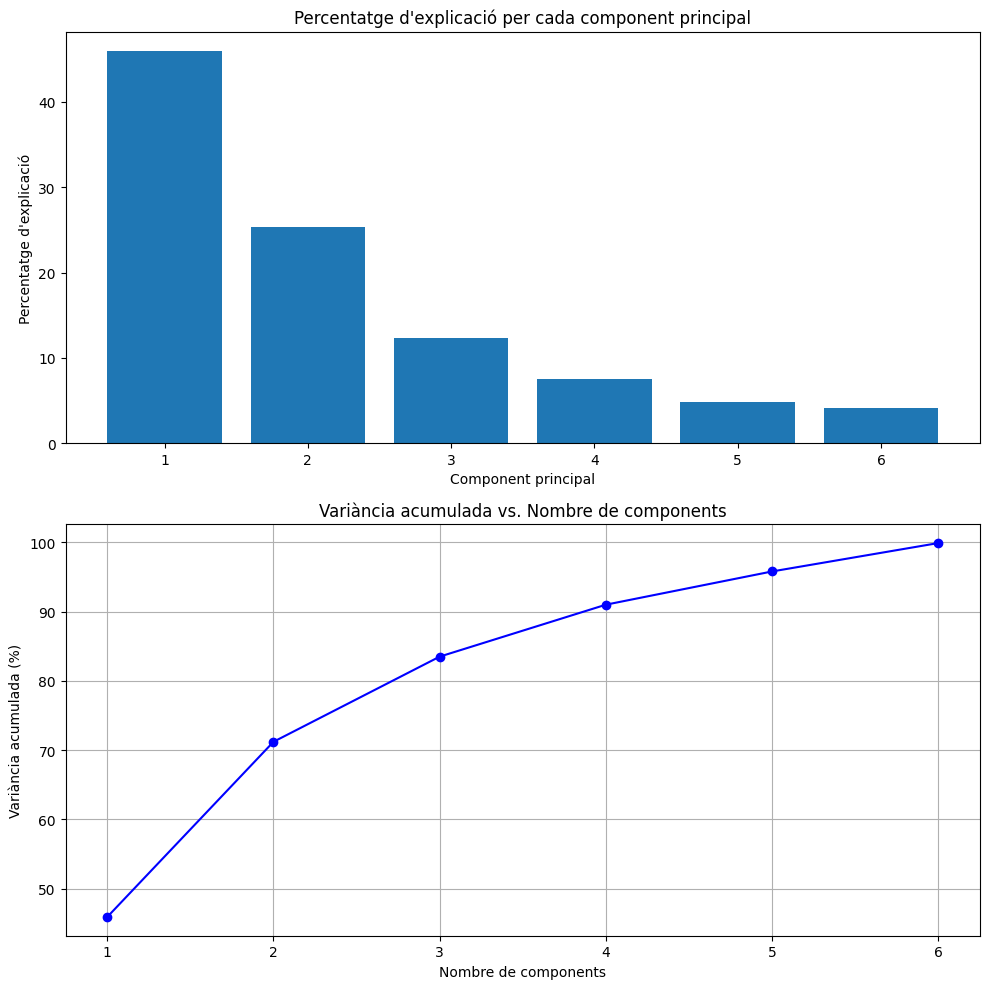


Varianza explicada por componente:
PC1: 45.9%
PC2: 25.3%
PC3: 12.3%
PC4: 7.5%
PC5: 4.8%
PC6: 4.1%

Varianza acumulada:
PC1-PC1: 45.9%
PC1-PC2: 71.2%
PC1-PC3: 83.5%
PC1-PC4: 91.0%
PC1-PC5: 95.8%
PC1-PC6: 99.89999999999999%


In [154]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

training_df = pd.read_csv('training.csv')

# Seleccionar las columnas numéricas que no han sido procesadas con one hot encoding
numeric_columns = ['loudness_sma3_amean','spectralFlux_sma3_stddevNorm','mfcc1_sma3_amean','mfcc2_sma3_amean',
                   'mfcc3_sma3_stddevNorm','slopeUV500-1500_sma3nz_amean']

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(training_df[numeric_columns])

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

# Calcular varianza explicada y acumulada
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
cum_var = np.cumsum(per_var)
labels = [str(x) for x in range(1, len(per_var) + 1)]

# Crear subplot con dos gráficas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Gráfica de varianza individual
ax1.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
ax1.set_ylabel('Percentatge d\'explicació')
ax1.set_xlabel('Component principal')
ax1.set_title('Percentatge d\'explicació per cada component principal')

# Gráfica de varianza acumulada
ax2.plot(range(1, len(cum_var) + 1), cum_var, 'bo-')
ax2.set_ylabel('Variància acumulada (%)')
ax2.set_xlabel('Nombre de components')
ax2.set_title('Variància acumulada vs. Nombre de components')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Imprimir valores numéricos
print("\nVarianza explicada por componente:")
for i, var in enumerate(per_var, 1):
    print(f"PC{i}: {var}%")
print("\nVarianza acumulada:")
for i, cum in enumerate(cum_var, 1):
    print(f"PC1-PC{i}: {cum}%")

3. DEFINICIÓ DE MODELS

Definim una funció per evaluar el model utiltizant la precision, el recall, l'accuracy el f1 score i la curva ROC

In [155]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and print metrics
def evaluate_model(y_true, y_pred, y_prob, dataset_name="Dataset"):
    print(f"\nEvaluation Metrics for {dataset_name}:")
    print(classification_report(y_true, y_pred))

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name='Model'):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    # Add labels and title
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Show plot
    plt.show()

Per trobar la millor combinació d'hiperparàmetres farem servir la tècnica de GridSearchCV de la llibreria sklearn per maximitzar el f1 score:

PRIMER MODEL: KNN

Trobar la millor combinació d'hiperparàmetres per KNN i evaluar el model

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load training and validation datasets
train_df = pd.read_csv('training.csv')
val_df = pd.read_csv('val.csv')

# Create a pipeline that includes scaling and KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the hyperparameters to test
param_grid = {
    'knn__n_neighbors': [5, 7, 8, 9, 11, 13],  
    'knn__weights': ['uniform', 'distance'],  
    'knn__metric': ['euclidean', 'manhattan']  
}

# Define GridSearchCV with the pipeline
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    scoring='precision', 
    cv=5, 
    n_jobs=-1
)

# Separate features and target variable
X_train = train_df.drop(columns=['Realornot'])
y_train = train_df['Realornot']

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

mean_precision = grid_search.cv_results_['mean_test_score'].mean()
std_precision = grid_search.cv_results_['std_test_score'].mean()
print(f"Mean precision: {mean_precision:.4f} (+/- {std_precision:.4f})")

# Retrieve the best pipeline
best_pipeline = grid_search.best_estimator_

Best hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 8, 'knn__weights': 'uniform'}
Mean precision: 0.7905 (+/- 0.0055)


Validem el model


Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      7106
           1       0.86      0.90      0.88      7137

    accuracy                           0.88     14243
   macro avg       0.88      0.88      0.88     14243
weighted avg       0.88      0.88      0.88     14243



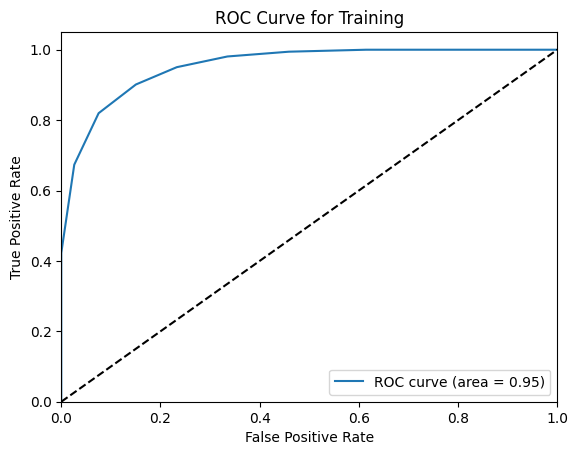

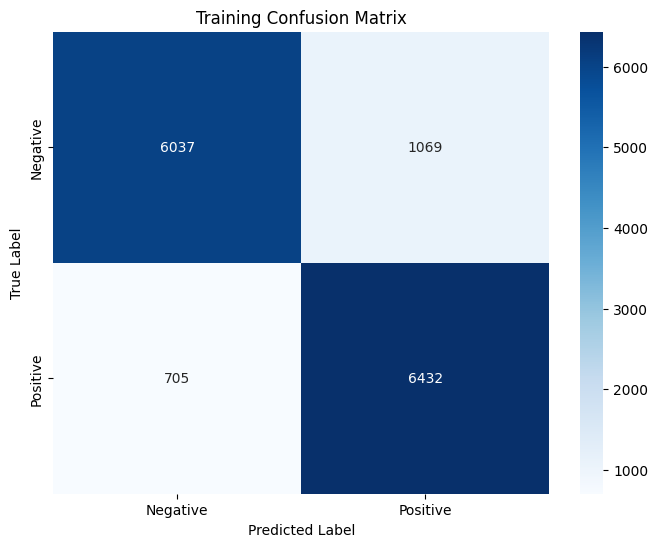


Evaluation Metrics for Validation:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1759
           1       0.83      0.88      0.85      1802

    accuracy                           0.85      3561
   macro avg       0.85      0.85      0.85      3561
weighted avg       0.85      0.85      0.85      3561



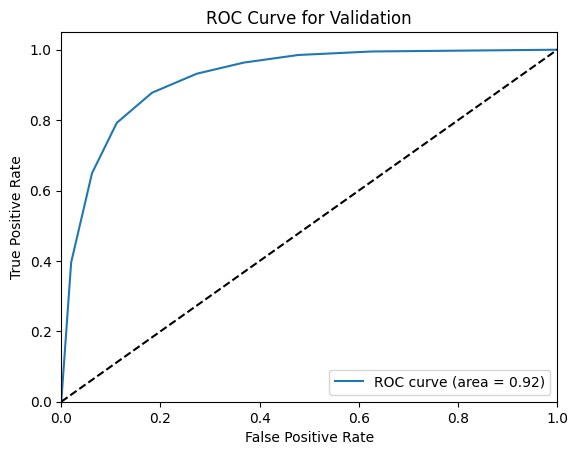

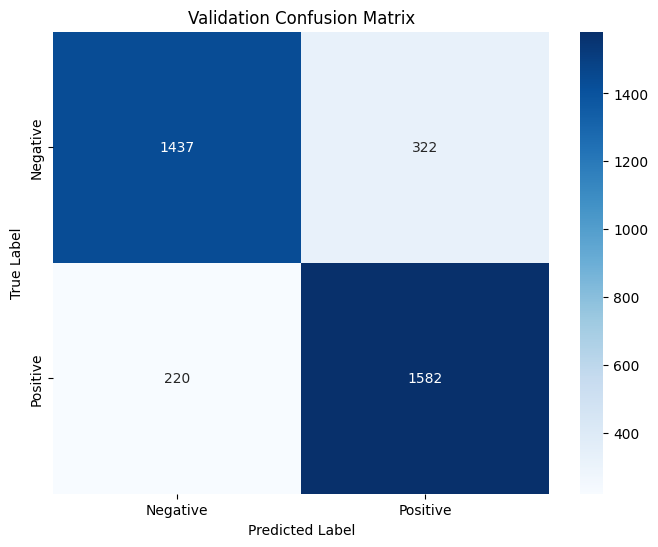

In [157]:
# Validate the model
X_val = val_df.drop(columns=['Realornot'])
y_val = val_df['Realornot']

# Predict on training and validation data
train_pred = best_pipeline.predict(X_train)
train_prob = best_pipeline.predict_proba(X_train)[:, 1]
val_pred = best_pipeline.predict(X_val)
val_prob = best_pipeline.predict_proba(X_val)[:, 1]


# Evaluate training and validation metrics
evaluate_model(y_train, train_pred, train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, train_pred, model_name='Training')
evaluate_model(y_val, val_pred, val_prob, dataset_name="Validation")
plot_confusion_matrix(y_val, val_pred, model_name='Validation')

SEGON MODEL: DECISION TREE

Trobar la millor combinació d'hiperparàmetres per decision tree

In [158]:
from sklearn.tree import DecisionTreeClassifier

# Define the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 4, 6, 8, 9, 10, 11, 12],
    'min_samples_split': [37, 38, 39, 40]
}

# Define GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='precision', cv=10, n_jobs=-1)

# Separate features and target variable
X_train = train_df.drop(columns=['Realornot'])
y_train = train_df['Realornot']

# Fit the model
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params_dt = grid_search.best_params_
print(f"Best hyperparameters: {best_params_dt}")

mean_precision = grid_search.cv_results_['mean_test_score'].mean()
std_precision = grid_search.cv_results_['std_test_score'].mean()
print(f"Mean precision: {mean_precision:.4f} (+/- {std_precision:.4f})")

Best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 38}
Mean precision: 0.7336 (+/- 0.0113)


Validem el model


Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7106
           1       0.87      0.86      0.87      7137

    accuracy                           0.87     14243
   macro avg       0.87      0.87      0.87     14243
weighted avg       0.87      0.87      0.87     14243



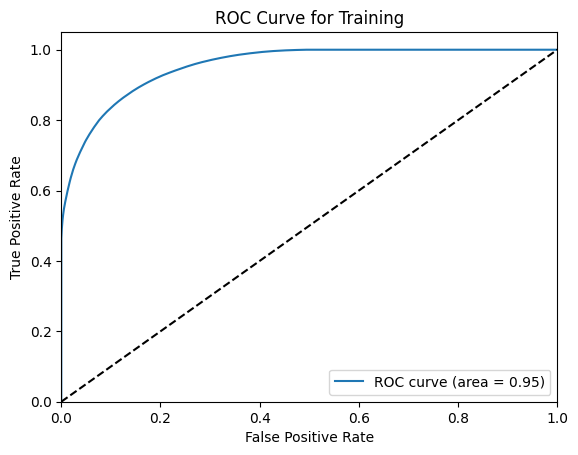

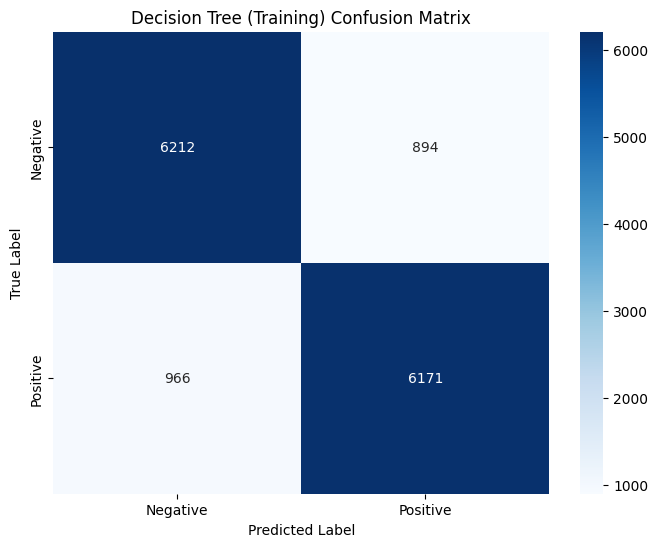


Evaluation Metrics for Validation:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1759
           1       0.79      0.77      0.78      1802

    accuracy                           0.78      3561
   macro avg       0.78      0.78      0.78      3561
weighted avg       0.78      0.78      0.78      3561



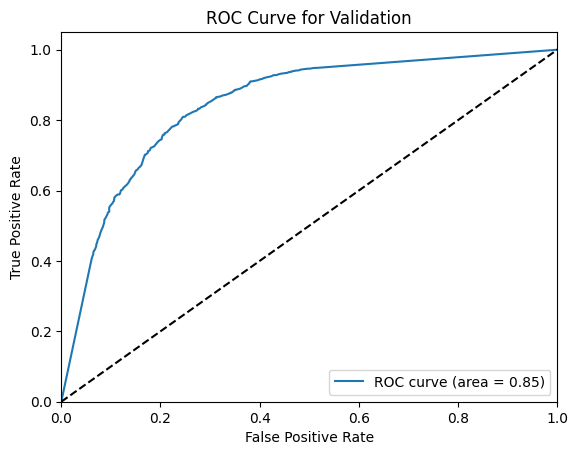

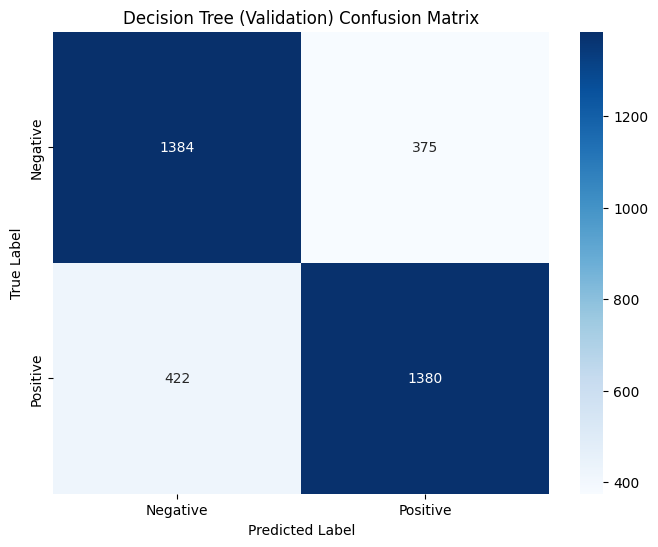

In [159]:
# Train Decision Tree with best parameters
best_dt = DecisionTreeClassifier(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'], 
    criterion=best_params_dt['criterion'],
    random_state=42
)

best_dt.fit(X_train, y_train)

# Predict on training and validation sets
dt_train_pred = best_dt.predict(X_train)
dt_train_prob = best_dt.predict_proba(X_train)[:, 1] 
dt_val_pred = best_dt.predict(X_val)
dt_val_prob = best_dt.predict_proba(X_val)[:, 1]
dt_val_true = y_val

# Evaluate model performance
evaluate_model(y_train, dt_train_pred, dt_train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, dt_train_pred, model_name='Decision Tree (Training)')

evaluate_model(y_val, dt_val_pred, dt_val_prob, dataset_name="Validation") 
plot_confusion_matrix(y_val, dt_val_pred, model_name='Decision Tree (Validation)')

TERCER MODEL: SVM

Trobar la millor combinació de hiperparàmetres per SVM

In [160]:
from sklearn.svm import SVC

# Define the SVM model
svm = SVC(random_state=42)

# Define the hyperparameters to test
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Define GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='precision', cv=10, n_jobs=-1)

# Separate features and target variable
X_train = train_df.drop(columns=['Realornot'])
y_train = train_df['Realornot']

# Fit the model
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params_svm = grid_search.best_params_
print(f"Best hyperparameters: {best_params_svm}")

mean_precision = grid_search.cv_results_['mean_test_score'].mean()
std_precision = grid_search.cv_results_['std_test_score'].mean()
print(f"Mean precision: {mean_precision:.4f} (+/- {std_precision:.4f})")

Best hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mean precision: 0.7094 (+/- 0.0113)


Validem el model


Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      7106
           1       0.78      0.82      0.80      7137

    accuracy                           0.79     14243
   macro avg       0.80      0.79      0.79     14243
weighted avg       0.80      0.79      0.79     14243



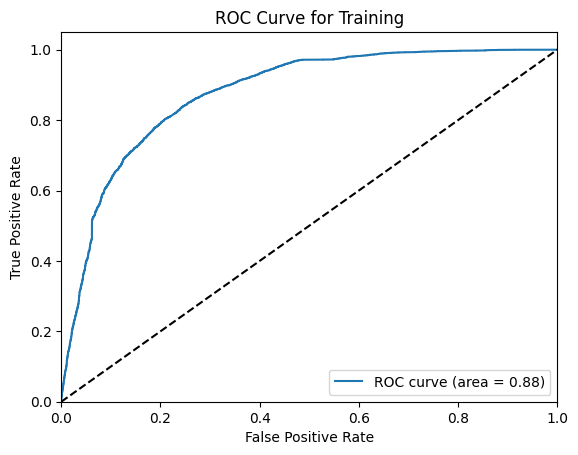

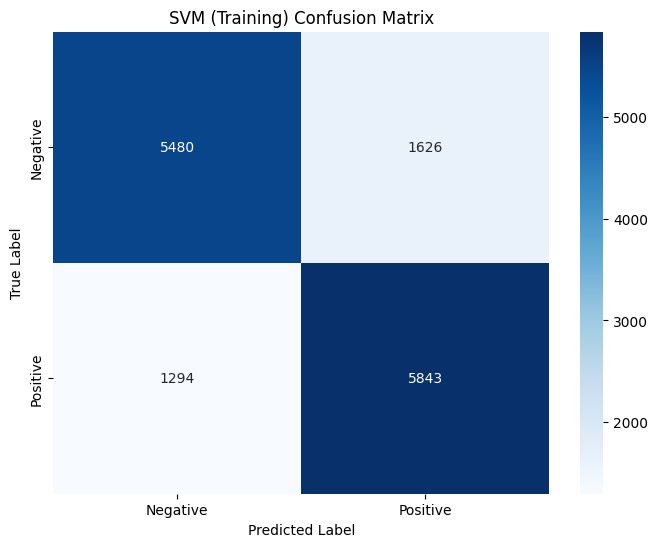


Evaluation Metrics for Validation:
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1759
           1       0.76      0.81      0.79      1802

    accuracy                           0.78      3561
   macro avg       0.78      0.78      0.78      3561
weighted avg       0.78      0.78      0.78      3561



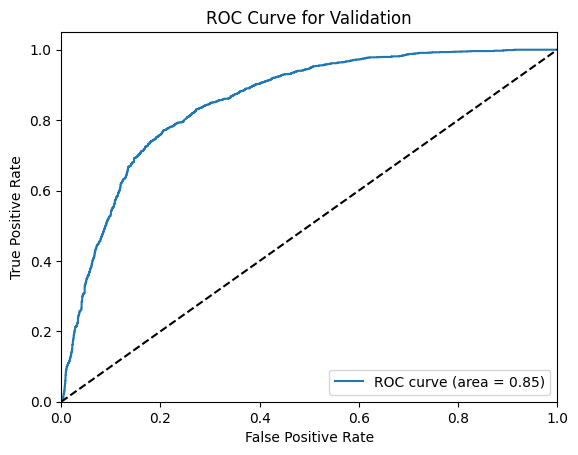

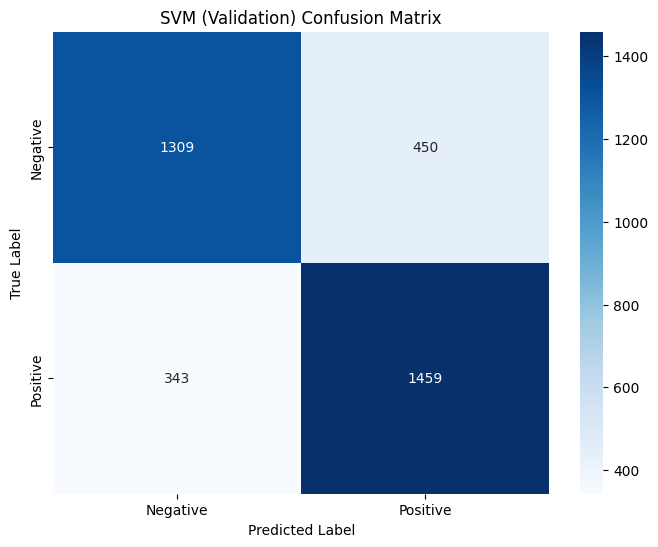

In [161]:
# Train final SVM model with best parameters
best_svm = SVC(
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'],
    random_state=42,
    probability=True
)
best_svm.fit(X_train, y_train)

# Make predictions
svm_train_pred = best_svm.predict(X_train)
svm_train_prob = best_svm.predict_proba(X_train)[:,1]
svm_val_pred = best_svm.predict(X_val)
svm_val_prob = best_svm.predict_proba(X_val)[:,1]
svm_val_true = y_val

# Evaluate model performance
evaluate_model(y_train, svm_train_pred, svm_train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, svm_train_pred, model_name='SVM (Training)')

evaluate_model(y_val, svm_val_pred, svm_val_prob, dataset_name="Validation") 
plot_confusion_matrix(y_val, svm_val_pred, model_name='SVM (Validation)')

4. SELECCIÓ DEL MODEL


Best Parameters:
KNN: {'knn__metric': 'manhattan', 'knn__n_neighbors': 8, 'knn__weights': 'uniform'}
Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 38}
SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


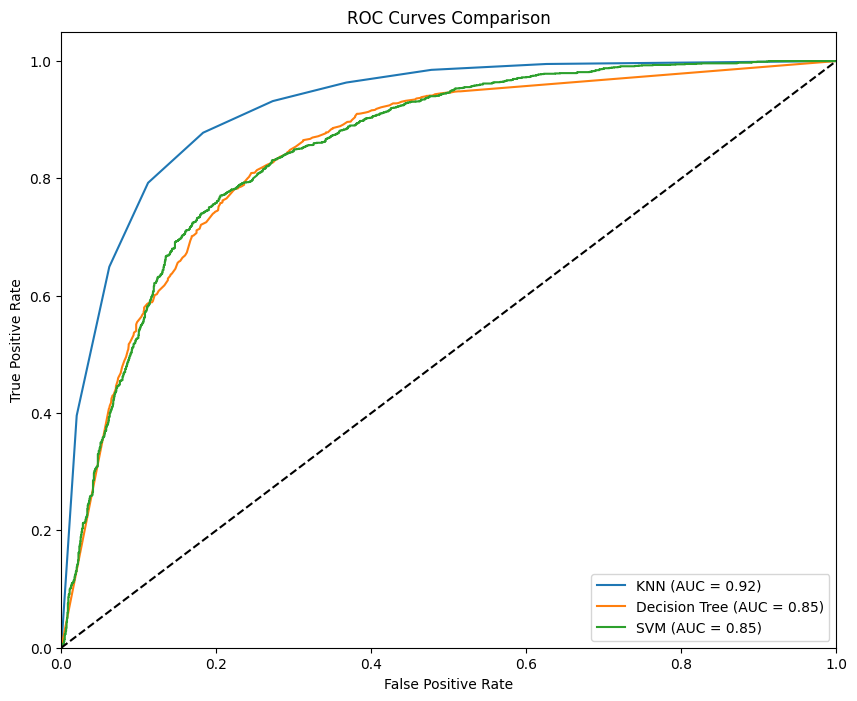

In [162]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_val, val_prob)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_val, dt_val_prob) 
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_val, svm_val_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")

# Print best parameters for each model
print("\nBest Parameters:")
print("KNN:", best_params)
print("Decision Tree:", best_params_dt)
print("SVM:", best_params_svm)
plt.show()